In [2]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging

# import awkward as ak
# import mplhep as hep
# import argparse     # to get arguments from command line executing file.py
import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau

import time
from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

verbose = False
debug = False

In [3]:
pd.set_option('display.max_columns', None)
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] - %(message)s')

# plt.rcParams['text.usetex'] = True   ### LateX in matplotlib
# !ls ../Data_TestBeam/2023_May/

In [4]:
# plt.style.use(hep.atlas.style.ATLAS)

### Generic bins options, sensors and runs import

In [6]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins = (np.arange(450, 700, 1),
        np.arange(100, 500, 1))

small_bins = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
# sensors_list = read_pickle("sensors_list.pickle")
dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

if verbose: 
#     print(sensors_list)
    print(dict_of_runs)
    print(dict_of_batches)

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

### I need the transimpedance for all the batches, channels
(now moved into LoadBatch.py)

In [13]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if (type(sensor.name) == str) and (sensor.name not in unique_names):
                unique_names.append(sensor.name)

# print(unique_names)
for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        print(f"Sensor: {sensor.name}, voltage: {sensor.voltage}, angle: {batch_object.angle}, fluence: {sensor.fluence}, in batch {batch_object.batch_number} "+"temp: %.1f°C"%batch_object.tempA+f" {S}, {ch})")
    print('-------------------------------------------')

Sensor: MCP, voltage: 2600, angle: 0.0, fluence: 0, in batch 199 temp: -31.0°C S1, Ch1)
Sensor: MCP, voltage: 2600, angle: 0.0, fluence: 0, in batch 199 temp: -31.0°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 100 temp: -32.8°C S1, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 100 temp: -32.8°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 101 temp: -33.3°C S1, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 101 temp: -33.3°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 201 temp: -31.3°C S1, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 201 temp: -31.3°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 202 temp: -32.2°C S1, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 202 temp: -32.2°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 203 temp: -32.3°C S1, Ch1)
Sensor: MCP, voltage: 2500, angl

I kinda want a 'reversed' dictionary:
for each sensor_name: have a list of batches

## Plot a single batch

In [8]:
### show all information about the batch
this_batch = 412
print(dict_of_batches[this_batch].__dict__,'\n')

### show all informations about each sensor
for S in ['S1','S2']:
    for ch, sensor in dict_of_batches[this_batch].S[S].channels.items():
        print(f"{S}, {ch}:", sensor.__dict__)

KeyError: 412

In [7]:
SAVE = False

threshold_charge = 4 #fC
DUTs = [1,2,3]

print("Batch: ", this_batch)
dir_path = {} 
df = {}  # dictionary containing the two dataframes of the two oscilloscopes
binning_method = 'rice'
for S in ["S1","S2"]: # the two scopes
    print(S)
    df[S] = load_batch(this_batch,S)
    print(f'MCP: {dict_of_batches[this_batch].S[S].channels["Ch1"].voltage} V, angle: {dict_of_batches[this_batch].angle}°', 'temperature:%.2f°C'%dict_of_batches[this_batch].tempA)
    
    time_cut = [time_mask(df[S], i, bins=5000, plot=False)[0] for i in DUTs]
#     print(dict_of_batches[this_batch].S['S2'].channels['Ch2'].__dict__)
#     plot(df[S],"2D_Tracks", dict_of_batches[this_batch], S, bins=bins,
#          n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}', fmt='jpg')
    
#     plot(df[S], "2D_Sensors", dict_of_batches[this_batch], S, bins=large_bins, bins_find_min=binning_method,
#          n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_pulseHeight_cut_large_bins', fmt='jpg')
    
    plot(df[S], "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='XY', mask=time_cut,
        bins=large_bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC')
    
#     plot(df[S], "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False,
#         bins=bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC')
    #     savefig=True, savefig_details='_S2')

Batch:  412
S1


ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

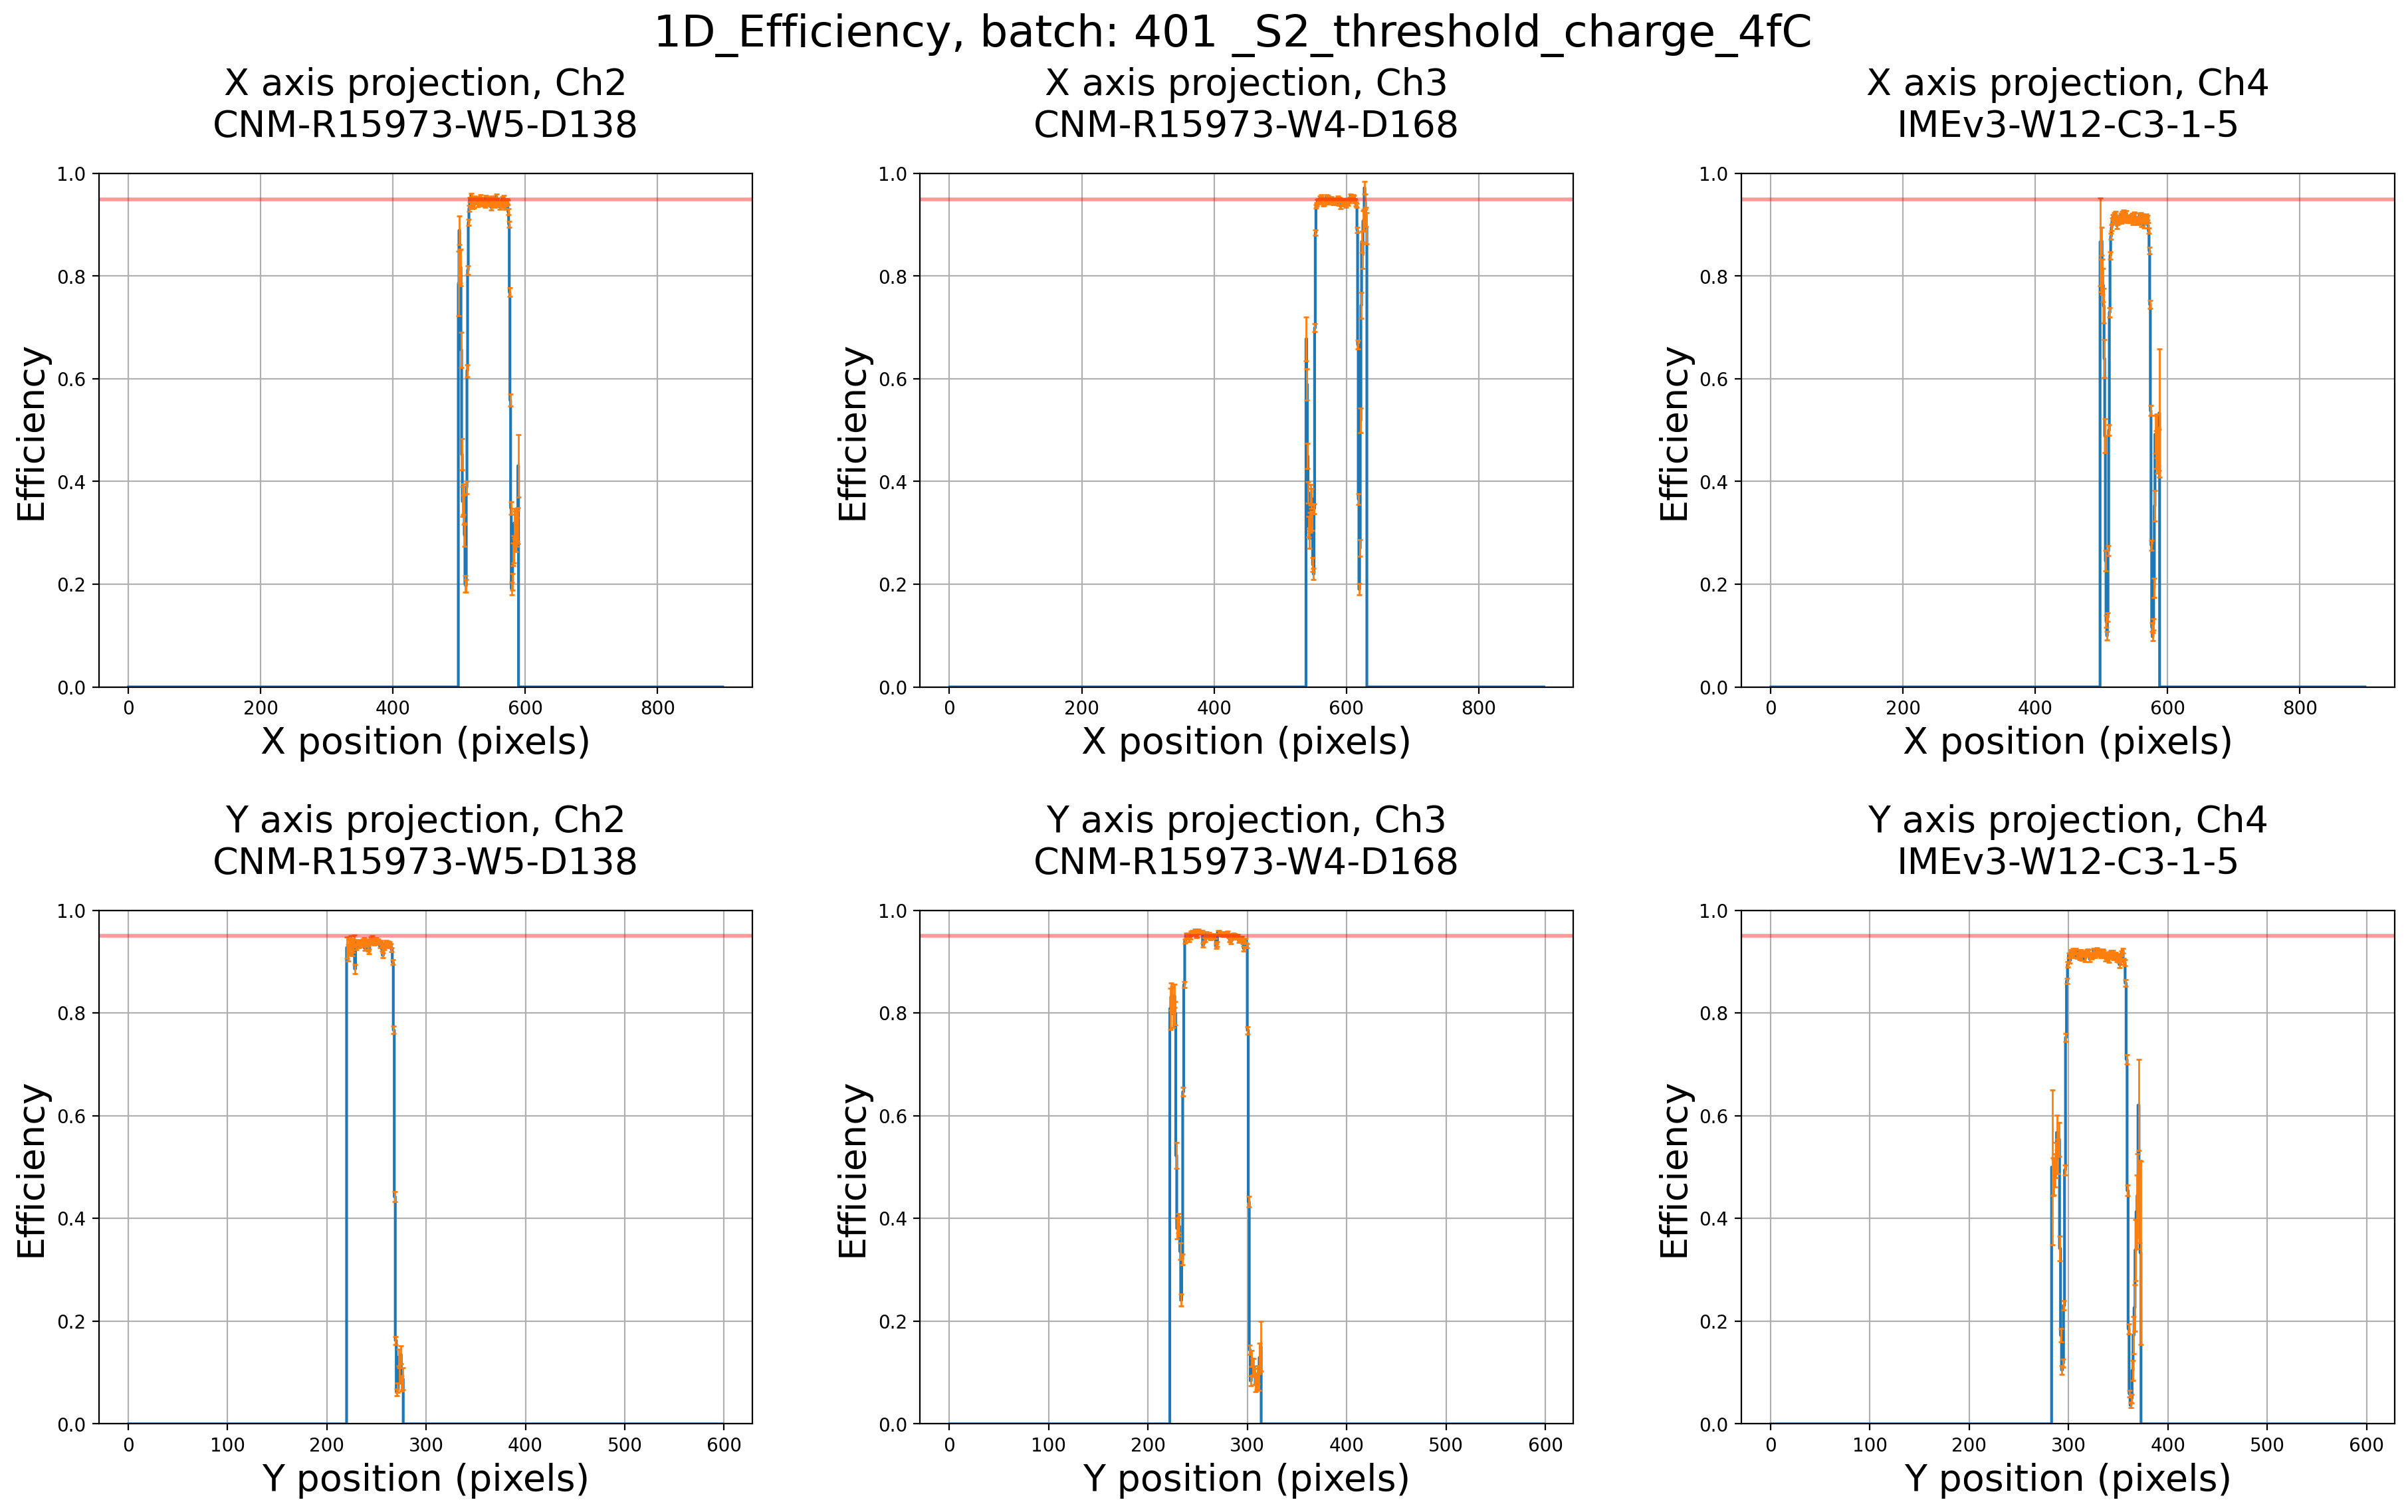

In [14]:
fig, ax = plot(df[S], "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='extended', mask=time_cut,
        bins=large_bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC')

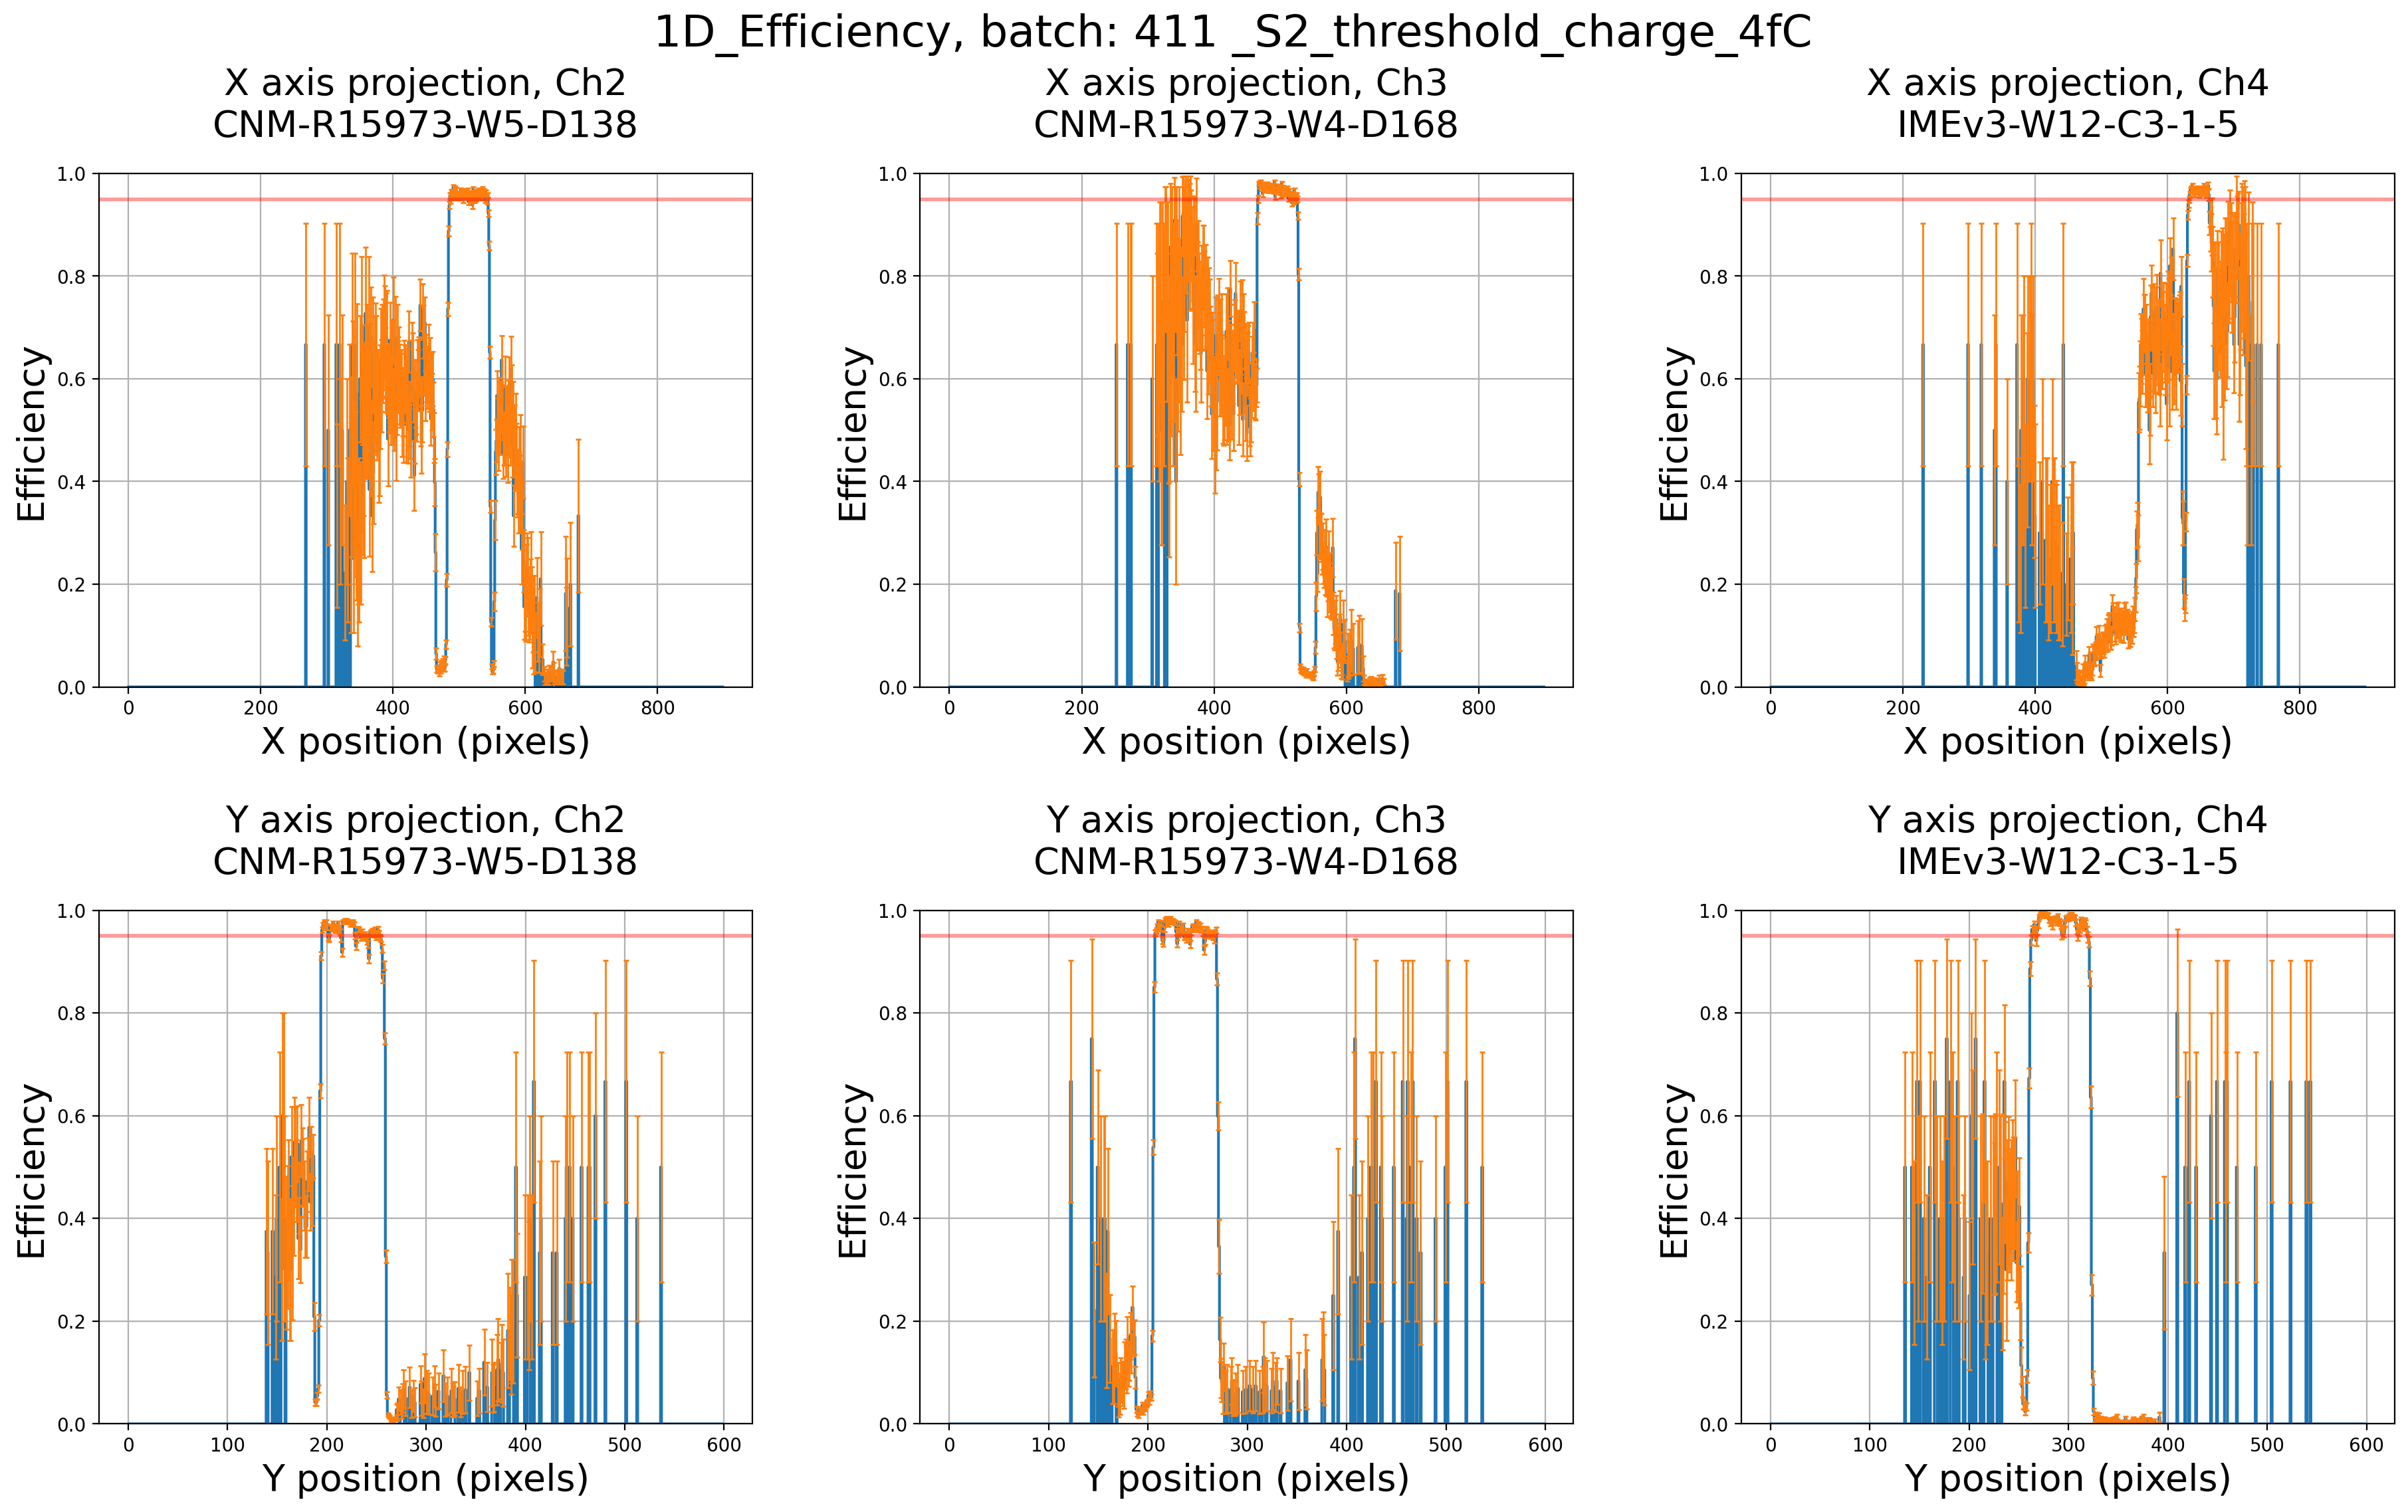

In [28]:
dict_of_batches[this_batch].S['S2'].get_sensor('ch2').fluence

'8.00E+14'

## Calculate all minimums (for this batch)

In [29]:
mins = {}
for S in ["S1","S2"]:
    mins[S] = [find_min_btw_peaks(df[S][f"pulseHeight_{i}"], bins='rice', plot=False) for i in range(1,4)]
    mins[S].insert(0,None)     ### insert None as the 'peak' of the MCP

[WARNING] - More than one minimum found at: [41.334976, 62.74684]


## PulseHeight vs $\Delta$t plot

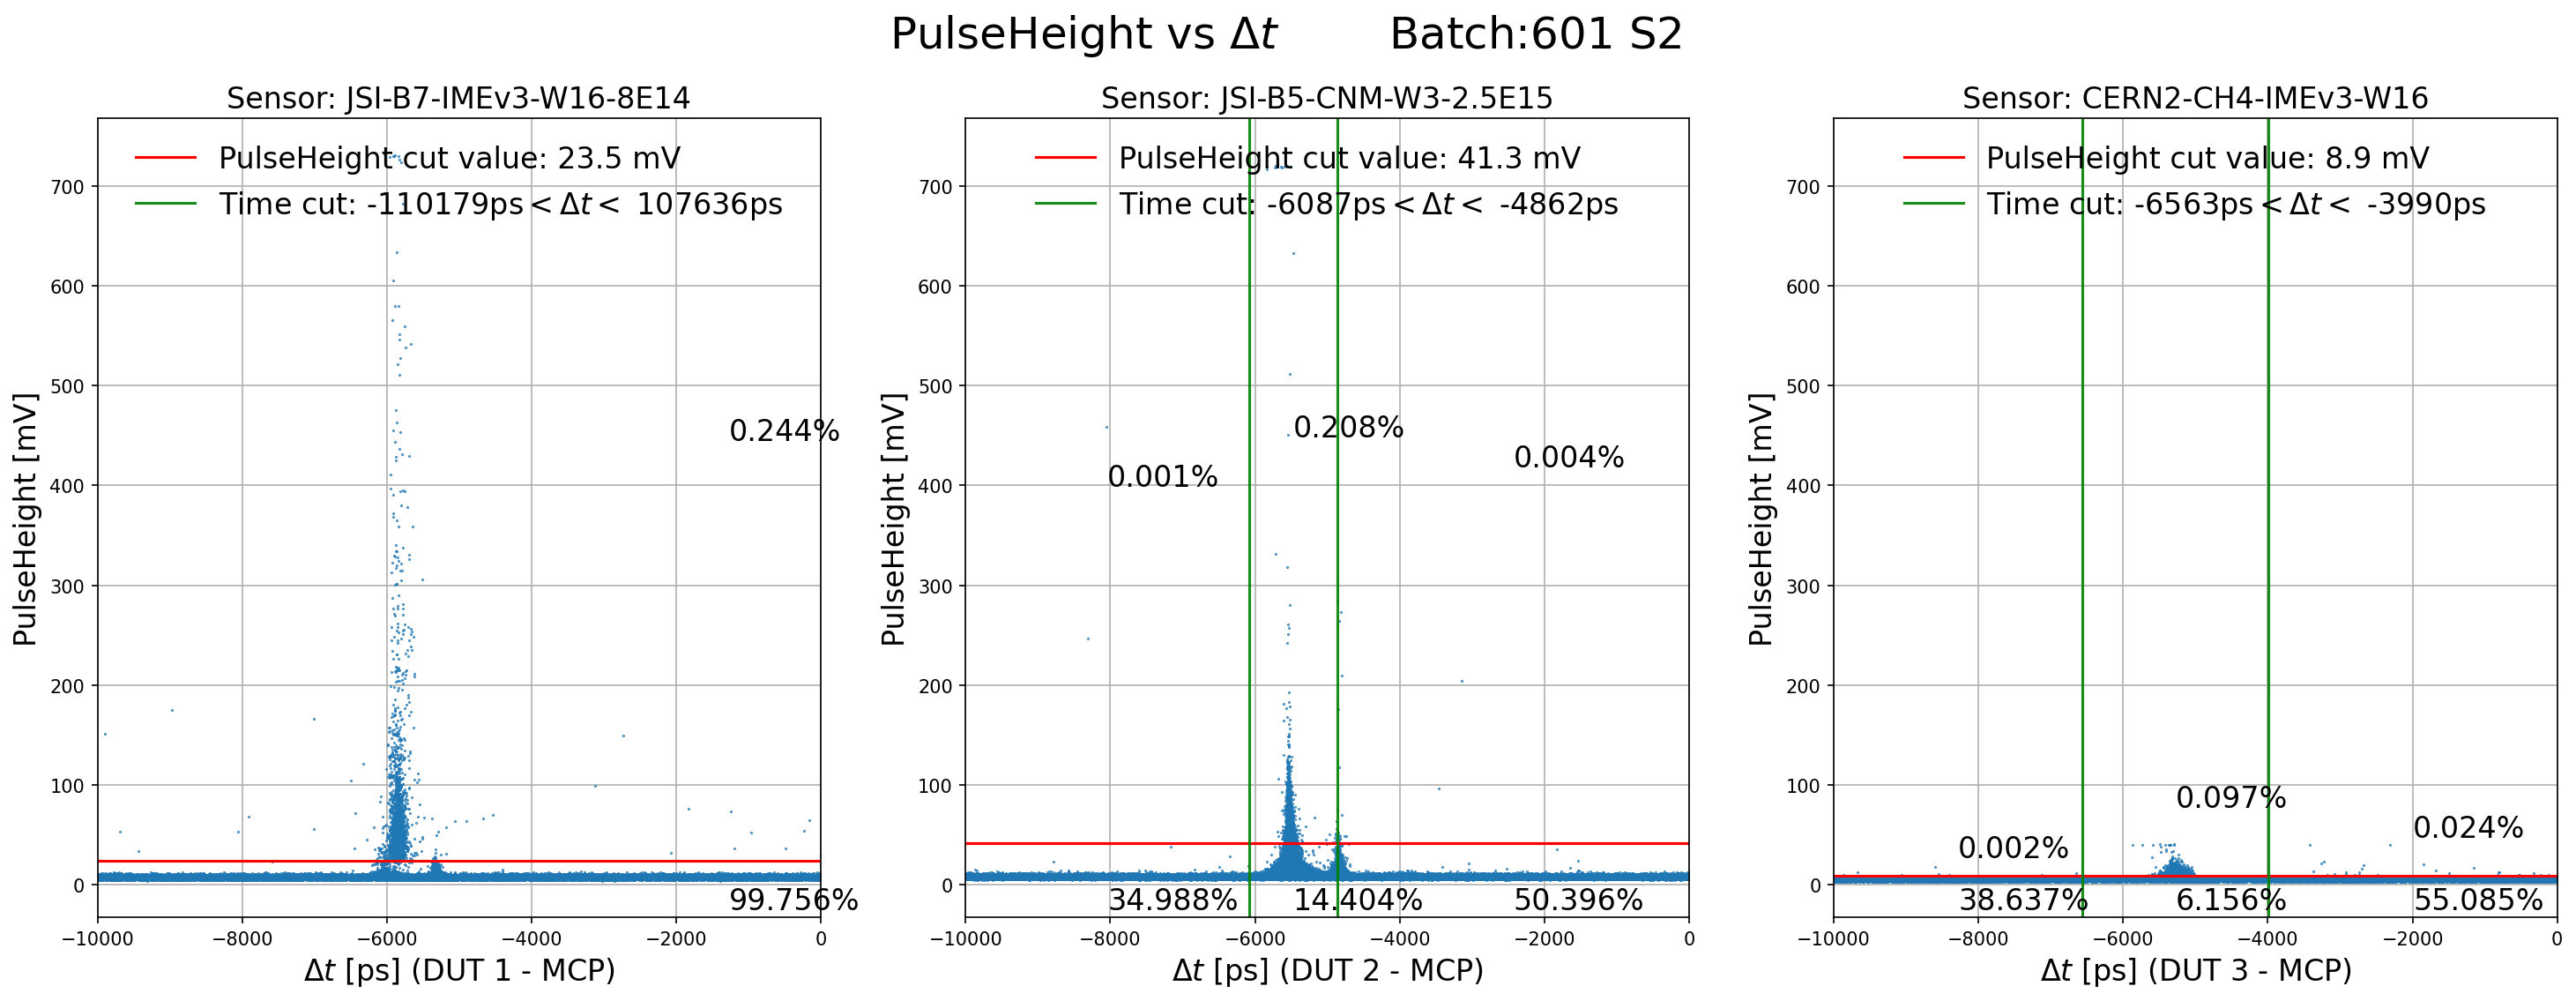

In [30]:
### make it into an interactive plot???? mmm.. not really working
### I should probably add it to plot()
this_scope = 'S2'
DUTs = [1,2,3]
xlim = (-10e3,0)

fig, axes = plt.subplots(figsize=(8*len(DUTs),8), ncols=len(DUTs), dpi=150)#, sharey=True )
for i,dut in enumerate(DUTs):

    info = time_mask(df[this_scope], dut, bins=5000, plot=False)[1]
    left_base, right_base = info['left_base'], info['right_base']
    
    pulse_cut = mins[this_scope][dut]
    time_array = np.array(df[this_scope][f'timeCFD50_{dut}']-df[this_scope][f'timeCFD20_0'])
    pulseheight_array = np.array(df[this_scope][f'pulseHeight_{dut}'])
    axes[i].plot(time_array, pulseheight_array, '.', markersize=0.8)
    
    axes[i].set_xlim(xlim)
    ylim = axes[i].get_ylim()
    
    total = len(time_array)/100  ### so I get percentage directly
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array<pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, -25), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array<pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, -25), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array<pulse_cut)])/total)+"%", ((right_base+left_base)/2, -25), fontsize=16)

    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array>pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, (pulse_cut+ylim[1])/2), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array>pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, (pulse_cut+ylim[1])/2+20), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array>pulse_cut)])/total)+"%", ((right_base+left_base)/2, (pulse_cut+ylim[1])/2+50), fontsize=16)

    axes[i].axhline(pulse_cut,color='r', label="PulseHeight cut value: %.1f mV"%pulse_cut)
    axes[i].axvline(left_base, color='g', alpha=.9, label="Time cut: %.0fps$<\Delta t<$ %.0fps"%(left_base, right_base))
    axes[i].axvline(right_base, color='g', alpha=.9)
    axes[i].set_xlabel(f"$\Delta t$ [ps] (DUT {dut} - MCP)", fontsize=16)
    axes[i].set_ylabel(f"PulseHeight [mV]", fontsize=16)
    axes[i].grid('-')
#     axes[i].set_xlim(-7e3,-4e3)
    axes[i].legend(fontsize=16, loc='upper center', framealpha=0)
    axes[i].set_title(f"Sensor: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}", fontsize=16)
    
for ax in axes:
    ax.sharey(axes[0])

fig.suptitle(f"PulseHeight vs $\Delta t$ \t Batch:{this_batch} {this_scope} ", fontsize=24)
fig.savefig(f"../various plots/pulseHeight_vs_deltat_{this_batch}_{this_scope}_{DUTs}.jpg") ### svg is way too big

## PLOT ALL BATCHES (might be slow, can be done in parts)

In [14]:
threshold_charge = 4

### SAVE THE PLOTS FOR ALL BATCHES
binning_method = 'rice'
RUN_ALL_BATCHES = False  ### so I don't accidentally run this
if RUN_ALL_BATCHES:
    for S in ["S1","S2"]: ### the two scopes
        if S=="S2": continue
        for this_batch in np.sort(list(dict_of_runs[S].keys())):  ### I sort them so I can restart from the batch I want
            if this_batch>=0:# and this_batch<=500:
                print("Batch: ", this_batch)
                dir_path = f"../Data_TestBeam/2023_May/{S}/"
                file_path = f"tree_May2023_{S}_{this_batch}.root"    
                try:
                    df = root_to_df(os.path.join(dir_path, file_path), branches)
                except:
                    print("something wrong reading the file")
                    continue
                df = df.drop(columns=columns_to_remove)
#                 plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins,
        #              savefig=True, savefig_details=f'_{S}')
#                 plot(df,"1D_Tracks", dict_of_batches[this_batch], S, bins=large_bins,
    #                  savefig=True, savefig_details=f'_{S}')
        #         bins = 1000
#                 plot(df, "pulseHeight", dict_of_batches[this_batch], S, bins=bins,
        #             savefig=True, savefig_details=f"_{S}_bins_{bins}")
#                 plot(df, '2D_Sensors', dict_of_batches[this_batch], S,
#                      bins=large_bins, bins_find_min=binning_method, savefig=False, savefig_details=f'_{S}_large_bins')#_{binning_method}')
#                 plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True,
#                     bins=large_bins, bins_find_min=binning_method, savefig=True, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_large_bins')
#                 plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False,
#                     bins=large_bins, bins_find_min=binning_method, savefig=True, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC_large_bins')
            ### I think something is leaking memory!!!
            plt.close('all') ### I think this worked. maybe not actually


## Plot a single run

In [14]:
# ### looking at single runs 
# dir_path = f"../Data_TestBeam/2023_May/S1/"
# run = 9723
# file_path = f"tree00{run}.root"    
# df_run = root_to_df(os.path.join(dir_path, file_path), branches)
# df_run = df_run.drop(columns=columns_to_remove)
    
# plot(df_run,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S1"], bins=bins,
#     savefig=True, savefig_details=f"_single_run_{run}")
# # plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins)

## Improved efficiency study

[WARNING] - More than one minimum found at: [41.334976, 62.74684]


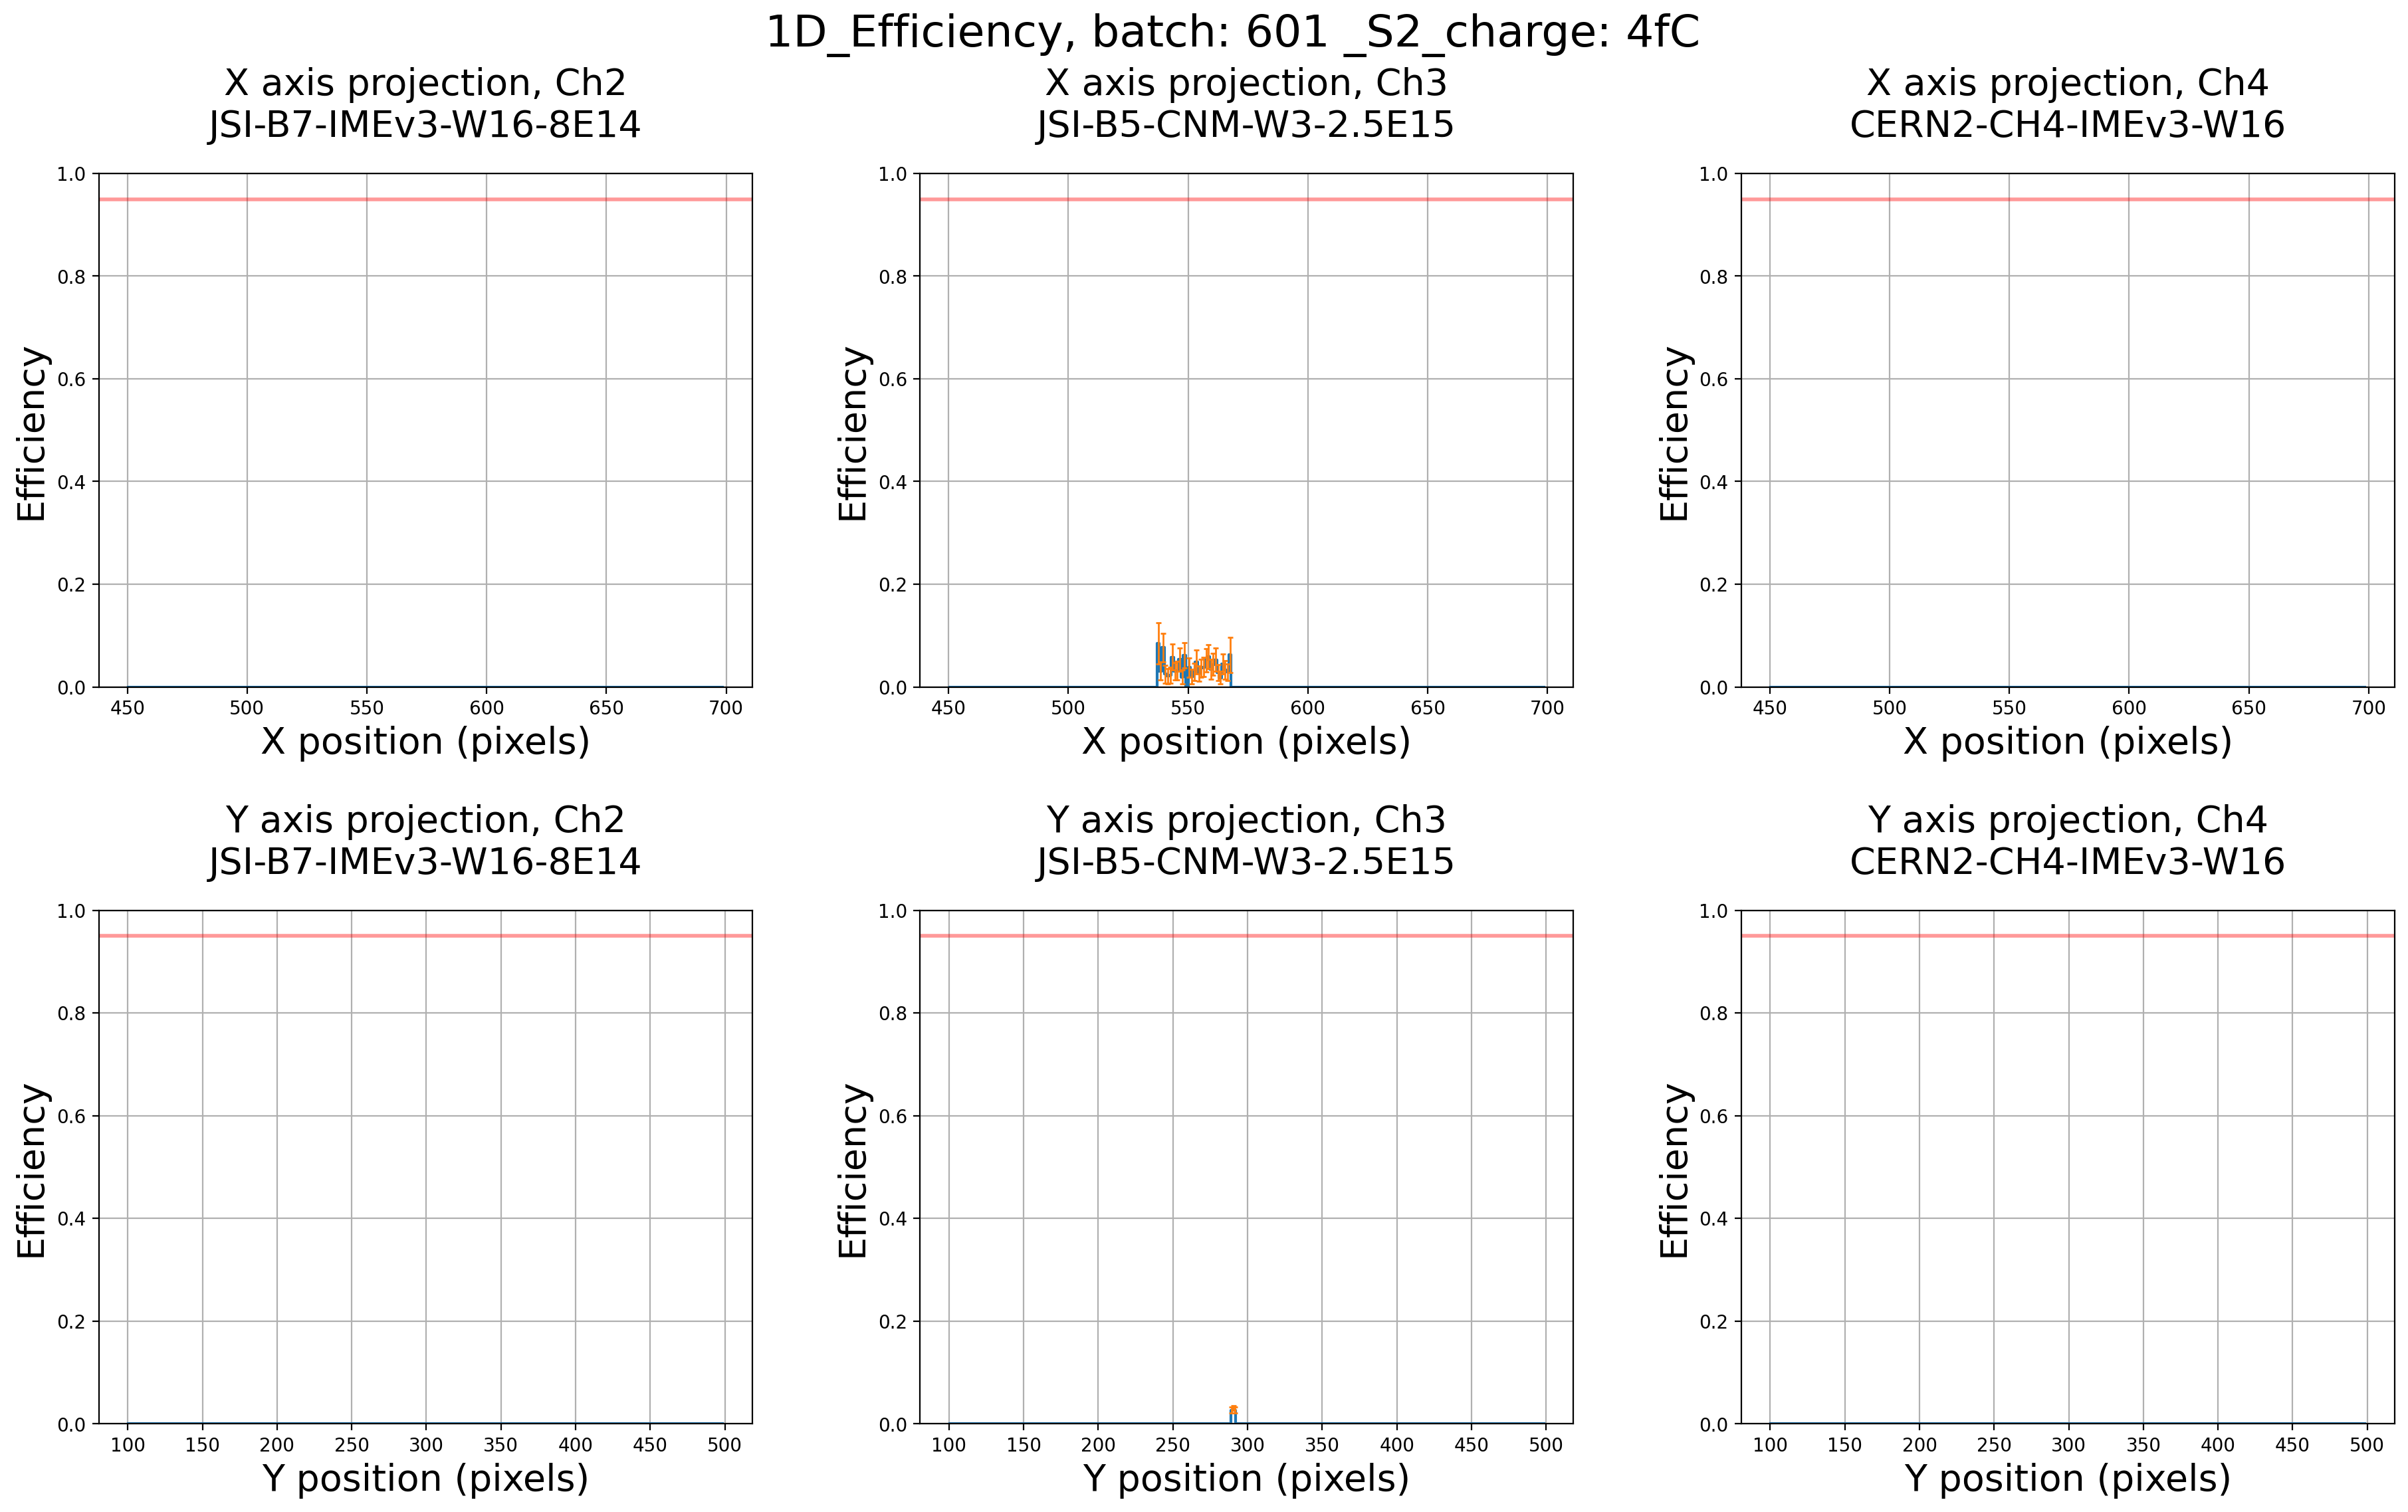

(<Figure size 3600x2000 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'X axis projection, Ch2\nJSI-B7-IMEv3-W16-8E14'}, xlabel='X position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'X axis projection, Ch3\nJSI-B5-CNM-W3-2.5E15'}, xlabel='X position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'X axis projection, Ch4\nCERN2-CH4-IMEv3-W16'}, xlabel='X position (pixels)', ylabel='Efficiency'>],
        [<AxesSubplot:title={'center':'Y axis projection, Ch2\nJSI-B7-IMEv3-W16-8E14'}, xlabel='Y position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'Y axis projection, Ch3\nJSI-B5-CNM-W3-2.5E15'}, xlabel='Y position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'Y axis projection, Ch4\nCERN2-CH4-IMEv3-W16'}, xlabel='Y position (pixels)', ylabel='Efficiency'>]],
       dtype=object))

In [15]:
this_scope = "S2"
threshold_charge = 4
plot(df[this_scope], "1D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, geometry_cut=True, n_DUT=[1,2,3],
                 threshold_charge=threshold_charge,
                 savefig=False, savefig_details=f'_{this_scope}_charge: {threshold_charge}fC')

# fig.savefig("../various plots/1D_Efficiency_410_S1_charge: 2fC.svg")

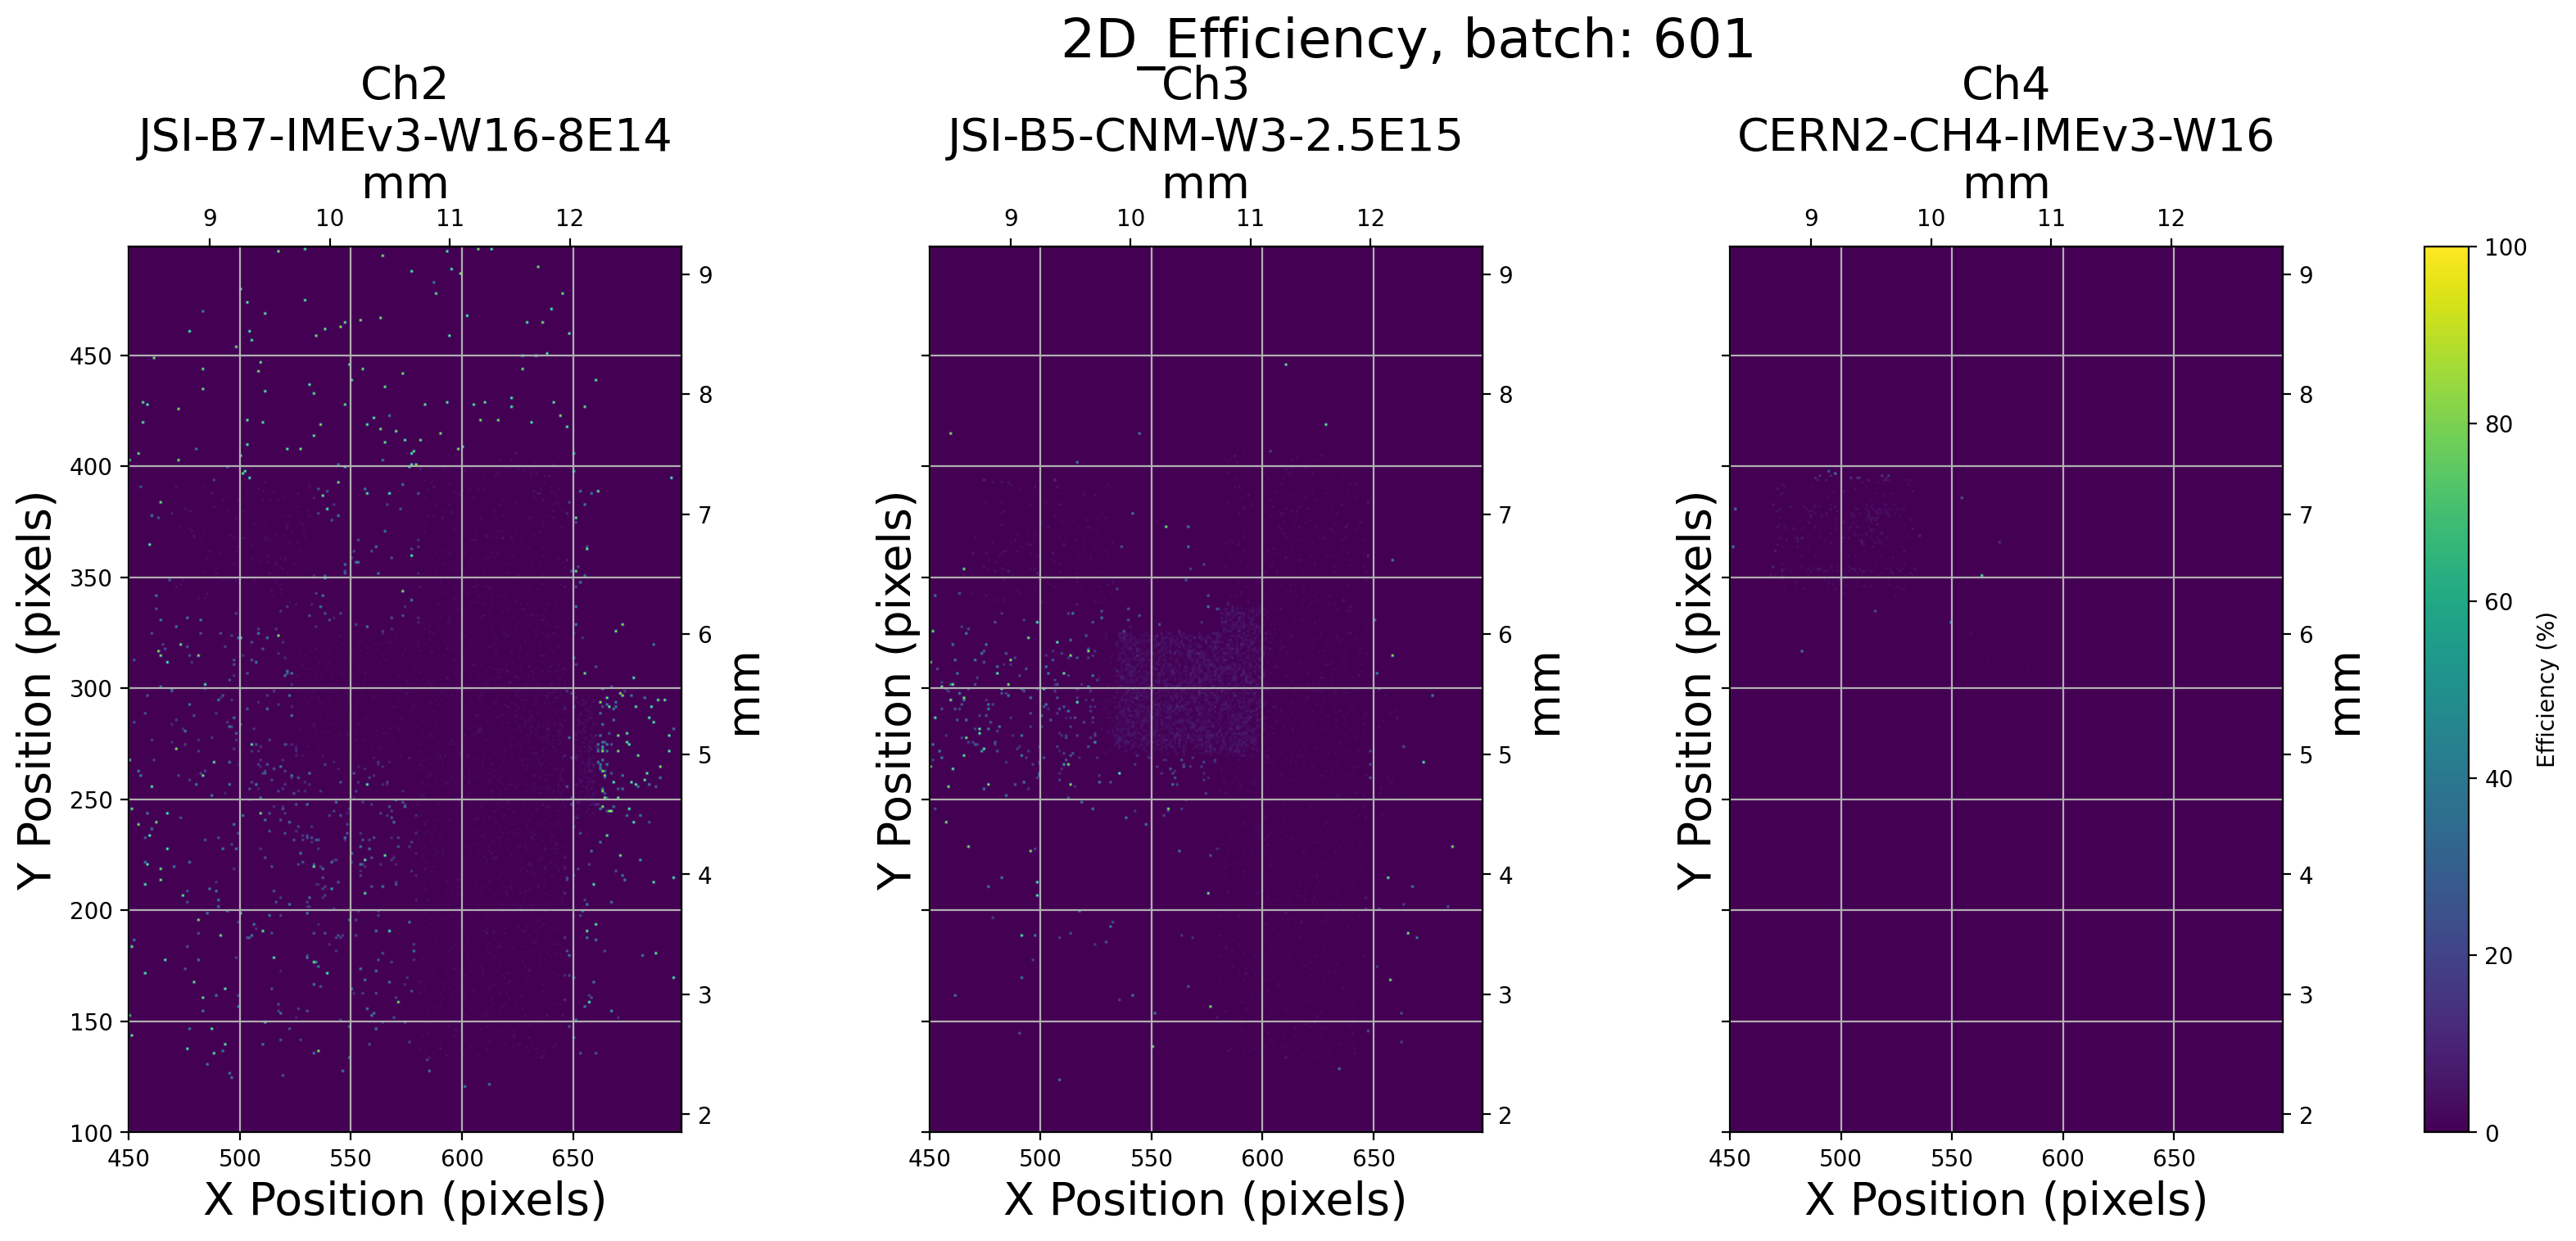

In [16]:
fig, axes = plot(df[this_scope], "2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, geometry_cut=False, n_DUT=[1,2,3], sensors=sensors_list[this_batch][this_scope],
                 threshold_charge=threshold_charge, savefig=False)

In [17]:
# S = "S1"
# plot(df[S],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
#      savefig=False, savefig_details=f'_{S}')

### Example on how the edges of the sensor are found in 'find_edges()'

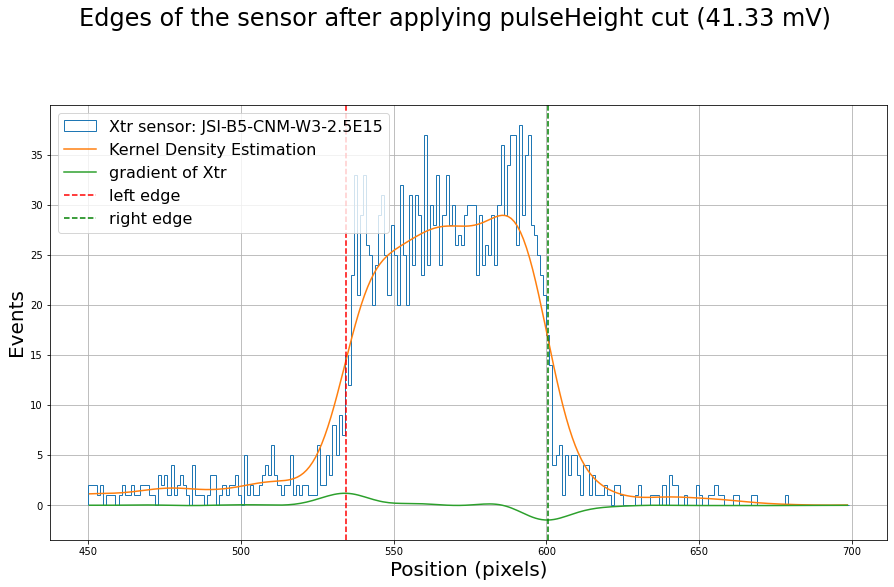

In [18]:
dut = 2
Xtr_cut = df[this_scope][f'Xtr_{dut}'].loc[df[this_scope][f'pulseHeight_{dut}']>mins[this_scope][dut]]

fig, ax = plt.subplots(figsize=(15,8))
hist, my_bins, _ = ax.hist(Xtr_cut, bins=bins[0], histtype='step', label=f"Xtr sensor: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")

kde = gaussian_kde(Xtr_cut)
density_factor = sum(hist)*np.diff(my_bins)
bins_centers = (my_bins[1:]+my_bins[:-1])/2
values = time_limited_kde_evaluate(kde, bins_centers)*density_factor
ax.plot(bins_centers,values, label="Kernel Density Estimation")
ax.plot(bins_centers, np.gradient(values), label='gradient of Xtr')

left_edge = bins_centers[np.argmax(np.gradient(values))]
right_edge = bins_centers[np.argmin(np.gradient(values))]

ax.axvline(left_edge, color='r', linestyle='--', label='left edge')
ax.axvline(right_edge, color='g', linestyle='--', label='right edge')
fig.suptitle("Edges of the sensor after applying pulseHeight cut (%.2f mV)"%mins[this_scope][dut], fontsize=24, y=1.05)

ax.set_xlabel("Position (pixels)", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.grid('--')
ax.legend(fontsize=16, loc='upper left')

# fig.savefig(f"../various plots/locating_edges_Xtr_batch_{this_batch}_{this_scope}_DUT{dut}.svg")

In [19]:
# print(sensors_list[this_batch][this_scope]['Ch2'])
# print(dict_of_batches[this_batch].S[this_scope].channels['Ch2'].name)

In [20]:
# fig, ax = plot(df[this_scope], "2D_Tracks",batch=this_batch, bins=large_bins)
# fig.suptitle("2D_Tracks, batch: 410", y=0.95)
# # fig

## Efficiency Study

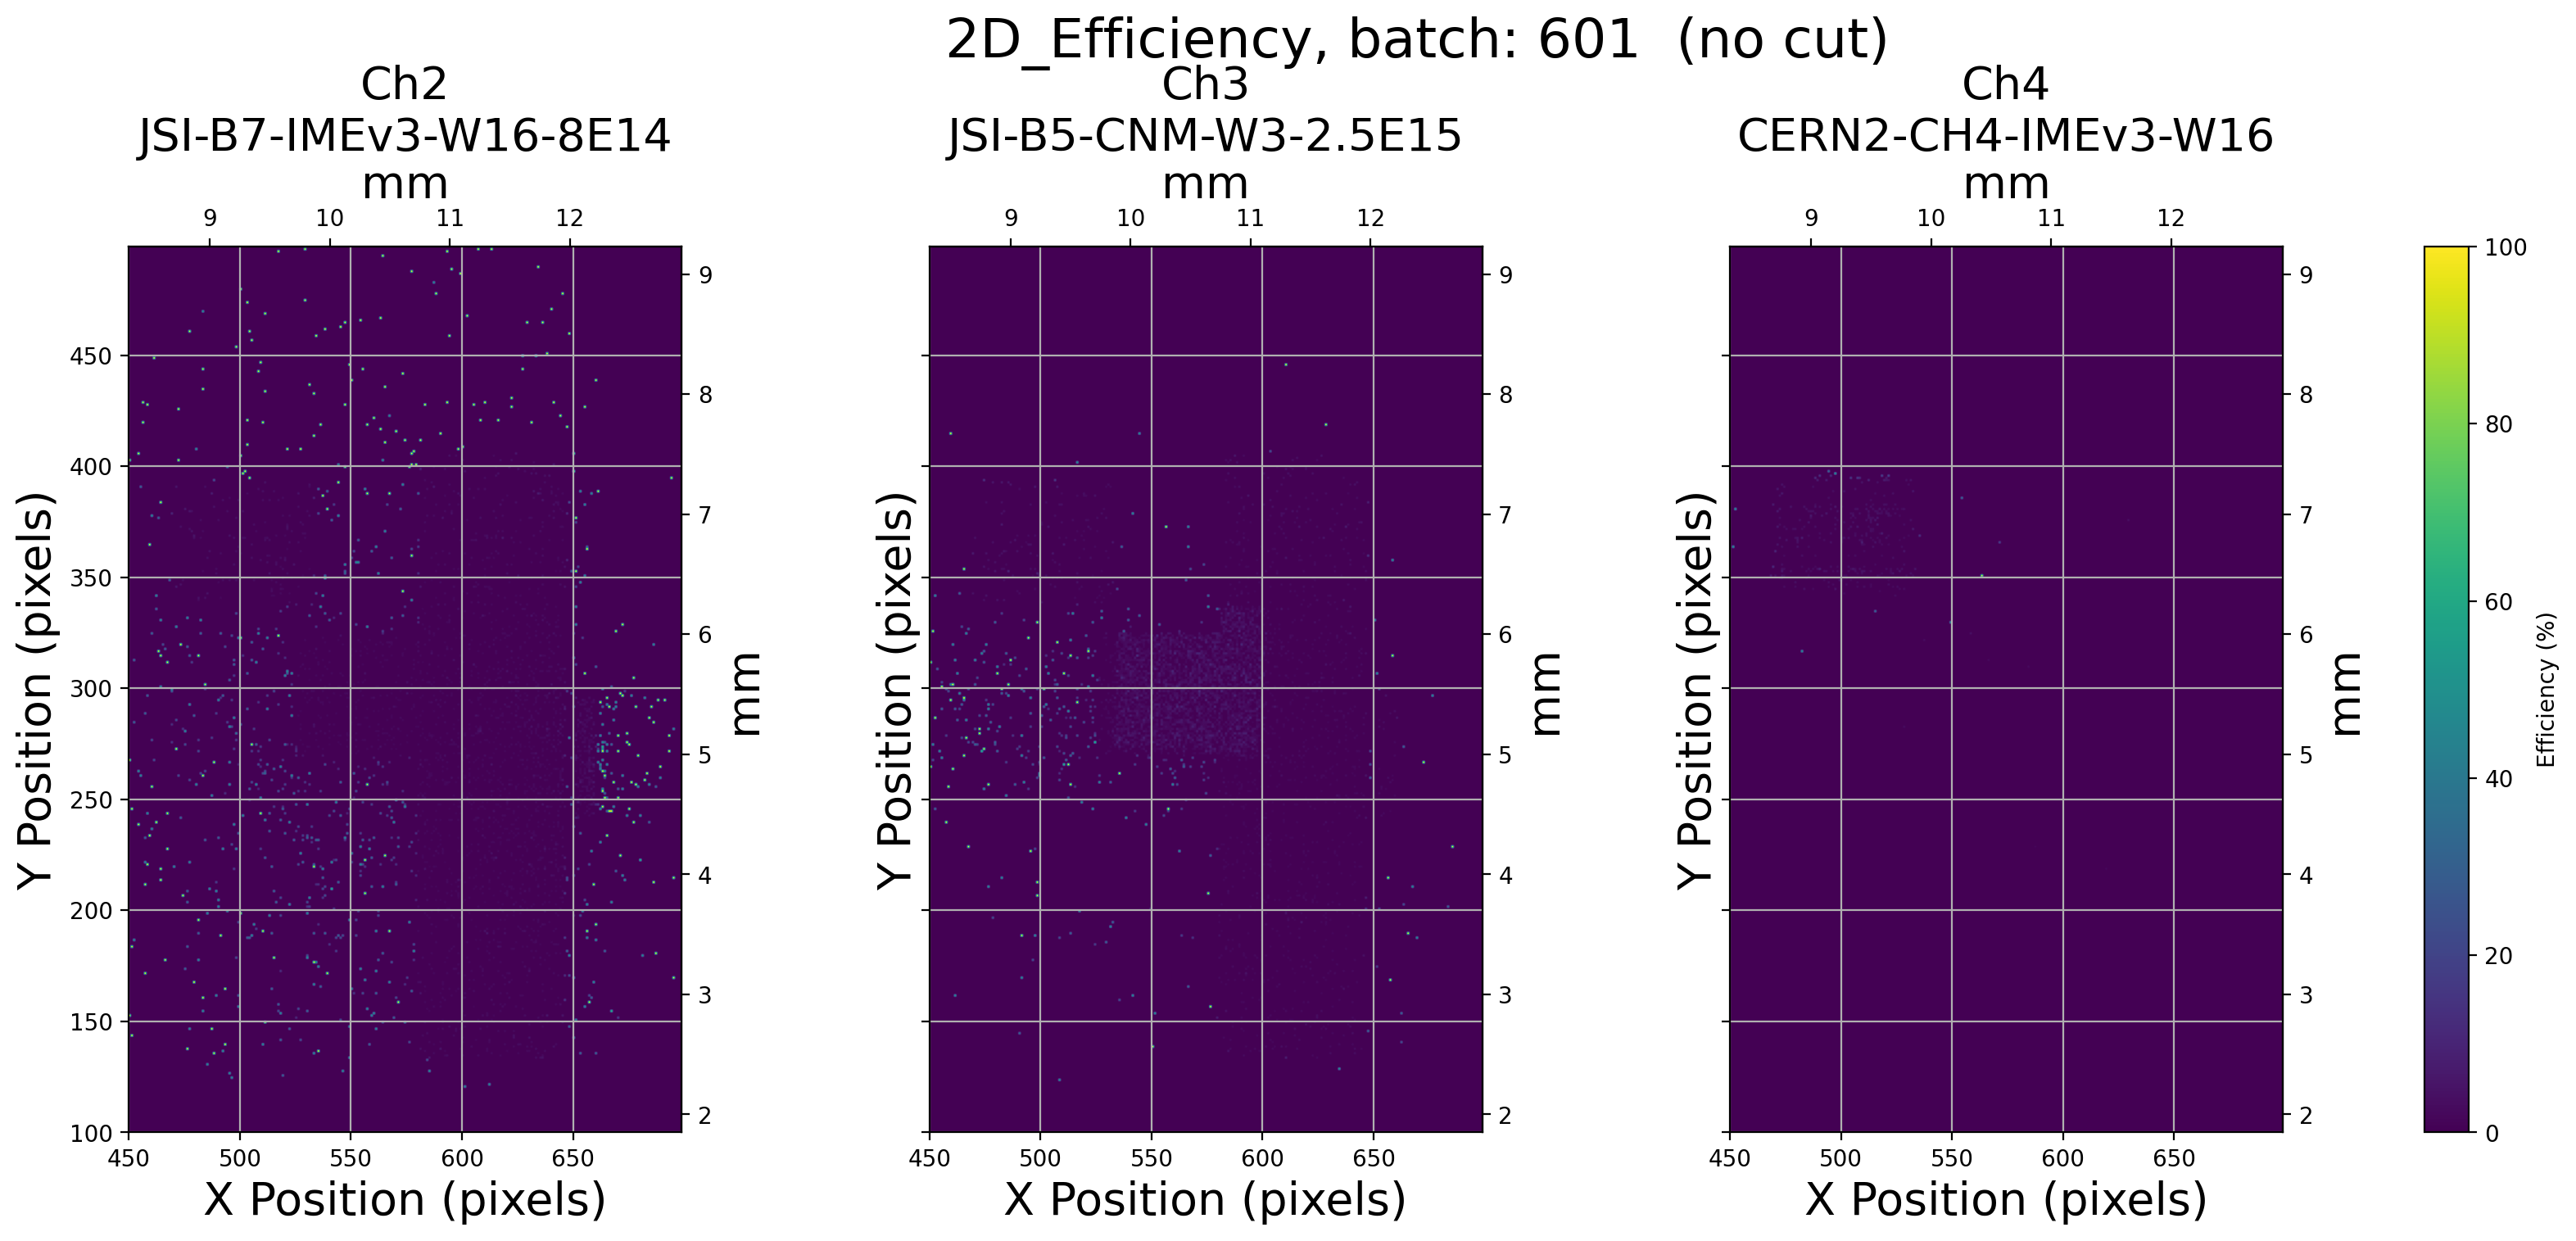

In [21]:
### bin per bin efficiency
threshold_charge = 4 #fC
# transimpedance = dict_of_batches[this_batch].S[this_scope].channels[]

fig,axes = plot(df[this_scope], "2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, geometry_cut=False,
                threshold_charge=threshold_charge, savefig=False, savefig_details=" (no cut)")
# fig

### plotting where the noise is
aka where pulseHeight<mins.
This shows how 'good' cutting the PulseHeight is, so where the events that have pulseHeight<mins lie

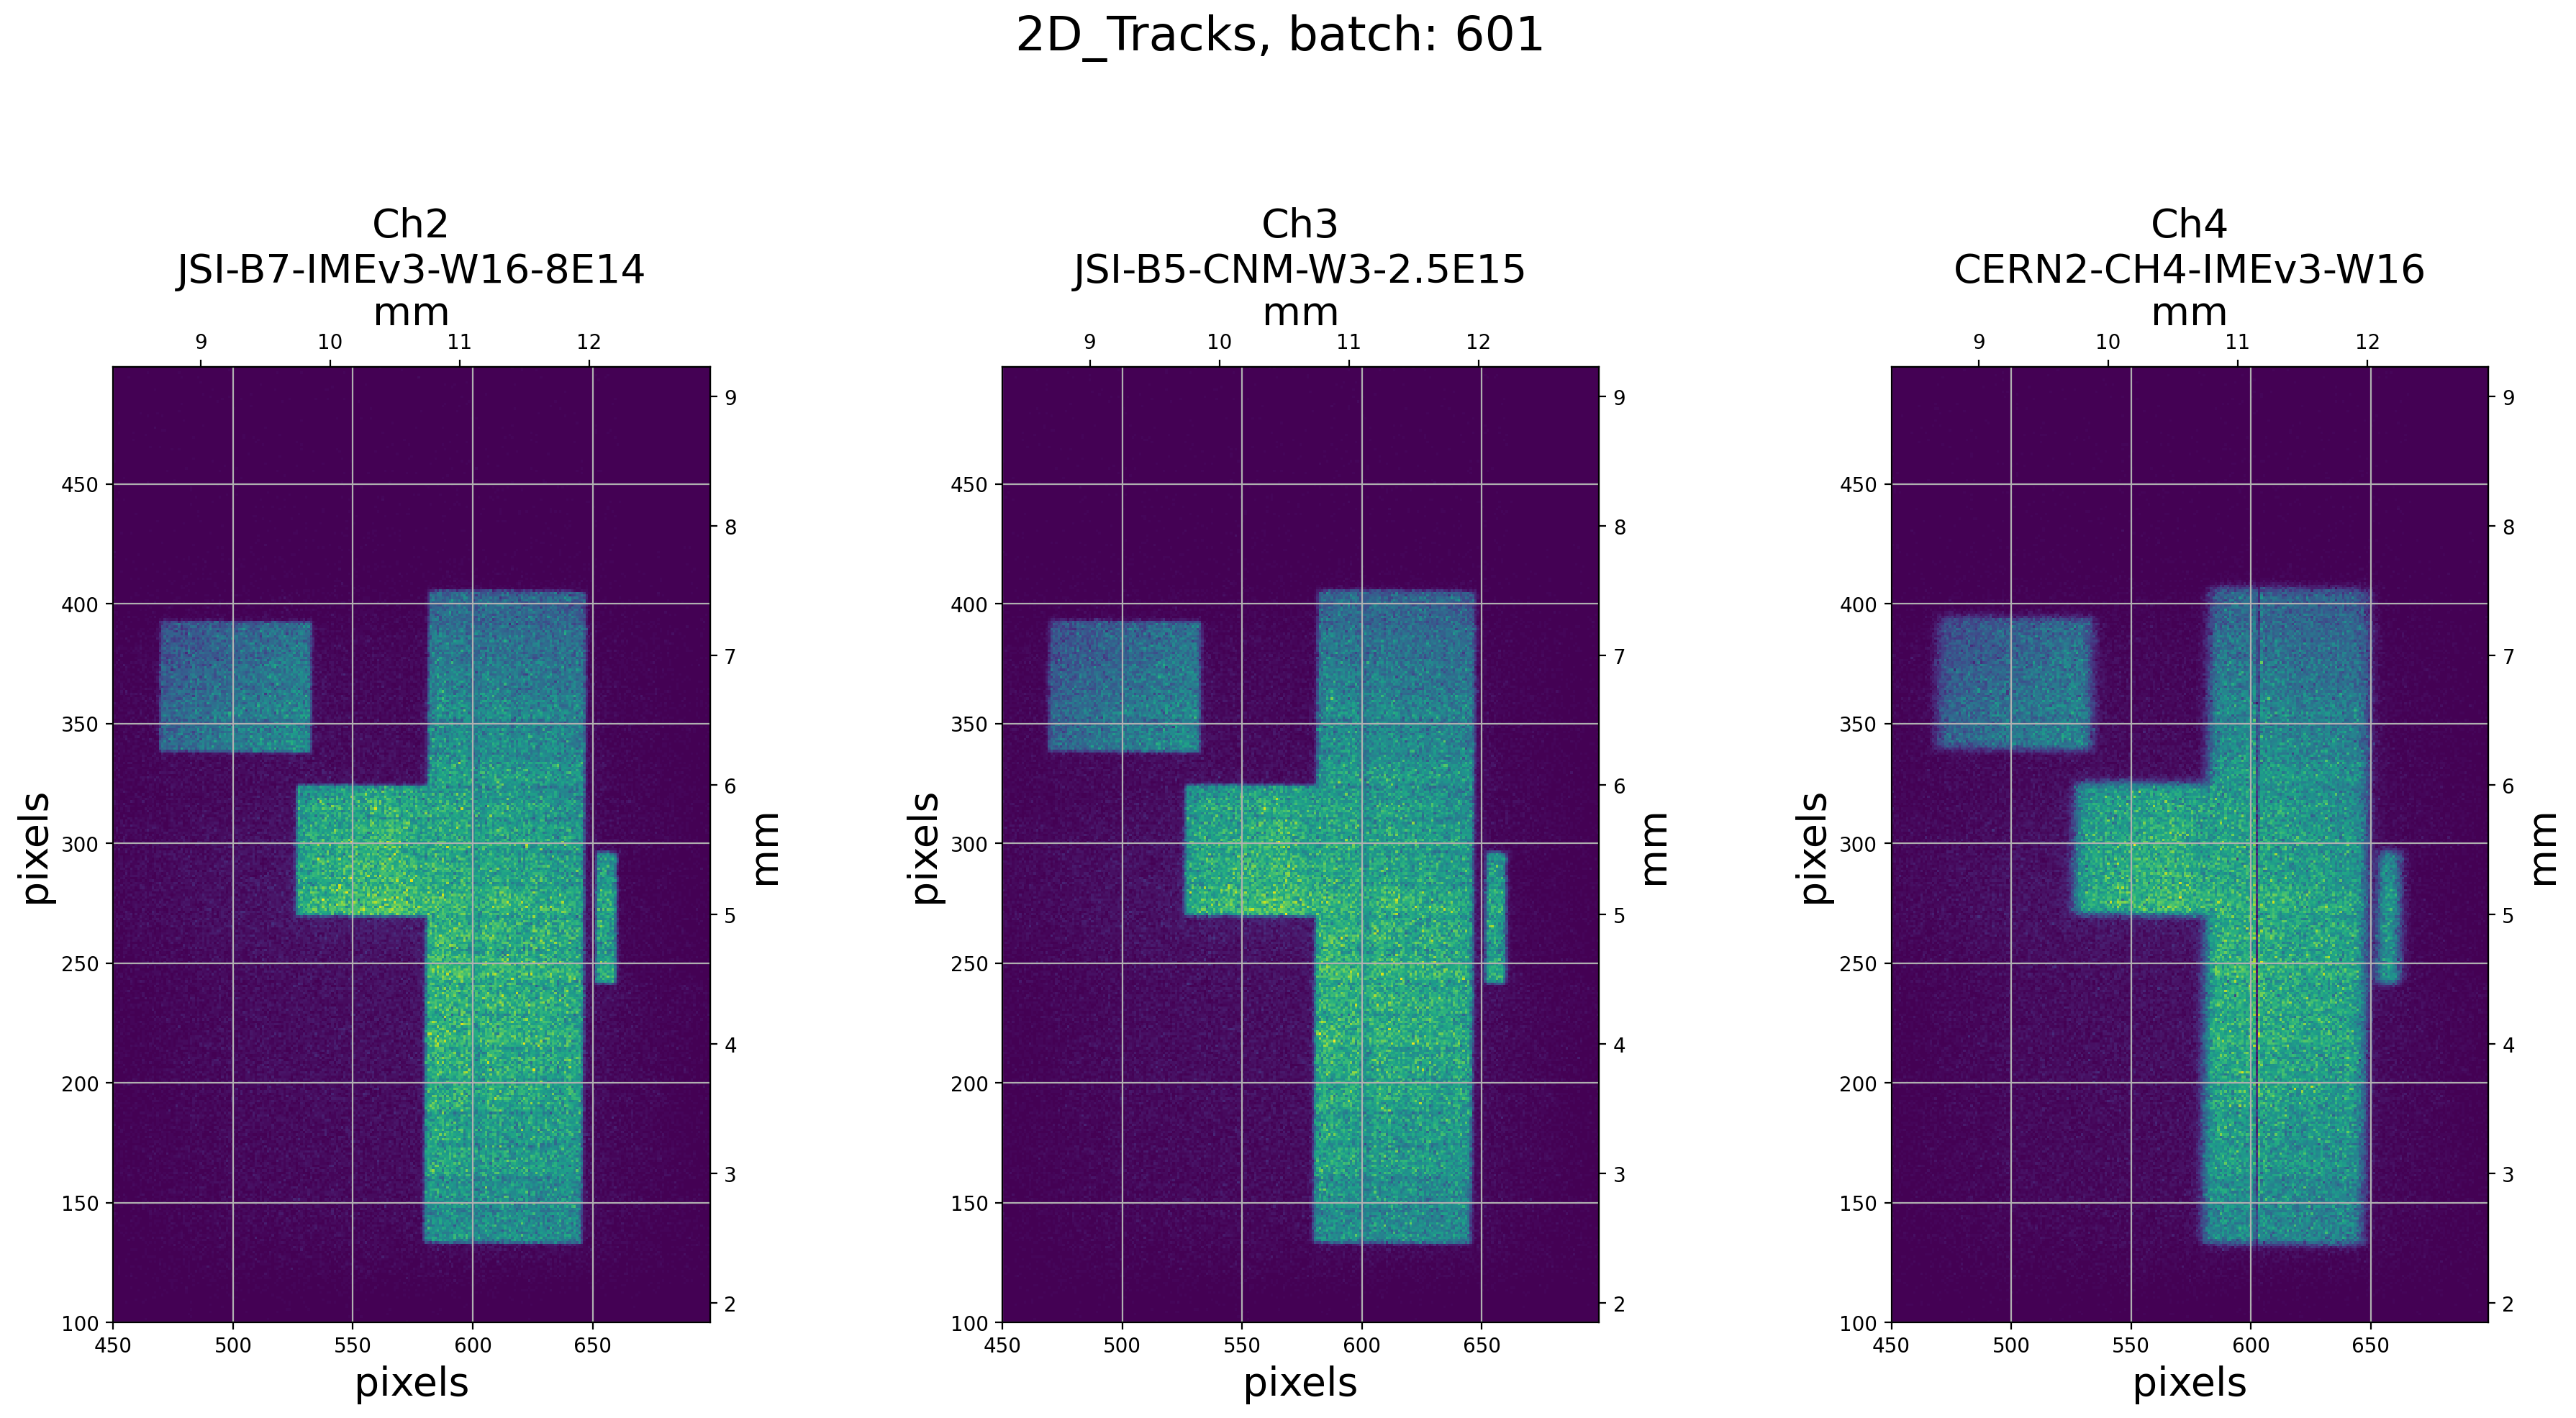

In [22]:
# this_scope = "S2"
mask = [df[this_scope][f"pulseHeight_{i}"]<mins[this_scope][i] for i in range(1,4)]

fig,axes = plot(df[this_scope], "2D_Tracks", dict_of_batches[this_batch], this_scope, bins=bins, mask=mask)

## Total efficiency with pulseHeight cut

In [23]:
# this_scope = "S1"
# dut = 1
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
# threshold_range = np.arange(0.5, 20, 0.5)

# ### full surface and pulseHeight cut
# efficiency_range = []
# error_range = []
# geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut)[0]
# pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
# for charge in threshold_range:
#     ### efficiency with error
#     efficiency_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)[0])
#     error_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)[1]) 

# fig, ax = plt.subplots(figsize=(10,6), dpi=150)
# ax.errorbar(threshold_range, efficiency_range, yerr=error_range, marker='.', markersize=3, linewidth=0,
#             elinewidth=1, ecolor='k', capsize=1.5,
#         label=f"Ch{dut+1}, Total tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

# ax.set_title(f"Total efficiency depending on threshold charge \n \
# on full surface of Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch} \n \
# (with pulseHeight cut)")
# ax.set_xlabel("Threshold charge (fC)")
# ax.set_ylabel("Total efficiency")
# ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
# ax.grid('--')
# ax.legend()
# # fig.savefig(f"..\various plots\Total_efficiency_change_{this_batch}_{this_scope}_DUT{dut}_pulseheight_cut.svg")


## Efficiency in the central part 
Calculate the efficiency in the central $0.5x0.5$ $mm^2$

[WARNING] - More than one minimum found at: [41.334976, 62.74684]


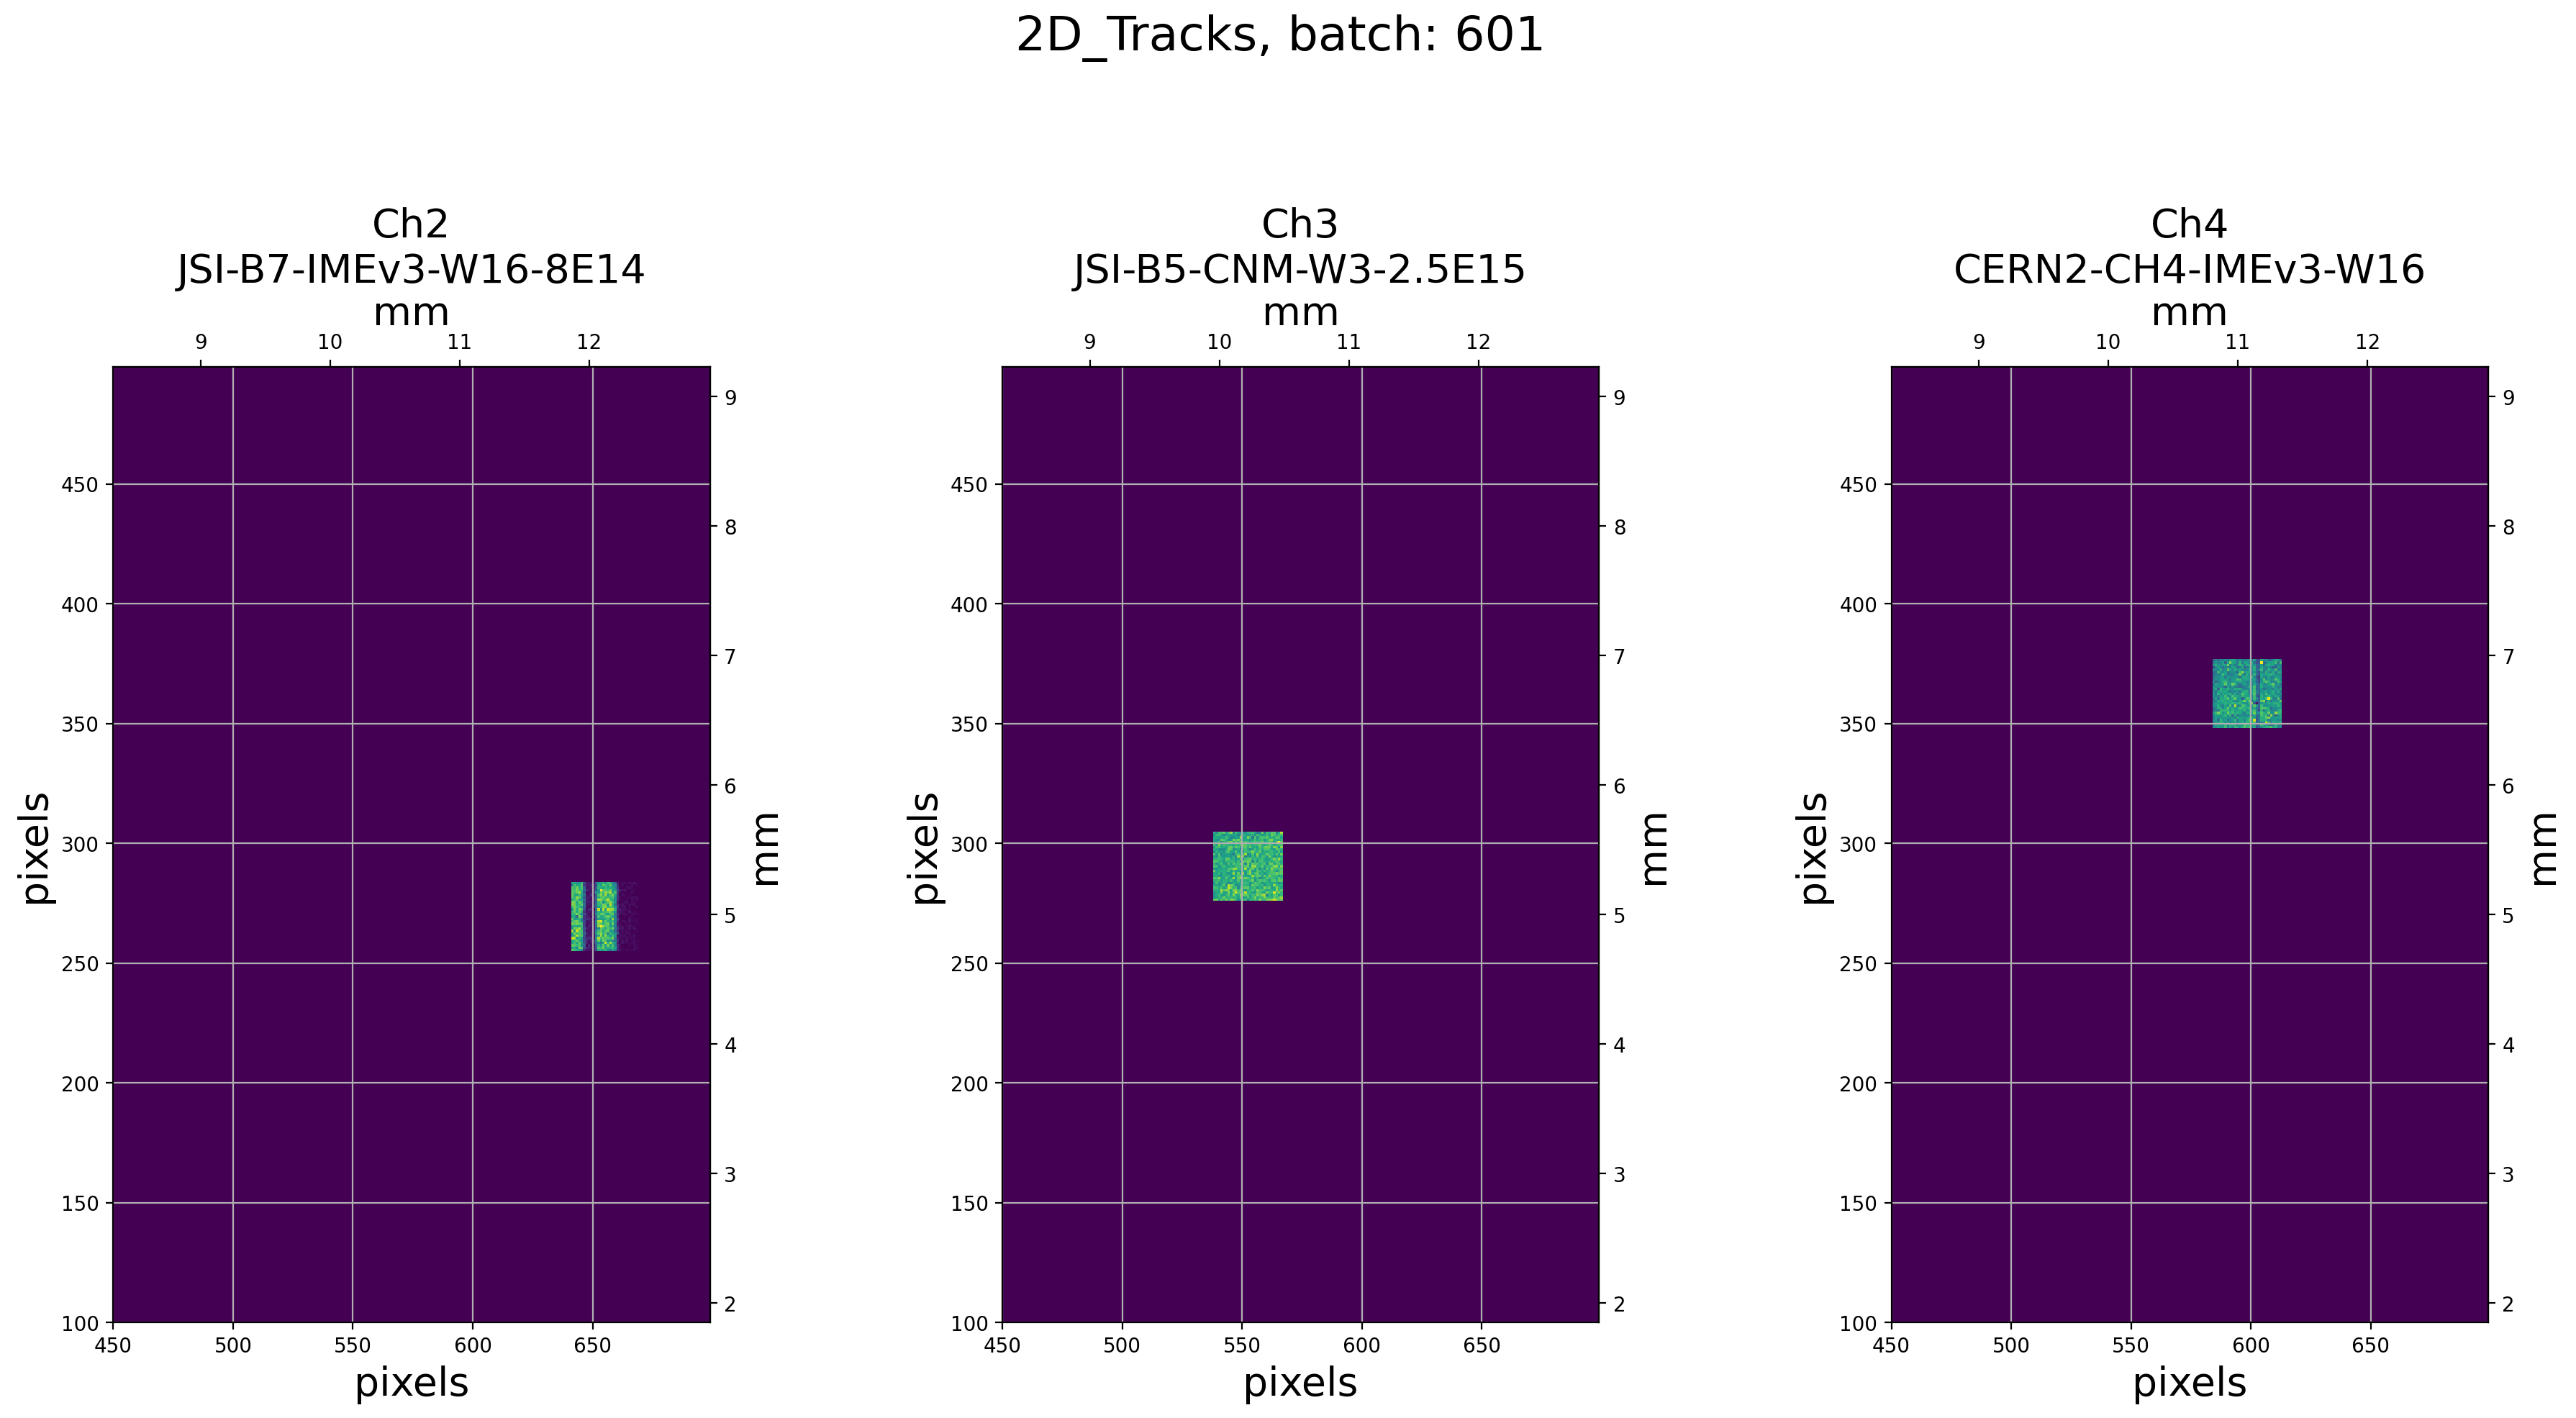

In [24]:
mask = [geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=i, only_center=True)[0] for i in range(1,4)]

fig,axes = plot(df[this_scope], "2D_Tracks", dict_of_batches[this_batch], this_scope, bins=bins, mask=mask)

[WARNING] - More than one minimum found at: [41.334976, 62.74684]


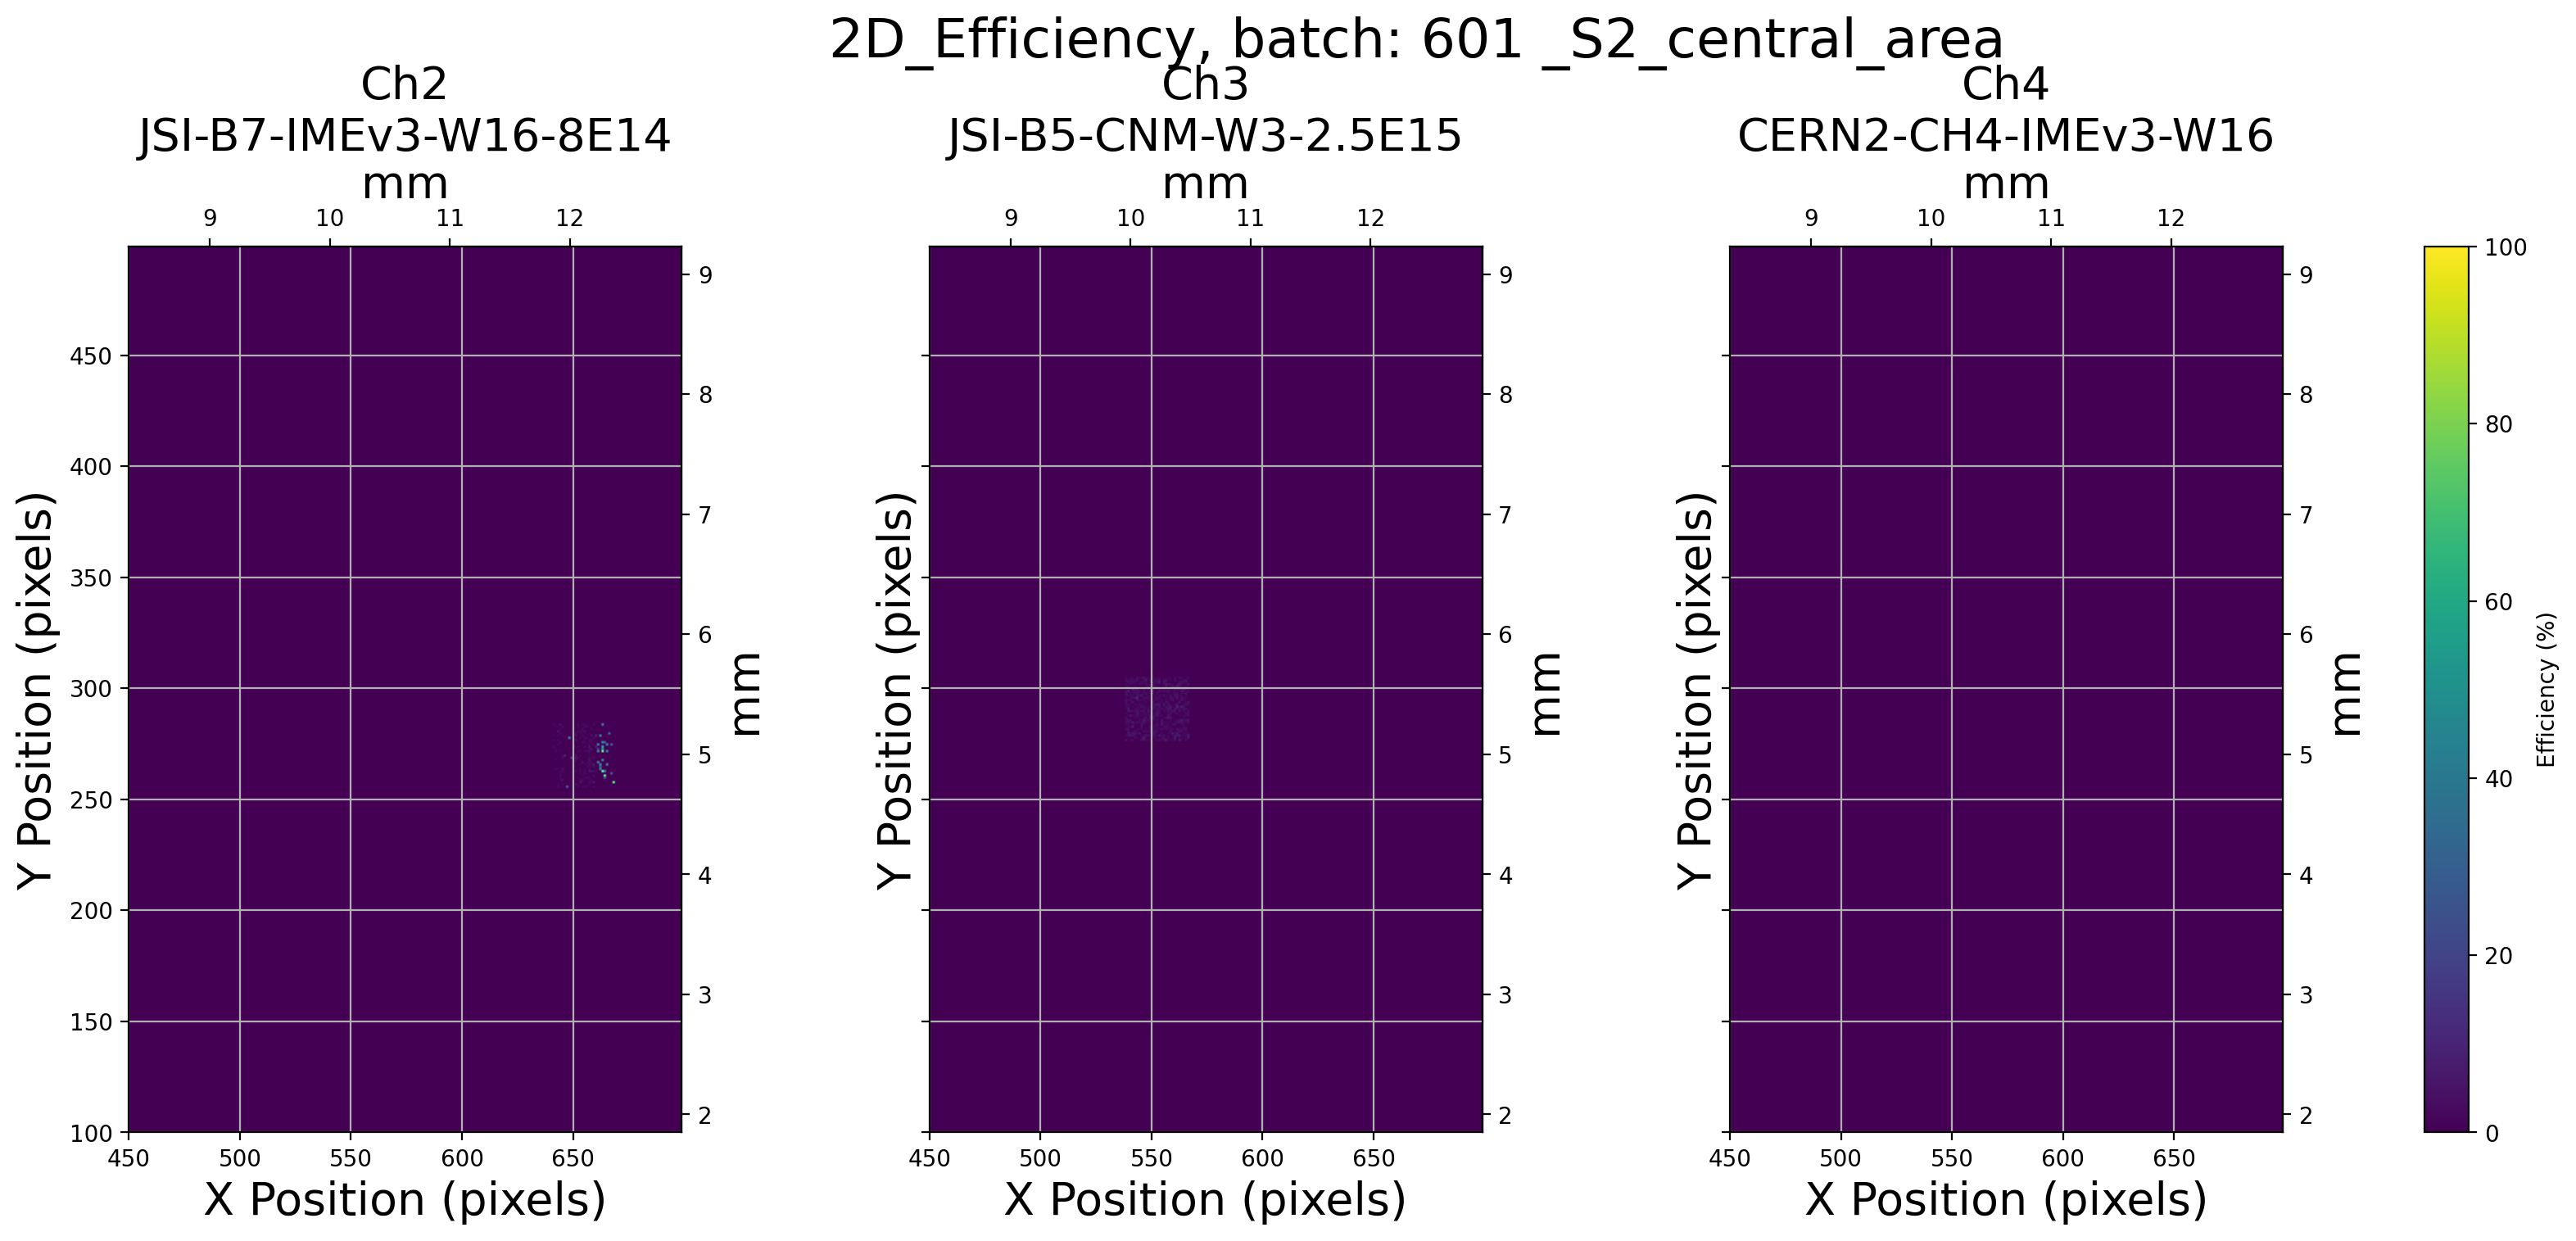

In [25]:
fig, axes = plot(df[this_scope],"2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, threshold_charge=threshold_charge,
                geometry_cut=True, only_center=True, savefig=False, savefig_details=f"_{this_scope}_central_area")
fig

In [26]:
# ### Efficiency in the central part WITHOUT pulseHeight cut
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
# # dut = 3

# efficiency_range = []
# error_range = []
# threshold_range = np.arange(0.5, 20, 0.5)
# geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut, only_center=True)[0]
# # pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
# for charge in threshold_range:
#     ### efficiency with error
#     efficiency_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[geometry]/transimpedance[dut-1], charge)[0])
#     error_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[geometry]/transimpedance[dut-1], charge)[1]) 

# fig, ax = plt.subplots(figsize=(10,6), dpi=150)
# ax.errorbar(threshold_range, efficiency_range, yerr=error_range, marker='.', markersize=3, linewidth=0,
#             elinewidth=1, ecolor='k',capsize=1.5,
#         label=f"Total tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
# ax.set_title(f"Total efficiency depending on threshold charge \n \
# on central surface ($0.5x0.5mm^2$) of Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch} \n \
# (no other cut)")
# ax.set_xlabel("Threshold charge (fC)")
# ax.set_ylabel("Total efficiency")
# ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
# ax.grid('--')
# ax.legend()
# # fig.savefig(f"../various plots/Total_efficiency_change_central_area_{this_batch}_{this_scope}_DUT{dut}_no_cut.svg")

## Comparing $\Delta$t with pulseHeight

In [27]:
mins

{'S1': [None, 12.155009, 12.294193, 14.153532],
 'S2': [None, 23.464828, 41.334976, 8.923115]}

In [28]:
# this_scope = "S2"
# dut = 2
# fig, ax = plt.subplots(figsize=(10,8), dpi=300)
# ax.plot(np.array(df[this_scope]["timeCFD50_0"]-df[this_scope][f"timeCFD50_{dut}"]),np.array(df[this_scope][f"pulseHeight_{dut}"]),'x', markersize=.5)
# ax.axhline(mins[this_scope][dut],color='r',label="pulseHeight_cut, min: %.2f"%mins[this_scope][dut])
# ax.legend()
# ax.grid('--')

In [29]:
# this_scope = "S2"
# dut = 2
# fig, ax = plt.subplots(figsize=(10,8), dpi=300)
# ax.plot(np.array(df[this_scope]["timeCFD50_0"]-df[this_scope][f"timeCFD50_{dut}"]),np.array(df[this_scope][f"charge_{dut}"])/transimpedance[dut-1],'x', markersize=.5)
# ax.grid('--')

In [30]:
# this_scope = "S1"
# fig, ax = plt.subplots(figsize=(10,8), dpi=300)

# for dut in range(1,4):
# # dut = 1
#     ax.plot(np.array(df[this_scope][f"pulseHeight_{dut}"]),np.array(df[this_scope][f"charge_{dut}"])/transimpedance[dut-1],'x', markersize=.5)
#     ax.grid('--')

In [31]:
# # _,hist_bins,_,fig,ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(time_cut)])
# _,_,_,fig,ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(pulse_cut)],bins=hist_bins)#, fig_ax=(fig,ax))
# ax.semilogy() 
# fig

## Ratio plots

Text(0.5, 1.15, 'Time difference with ratio plot when pulseHeight cut is applied \n Batch: 601, Oscilloscope: S2')

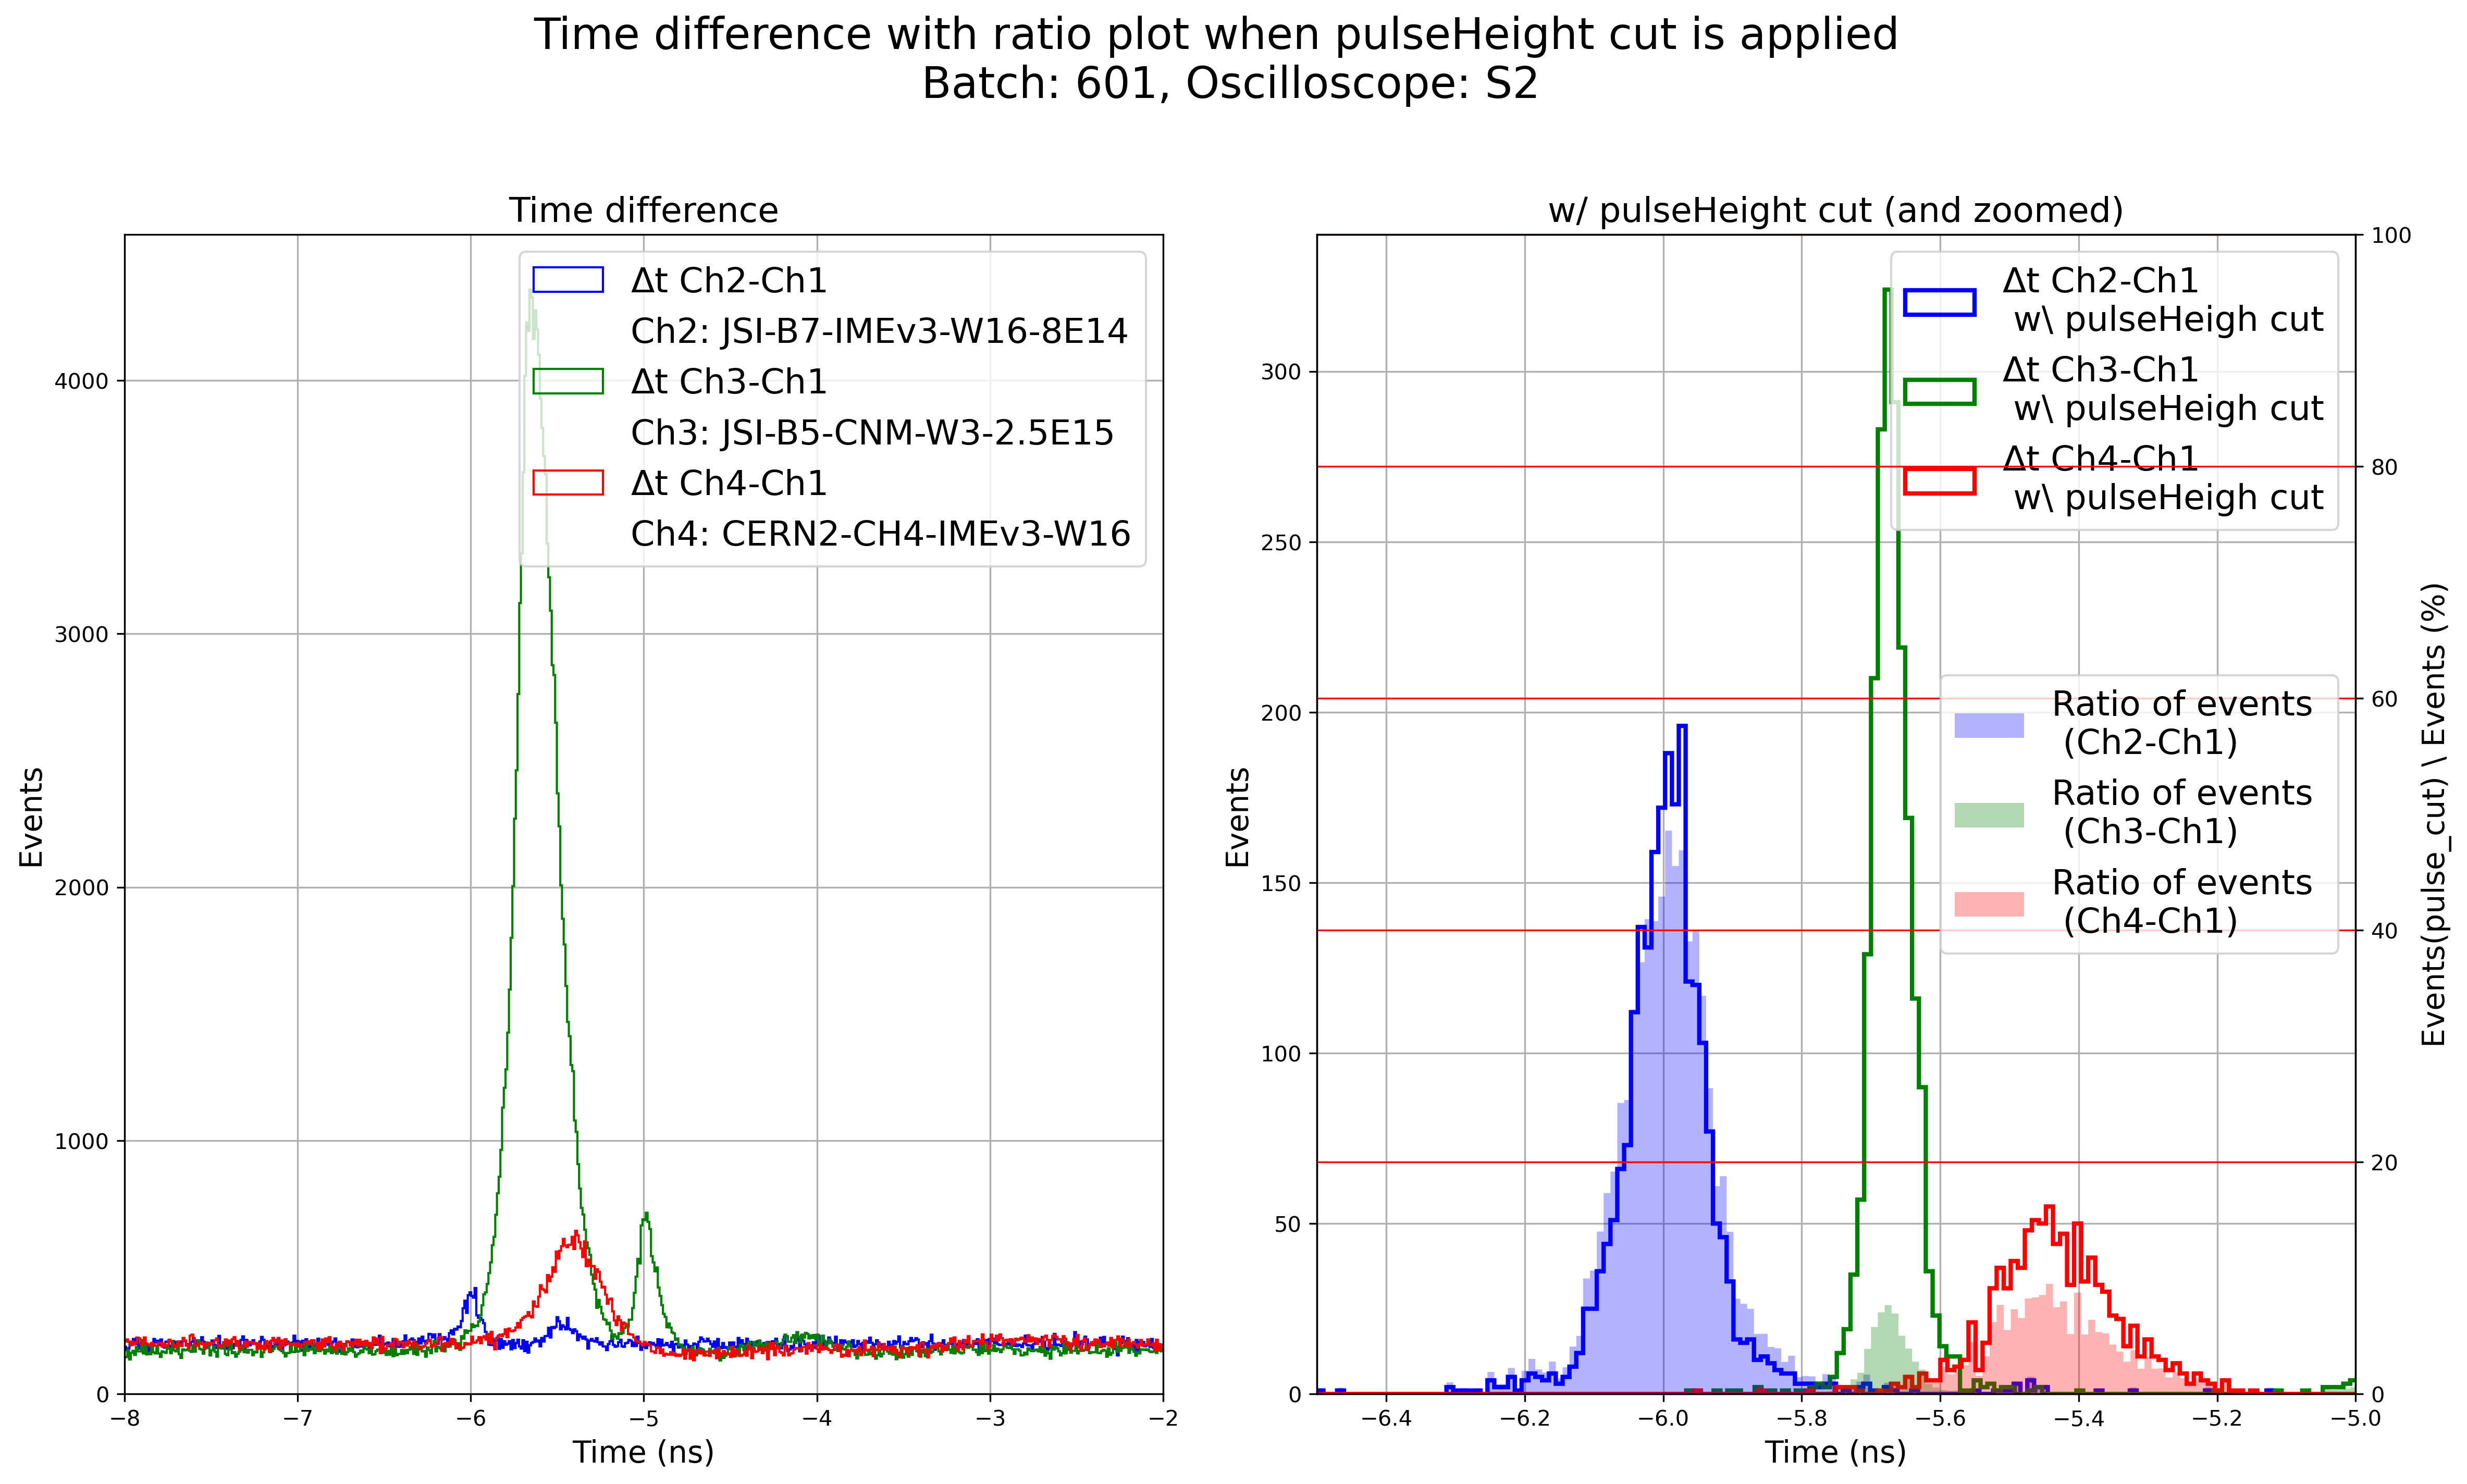

In [32]:
### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT
# this_scope = "S2"

colormap = ['k','b','g','r']

fig, axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2, dpi=300)
fig.tight_layout(w_pad=4, h_pad=4)
ax2 = axes[1].twinx() 
ax2.grid('-', axis='y', color='r')

for dut in range(1,4):
    pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
    hist, my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=10000, label=f"$\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[0]), color=colormap[dut]) ### MCP - CERN1
    axes[0].plot([],[],' ',label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, bins=my_bins, label=f"$\Delta$t Ch{dut+1}-Ch1 \n w\ pulseHeigh cut", fig_ax=(fig,axes[1]), linewidth=2, color=colormap[dut])  ### MCP - CERN3
#     time_peak,_ = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10)
    ratio = np.divide(hist_pulse_cut, hist, where = hist!=0)
#     axes[0].stairs(ratio*100, my_bins, alpha=0.5, label='Filtered Ratio', color=colormap[dut])
    ax2.stairs(ratio*100, my_bins, alpha=0.3, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut], fill=True)


axes[0].set_title(f"Time difference", fontsize=16)
axes[0].set_xlabel("Time (ns)", fontsize=14)
axes[0].set_ylabel("Events", fontsize=14)
axes[0].set_xlim(-8,-2)
# axes[0].semilogy()

axes[1].set_title("w/ pulseHeight cut (and zoomed)", fontsize=16)
axes[1].set_xlabel("Time (ns)", fontsize=14)
axes[1].set_ylabel("Events", fontsize=14)
axes[1].set_xlim(-6.5,-5)

ax2.set_ylabel("Events(pulse_cut) \ Events (%)", fontsize=14)
ax2.set_ylim(0,100)
ax2.tick_params

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)
ax2.legend(fontsize=16, loc='right')
fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1.15, fontsize=20)
# fig.savefig(f"../various plots/time_difference{this_batch}_{this_scope}_all_DUTs_with_ratio_plot.svg",bbox_inches='tight')

### New ratio plot
 I apply a pulseHeight cut and then I use __find_peaks__ to find the peaks

In [33]:
# ### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT

# # this_scope = "S2"

# colormap = ['k','b','g','r']
# spec = {'height_ratios':[4,4,1], 'hspace':0.2}   # gridspec keywords arguments
# fig, axes = plt.subplots(figsize=(12,15),nrows=3, ncols=1, gridspec_kw=spec, sharex=True, dpi=300)

# # all_time_cut1 = [None]

# for dut in range(1,4):
#     hist, my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"]),
#                                          bins=10000, fig_ax=(fig,axes[1]), color=colormap[dut], linewidth=0) #,label=f"$\Delta$t Ch{dut+1}-Ch1",) ### MCP - CERN1
#     axes[0].plot([],[],' ',label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
#     if mins[this_scope][dut]:
#         pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
#         hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut]),
#                                                 poisson_err=True, error_band=True, bins=my_bins, color=colormap[dut],
#                                                 fig_ax=(fig,axes[0]), label=f"$\Delta$t Ch{dut+1}-Ch1 \n w/ pulseHeigh cut")  ### MCP - CERN3
#         peaks, info_peaks = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10)
#     else:
#         print(f"DUT: {dut} Try without pulseheight cut")
#         peaks, info_peaks = find_peaks(hist, prominence=np.max(hist)/10)
        
#     left_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])>my_bins[info_peaks['left_bases'][0]]
#     right_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])<my_bins[info_peaks['right_bases'][0]]
# #     all_time_cut1.insert(dut, np.logical_and(left_cut, right_cut))
#     time_cut = np.logical_and(left_cut, right_cut)
#     hist_time_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[time_cut]-df[this_scope]["timeCFD50_0"].loc[time_cut]),
#                                            poisson_err=True, error_band=True, bins=my_bins, linewidth=1, color=colormap[dut],
#                                            fig_ax=(fig,axes[1]), label=f"$\Delta$t Ch{dut+1}-Ch1 \n w/ time cut")  ### MCP - CERN3
#     ratio = np.divide(hist_pulse_cut, hist_time_cut, where = hist_time_cut!=0)
#     axes[2].stairs(ratio, my_bins, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut])#, fill=True)

    
# axes[0].set_title(f"Time difference", fontsize=16)
# axes[0].set_ylabel("Events", fontsize=14)
# # axes[0].set_xlim(-7,-5)
# axes[0].set_xlim(-7e3,-4e3)
# # axes[0].semilogy()

# axes[2].set_ylabel("Ratio of events", fontsize=14)
# axes[2].set_xlabel("Time (ps)", fontsize=14)

# axes[2].set_title("Events(pulse_cut) / Events(time_cut) in each bin", fontsize=16)

# axes[0].legend(fontsize=16)
# axes[1].legend(fontsize=16)
# axes[2].grid('-')

# fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
# \n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)
# # fig.savefig(f"../various plots/time_difference_pulseheight_cut_time_cut_{this_batch}_{this_scope}_all_DUTs_with_ratio_plot.svg",bbox_inches='tight')

### Try to define the time cut without other info. And fitting the gaussian + background
i.e. when pulseHeight cut (and so geometry cut) are not available

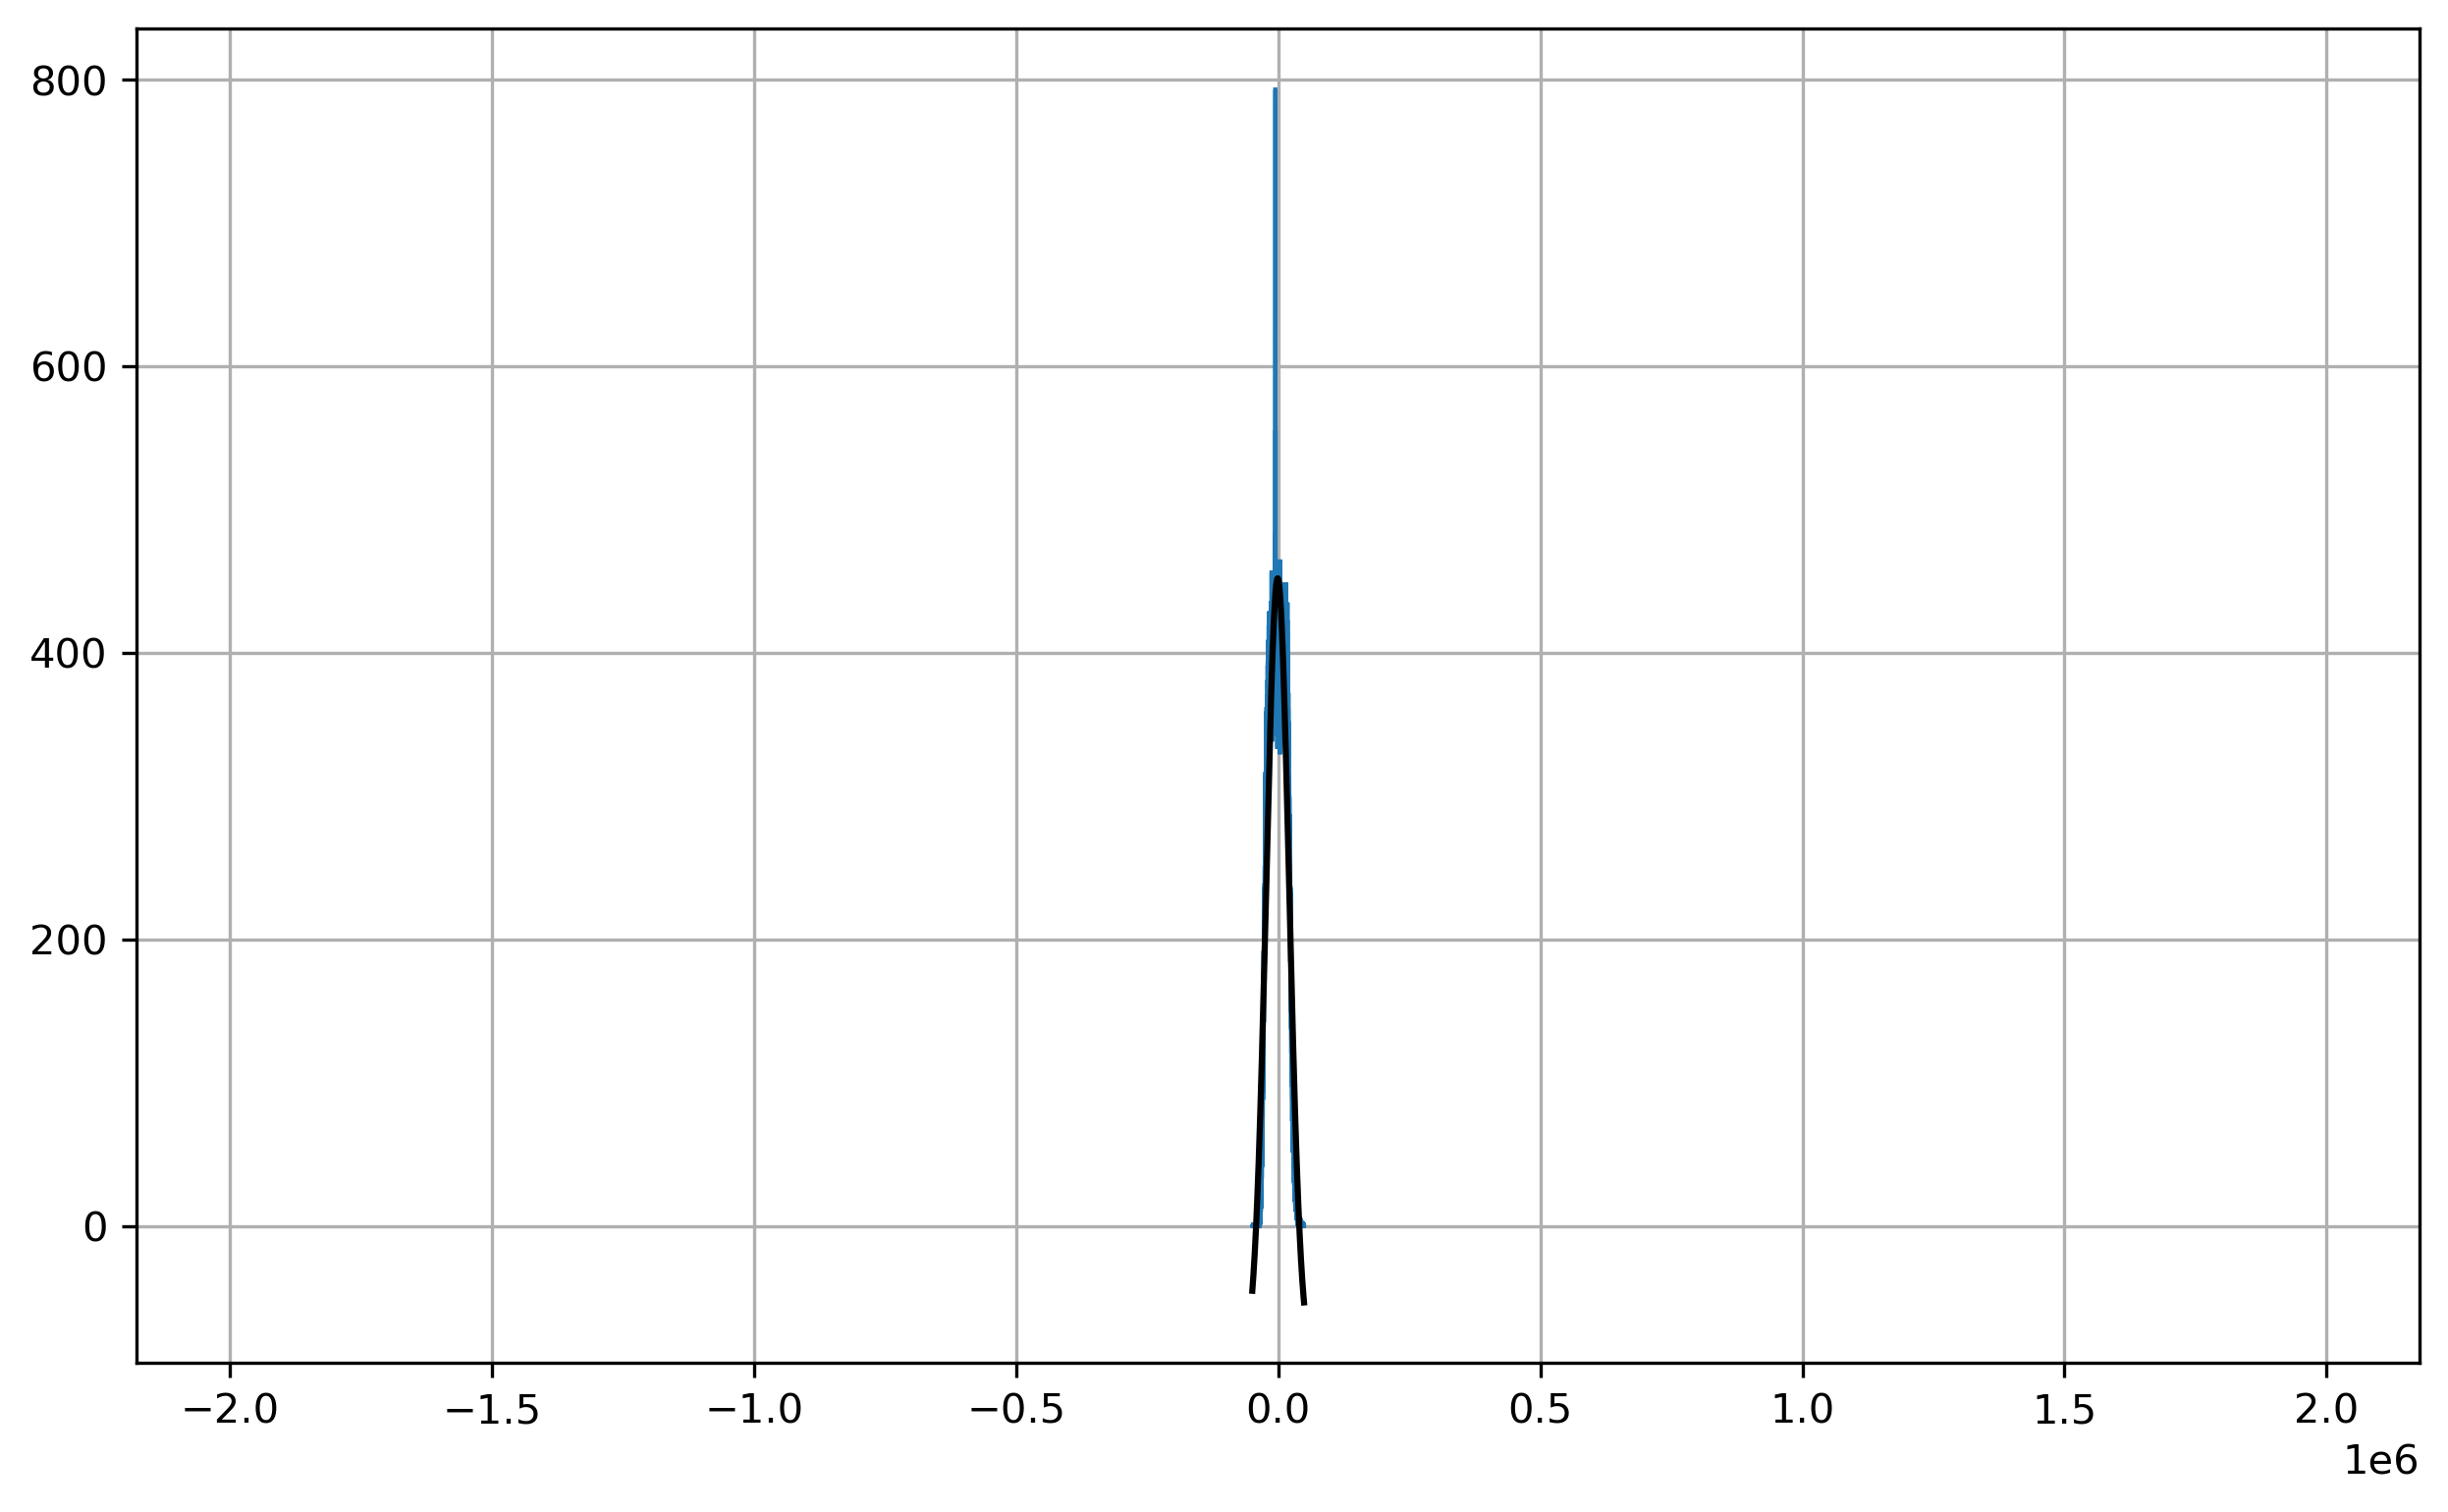

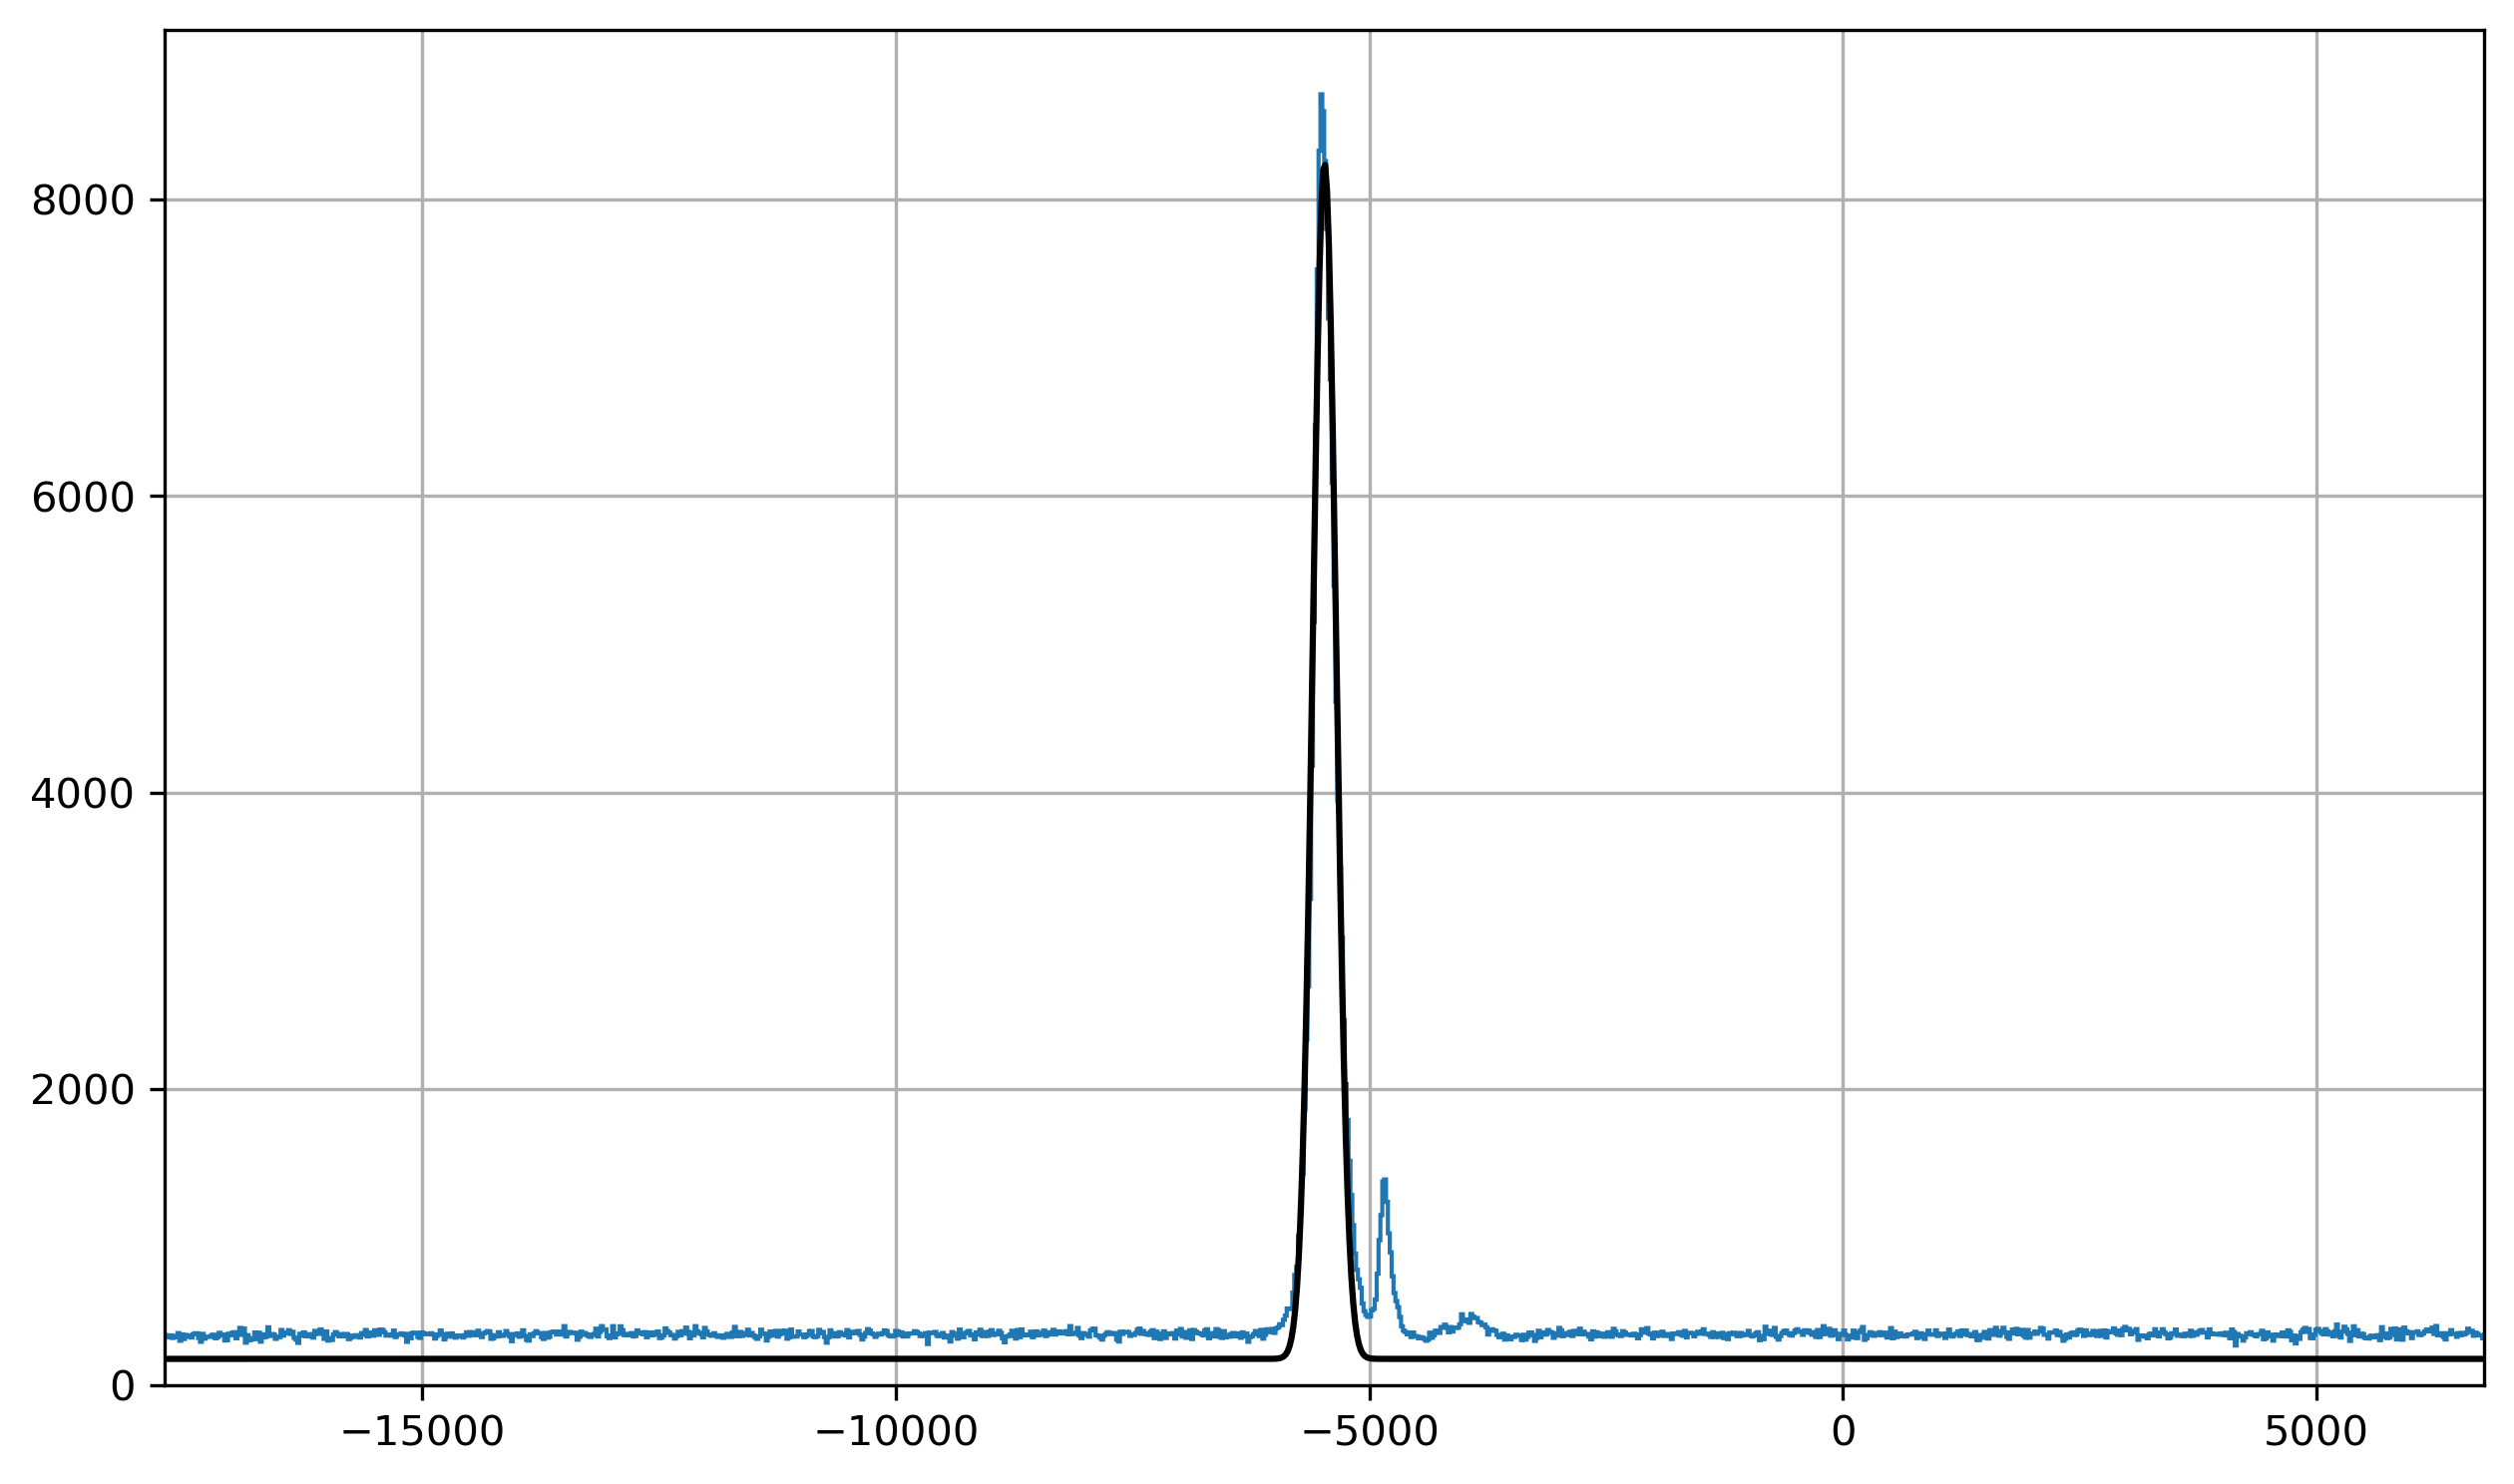

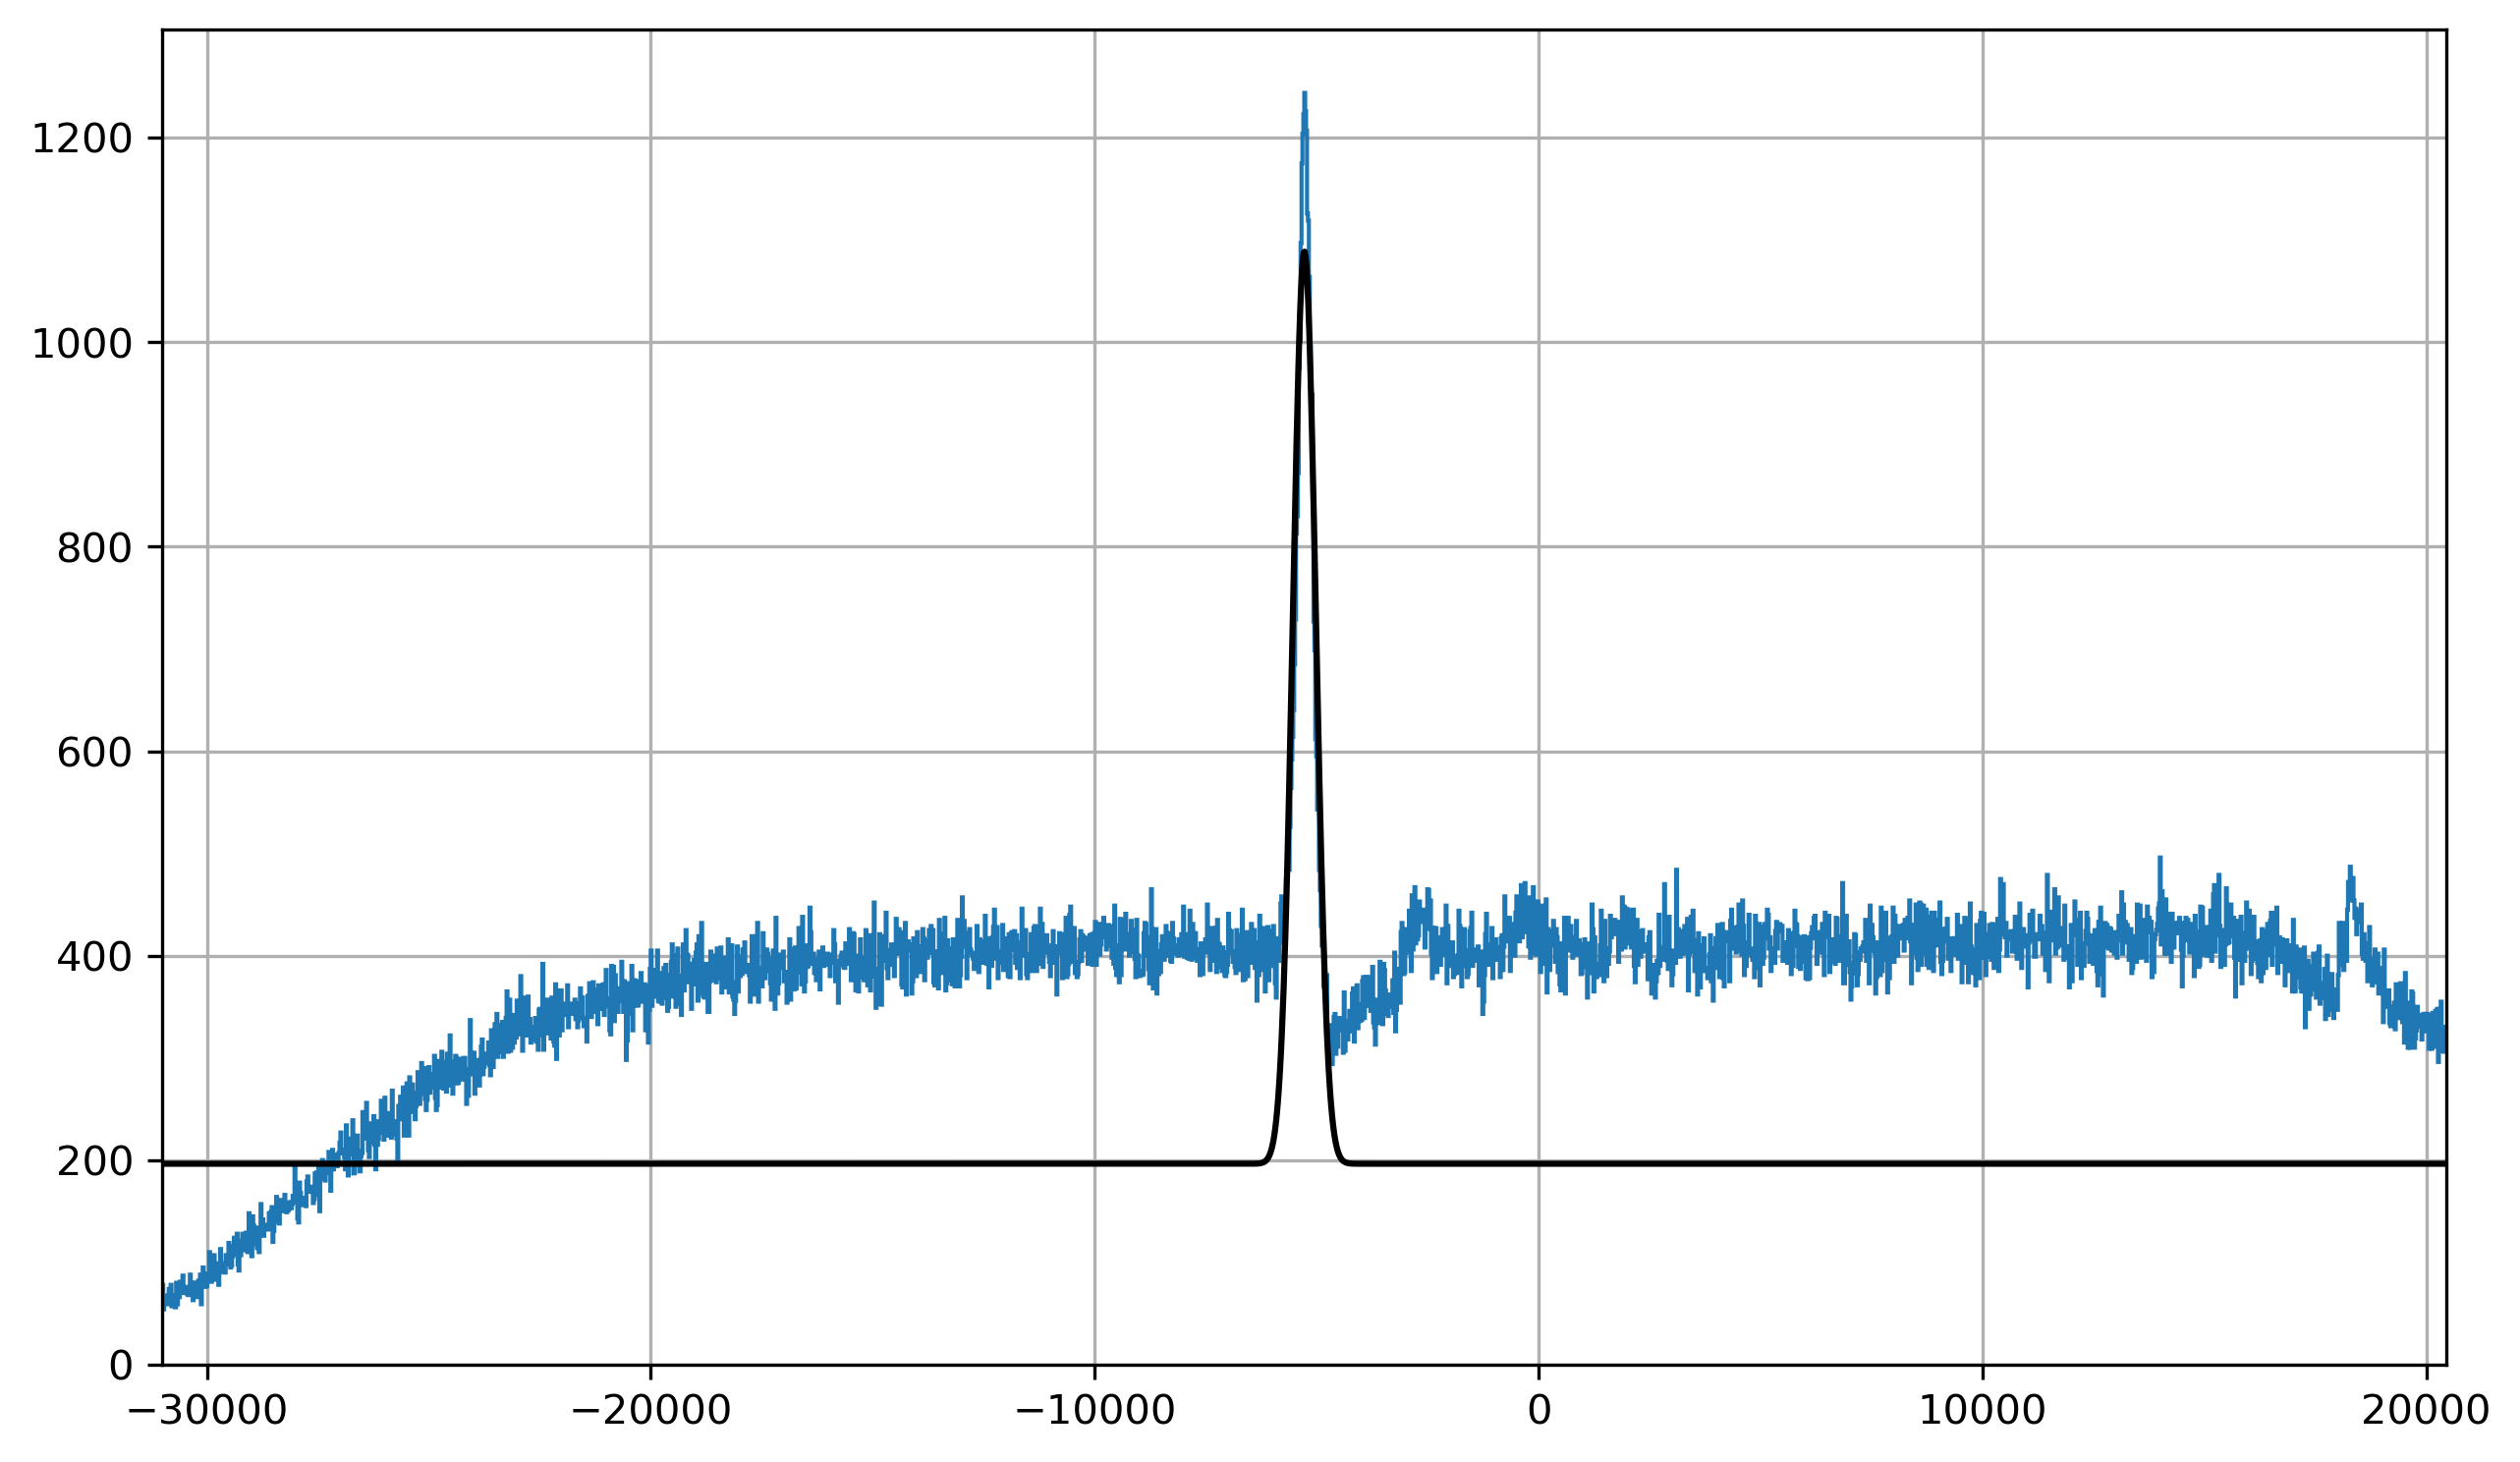

In [31]:
all_time_cut = [time_mask(df[this_scope], bins=5000, DUT_number=i, plot=True)[0] for i in [1,2,3]]

In [35]:
# ### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT
# # this_scope = "S2"

# colormap = ['k','b','g','r']
# spec = {'height_ratios':[4,4,1], 'hspace':0.2}   # gridspec keywords arguments

# fig, axes = plt.subplots(figsize=(12,15),nrows=3, ncols=1, gridspec_kw=spec, sharex=True, dpi=300)

# for dut in [1,2]:
#     hist, my_bins,_,_,_ = plot_histogram(df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"],
#                                          bins=10000, color=colormap[dut], linewidth=1,
#                                          fig_ax=(fig,axes[0]))
    
#     axes[0].plot([],[],' ',label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
#     initial_param = (np.max(hist),-5e3,100,100)
#     bins_centers = (my_bins[:-1]+my_bins[1:])/2
#     param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)
#     print(f"Fit parameters: {param}")
#     axes[0].plot(bins_centers, my_gauss(bins_centers,*param), color='k')
#     number_of_sigmas = 5
#     left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
#     axes[0].axvline(left_base, color=colormap[dut])
#     axes[0].axvline(right_base, color=colormap[dut])
#     left_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"])>left_base
#     right_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"])<right_base
#     time_cut = np.logical_and(left_cut, right_cut)
#     hist_time_cut,_,_,_,_ = plot_histogram(df[this_scope][f"timeCFD50_{dut}"].loc[time_cut]-df[this_scope]["timeCFD20_0"].loc[time_cut],
#                                            poisson_err=True, error_band=True, bins=my_bins, linewidth=1, color=colormap[dut],
#                                            fig_ax=(fig,axes[1]), label=f"$\Delta$t Ch{dut+1}-Ch1 \n w/ time cut")  ### MCP - CERN3

#     ratio = np.divide(hist_time_cut, hist, where = hist_time_cut!=0)
#     axes[2].stairs(ratio, my_bins, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut])#, fill=True)

    
# axes[0].set_title(f"Time difference", fontsize=16)
# axes[0].set_ylabel("Events", fontsize=14)
# axes[0].set_xlim(-6e3,-5e3)
# axes[1].set_xlim(-6e3,-5e3)

# axes[2].set_ylabel("Ratio of events", fontsize=14)
# axes[2].set_xlabel("Time (ns)", fontsize=14)
# axes[2].set_title("Events(time_cut) / Events(no_cut)", fontsize=16)

# axes[0].legend(fontsize=16)
# axes[1].legend(fontsize=16)
# axes[2].grid('-')

# fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
# \n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)

Fit parameters: [10537.20610693 -5372.26790873    60.22670851    52.1181755 ]
Fit parameters: [11419.1929377  -5661.24248225    63.02378285    50.04562691]
Fit parameters: [ 6544.98819135 -5471.70310402   -84.02617839    55.06938725]


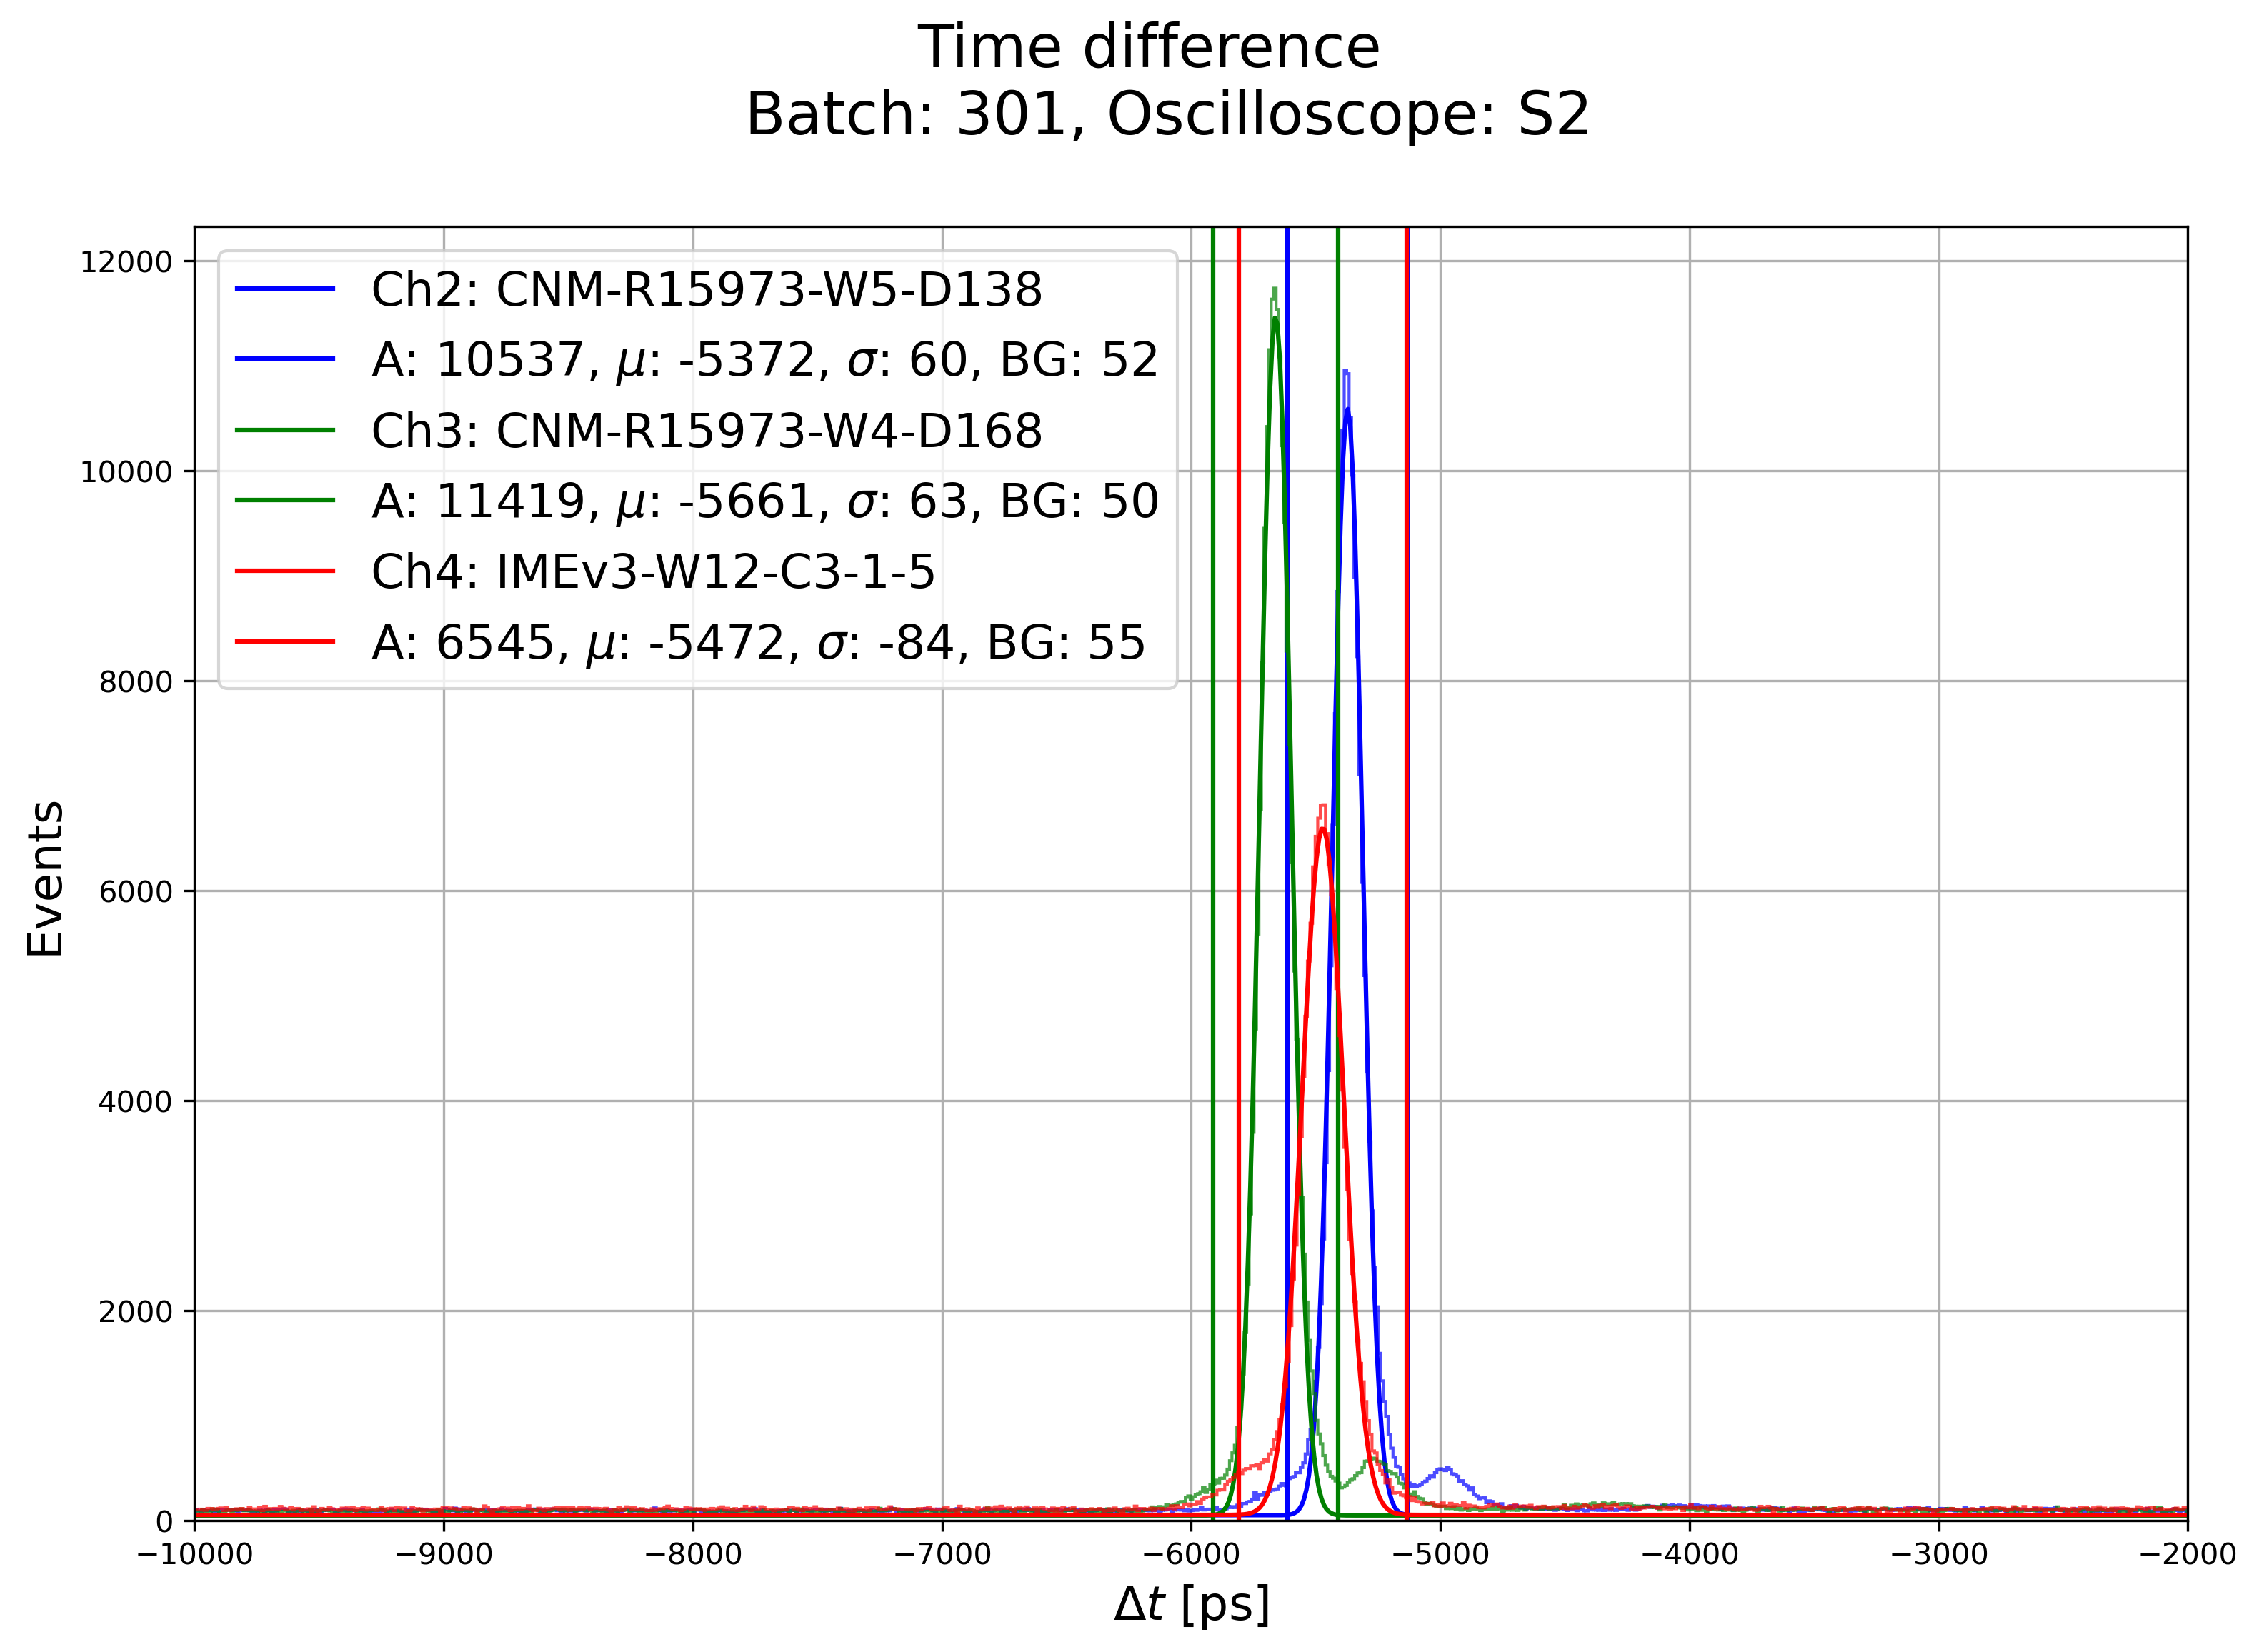

In [17]:
### SAME THING BUT ONLY FIRST PLOT
colormap = ['k','b','g','r']

fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, sharex=True, dpi=300)

for dut in [1,2,3]:
    hist, my_bins,_,_,_ = plot_histogram(df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"],
                                         bins=10000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))
    initial_param = (np.max(hist),-5e3,100,100)
    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)
    print(f"Fit parameters: {param}")
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut],
              label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
    number_of_sigmas = 4
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes.axvline(left_base, color=colormap[dut])
    axes.axvline(right_base, color=colormap[dut])

    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.0f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals
    
axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)
axes.set_xlim(-10e3,-2e3)

axes.legend(fontsize=16)

fig.suptitle(f"Time difference \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)
fig.savefig(f"../various plots/time_difference_{this_batch}_{this_scope}_small_range_with_fit.svg")

Text(0.5, 1, 'Time difference \n Batch: 601, Oscilloscope: S2')

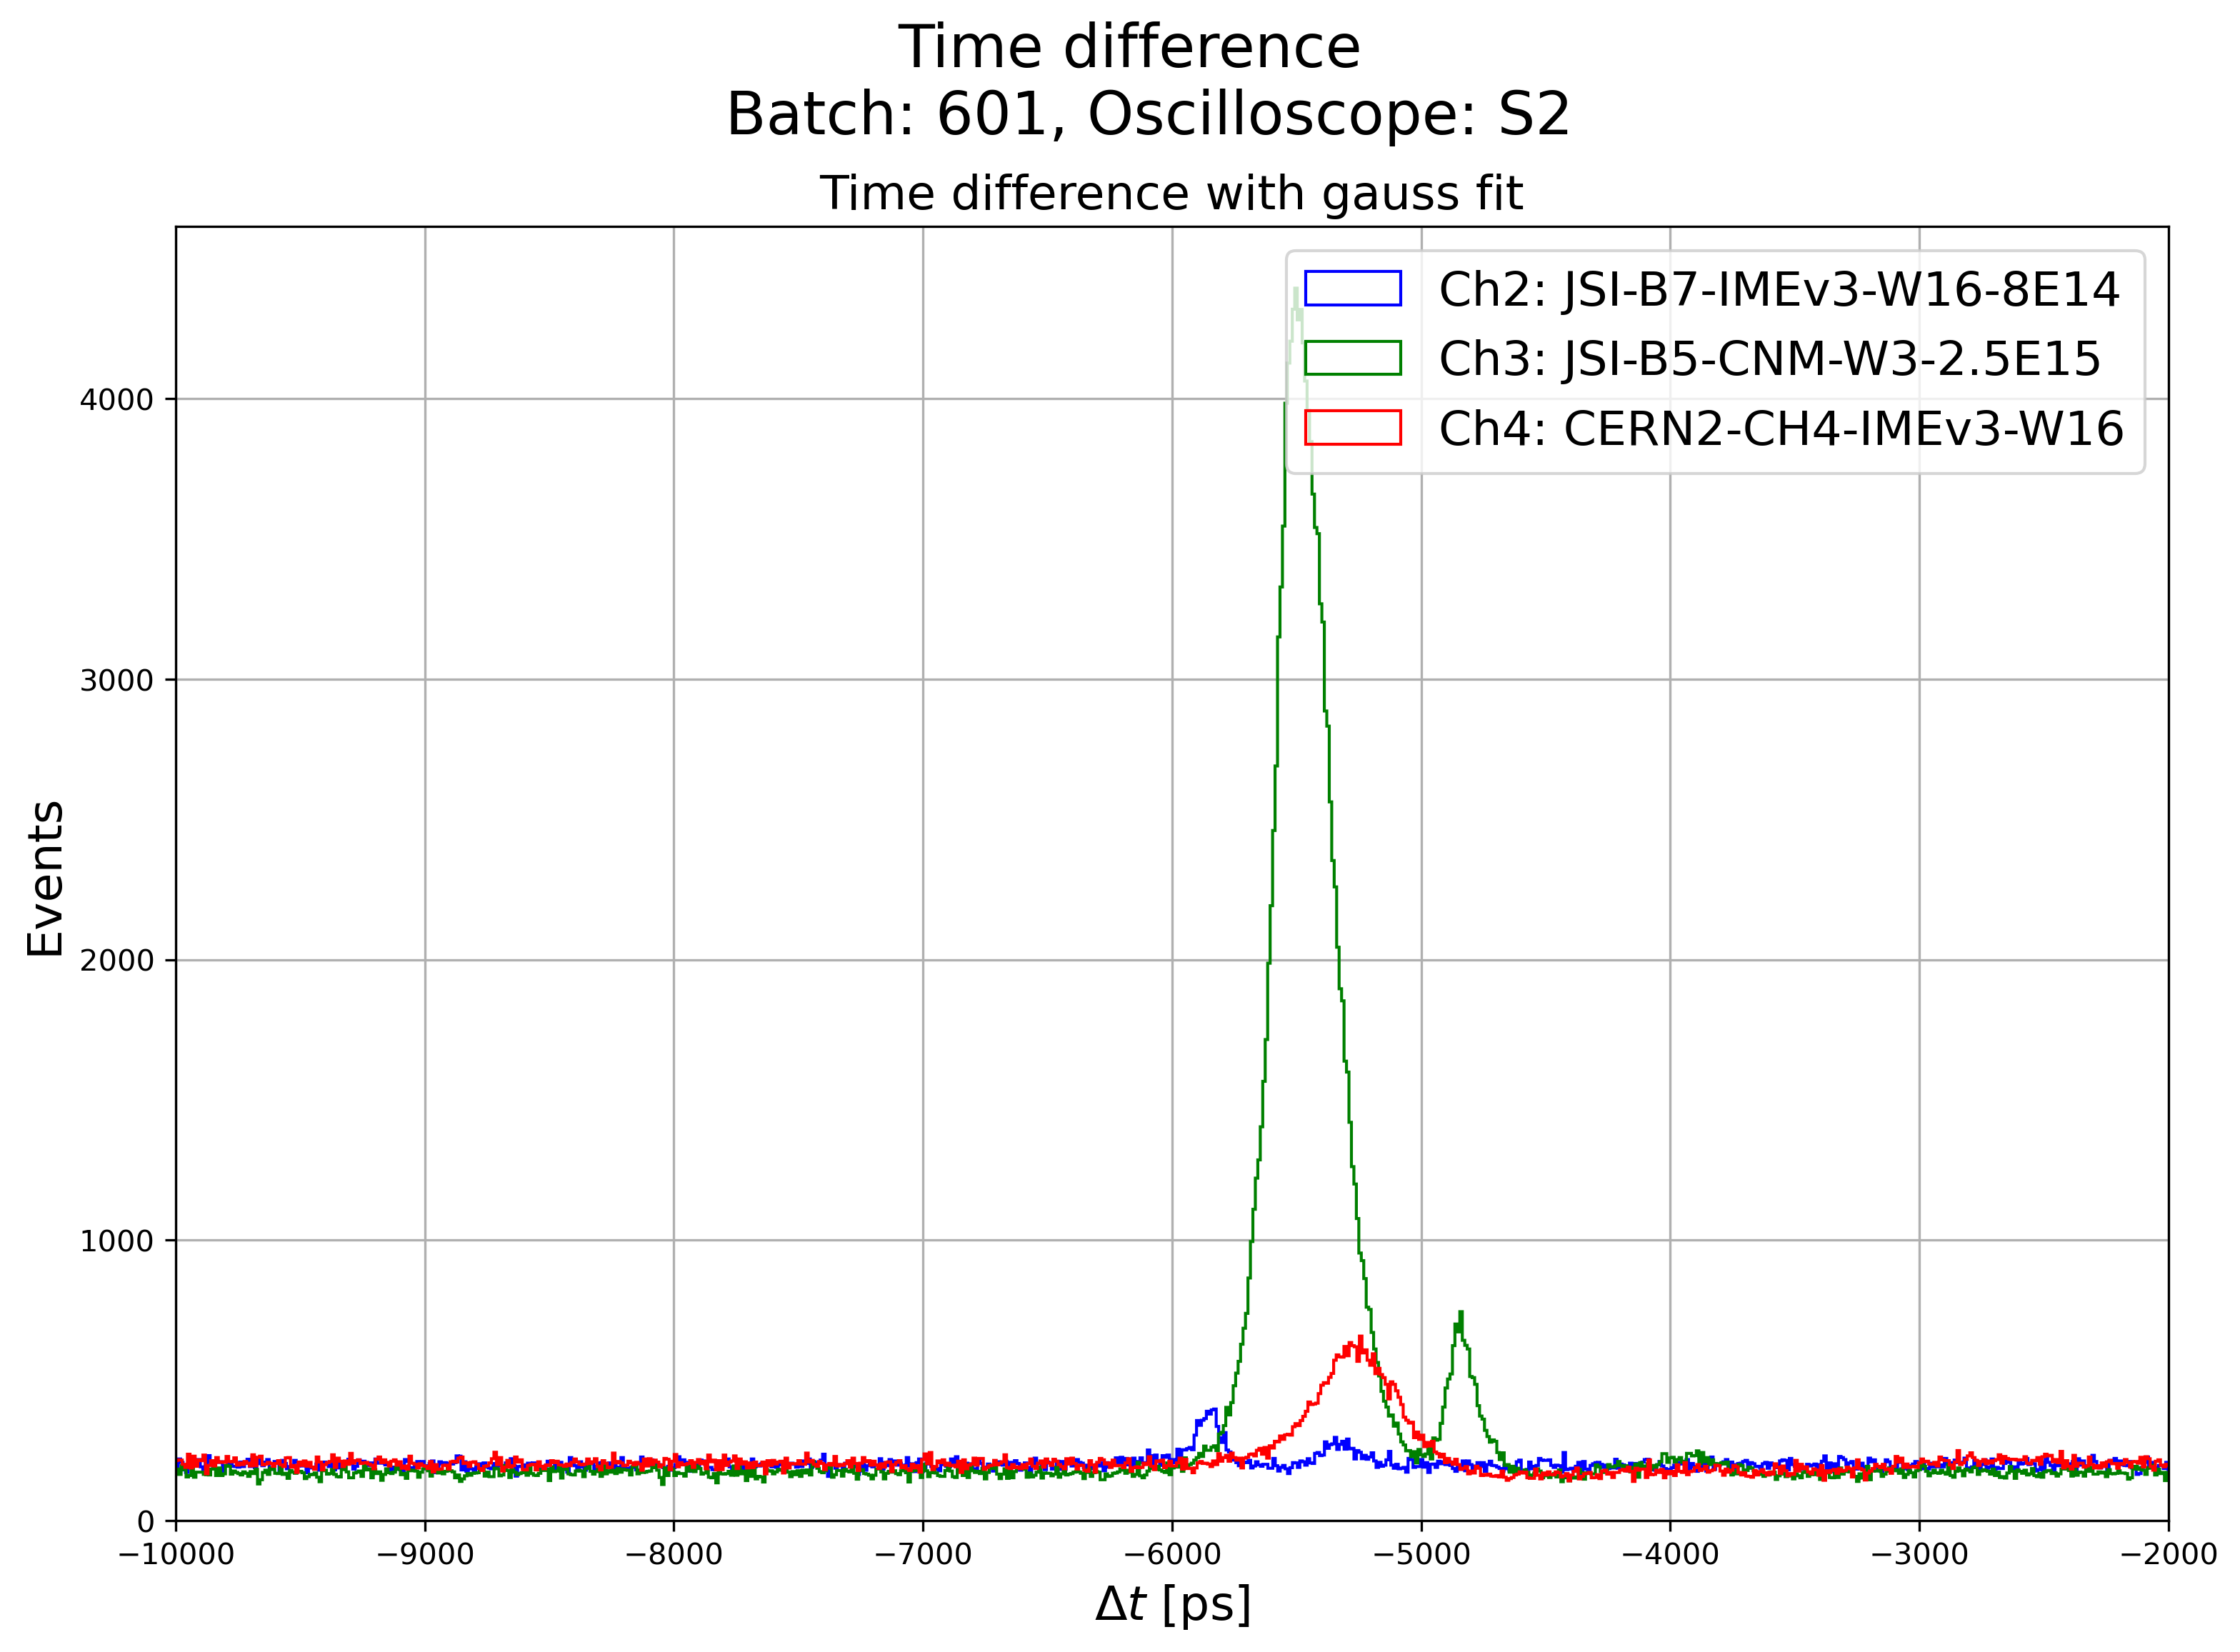

In [32]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, sharex=True, dpi=300)

for dut in [1,2,3]:
    hist, my_bins,_,_,_ = plot_histogram(df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"],
                                         bins=10000, color=colormap[dut], linewidth=1, label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}",
                                         fig_ax=(fig,axes))
    
    
axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_title(f"Time difference with gauss fit", fontsize=16)
axes.set_ylabel("Events", fontsize=16)
axes.set_xlim(-10e3,-2e3)

axes.legend(fontsize=16)

fig.suptitle(f"Time difference \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)

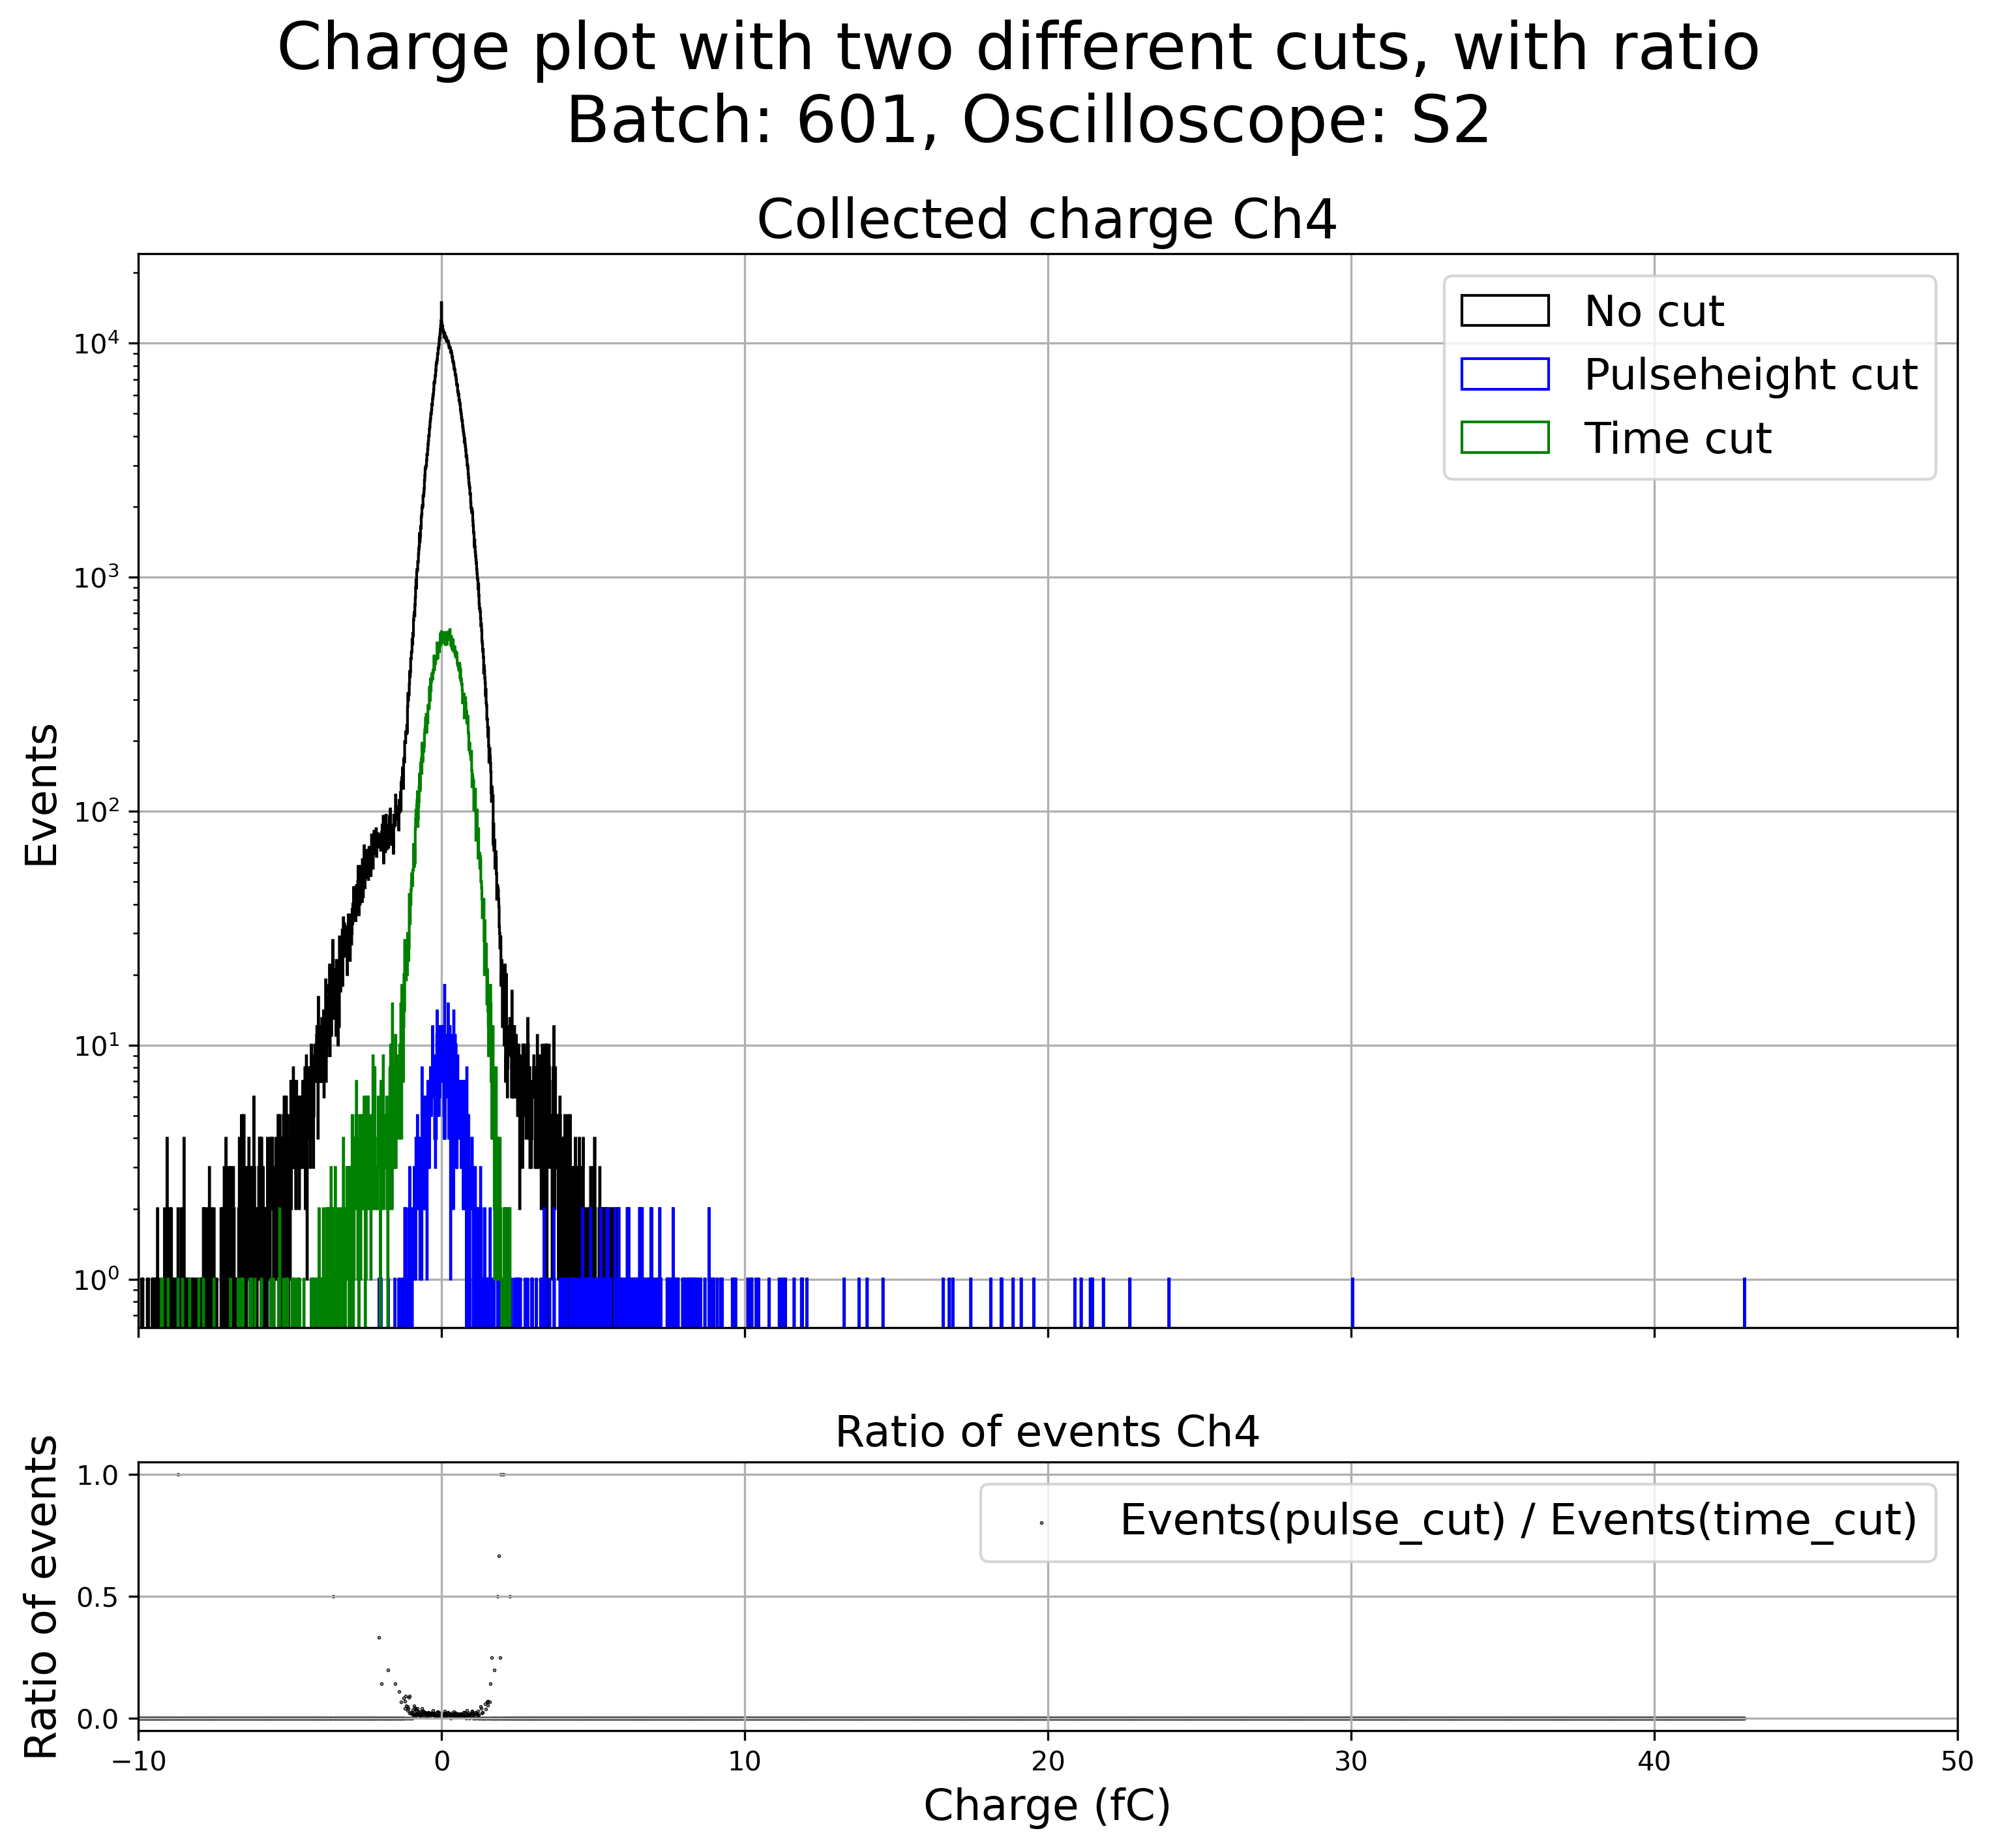

In [51]:
### THIS TIME I'M PLOTTING THE CHARGE INSTEAD OF TIME
# this_scope = "S2"
# transimpedance = get_transimpedance(this_batch,this_scope)
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in (1,2,3)]

# colormap = ['k','b','g','r']
spec = {'height_ratios':[4,1], 'hspace':0.2}   # gridspec keywords arguments

fig, axes = plt.subplots(figsize=(12,10),nrows=2, ncols=1, gridspec_kw=spec, sharex=True, dpi=300)

# for dut in [1,2]:
dut = 3
hist, bins_charge,_,_,_ = plot_histogram(df[this_scope][f"charge_{dut}"]/transimpedance[dut-1],
                                       bins='auto', linewidth=1, alpha=1, color='k',
                                       fig_ax=(fig,axes[0]), label=f"No cut")  ### MCP - CERN3

pulseheight_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
hist_pulse_cut,_,_,_,_ = plot_histogram(df[this_scope][f"charge_{dut}"].loc[pulseheight_cut]/transimpedance[dut-1],
                                        bins=bins_charge, alpha=1, color=colormap[1],
                                        fig_ax=(fig,axes[0]), label=f"Pulseheight cut")

time_cut = time_mask(df[this_scope], DUT_number=dut, bins=10000, plot=False)[0]
hist_time_cut,_,_,_,_ = plot_histogram(df[this_scope][f"charge_{dut}"].loc[time_cut]/transimpedance[dut-1],
                                       bins=bins_charge, alpha=1, color=colormap[2],
                                   fig_ax=(fig,axes[0]), label=f"Time cut")

ratio = np.divide(hist_pulse_cut, hist_time_cut, where = hist_time_cut!=0)
axes[1].scatter((bins_charge[1:]+bins_charge[:-1])/2, ratio, .1, label=f"Events(pulse_cut) / Events(time_cut)",
                color='k', )#, fill=True)

# ratio1 = np.divide(hist_pulse_cut, hist, where = hist!=0)
# axes[1].scatter((bins_charge[1:]+bins_charge[:-1])/2, ratio1, .1, label=f"Events(pulse_cut) / Events(total)",
#                 color=colormap[1], )#, fill=True)

# ratio2 = np.divide(hist_time_cut, hist, where = hist!=0)
# axes[1].scatter((bins_charge[1:]+bins_charge[:-1])/2, ratio2, .1, label=f"Events(time_cut) / Events(total)",
#                 color=colormap[2], )#, fill=True)

    
axes[0].set_title(f"Collected charge Ch{dut+1}", fontsize=20)
axes[0].set_ylabel("Events", fontsize=16)
axes[0].set_xlim(-10, 50)
axes[0].semilogy()

# axes[1].semilogy()
# axes[1].set_xlim(-6e3,-5e3)
# axes[1].semilogy()
axes[1].grid('-')
axes[1].set_ylabel("Ratio of events", fontsize=16)
axes[1].set_xlabel("Charge (fC)", fontsize=16)
axes[1].set_title(f"Ratio of events Ch{dut+1}", fontsize=16)

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)

fig.suptitle(f"Charge plot with two different cuts, with ratio\
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=24)
# fig.savefig(f"../various plots/charge_plot_with_two_different_cuts_ratio_plot_batch_{this_batch}_{this_scope}_ch{dut+1}.svg")

In [20]:
this_scope

'S2'

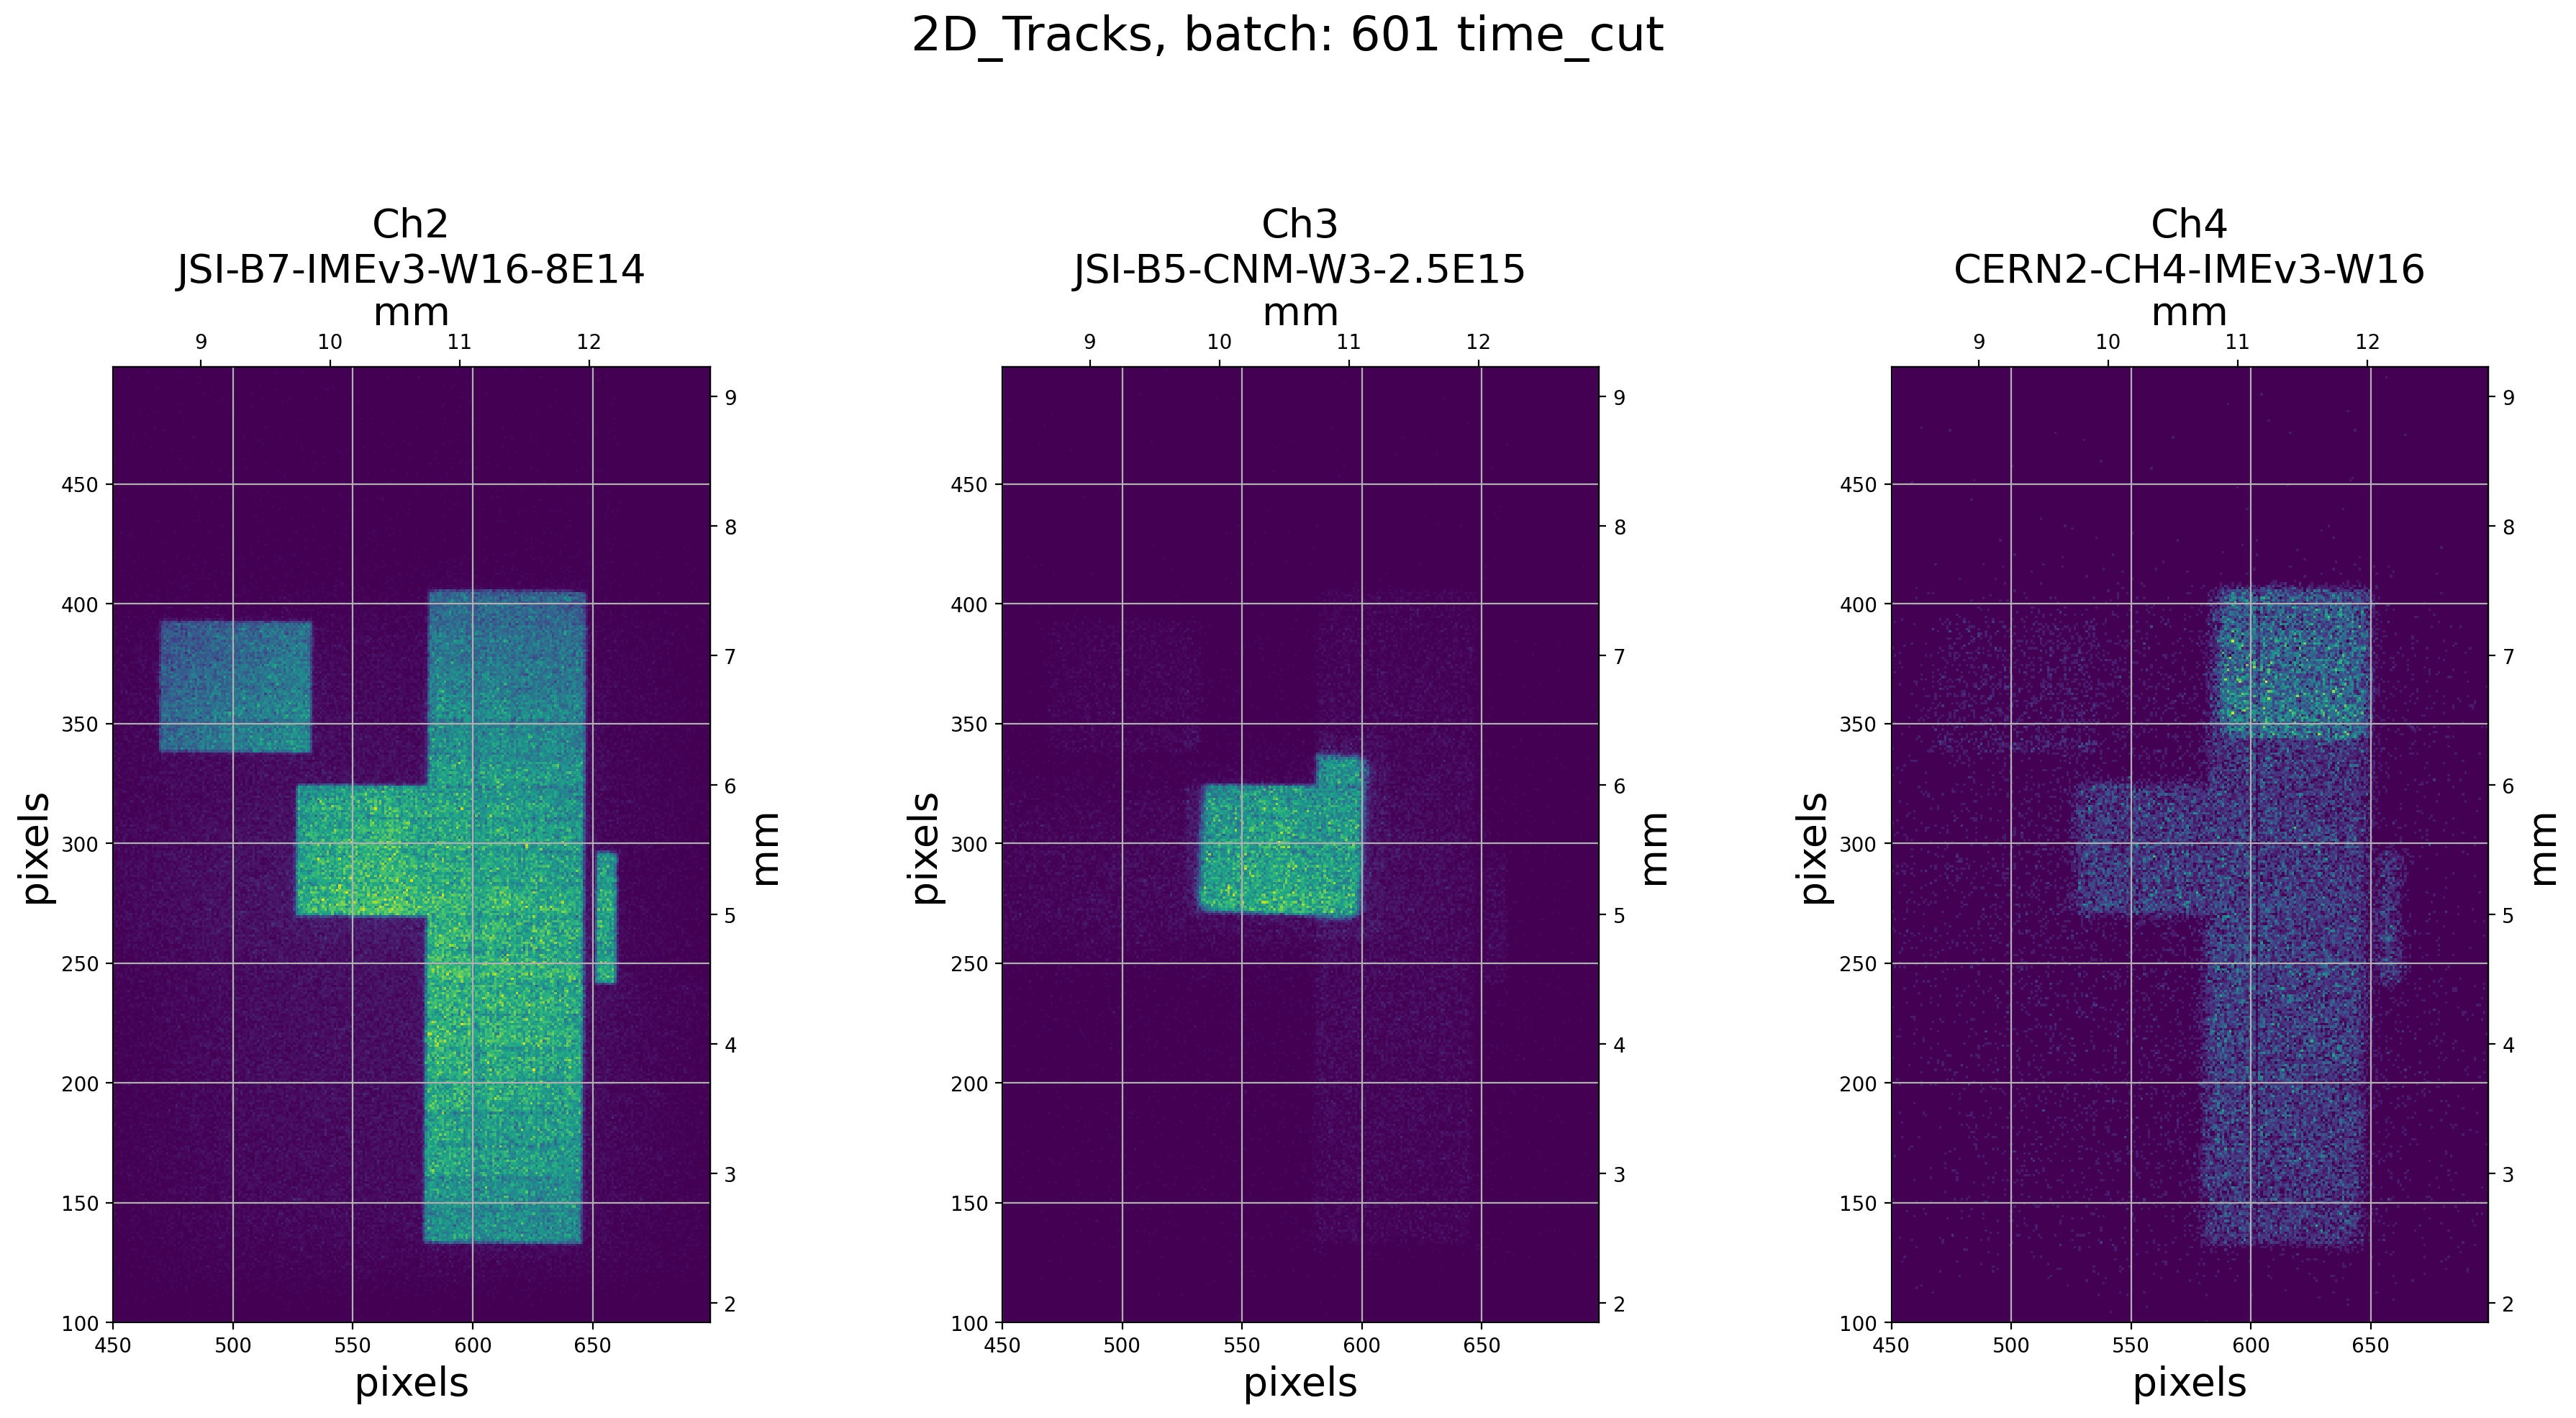

In [33]:
fig,axes = plot(df[this_scope], "2D_Tracks", dict_of_batches[this_batch], this_scope, bins=bins,
                mask=all_time_cut, n_DUT=[1,2,3], savefig=True, savefig_details="time_cut",fmt='jpg')

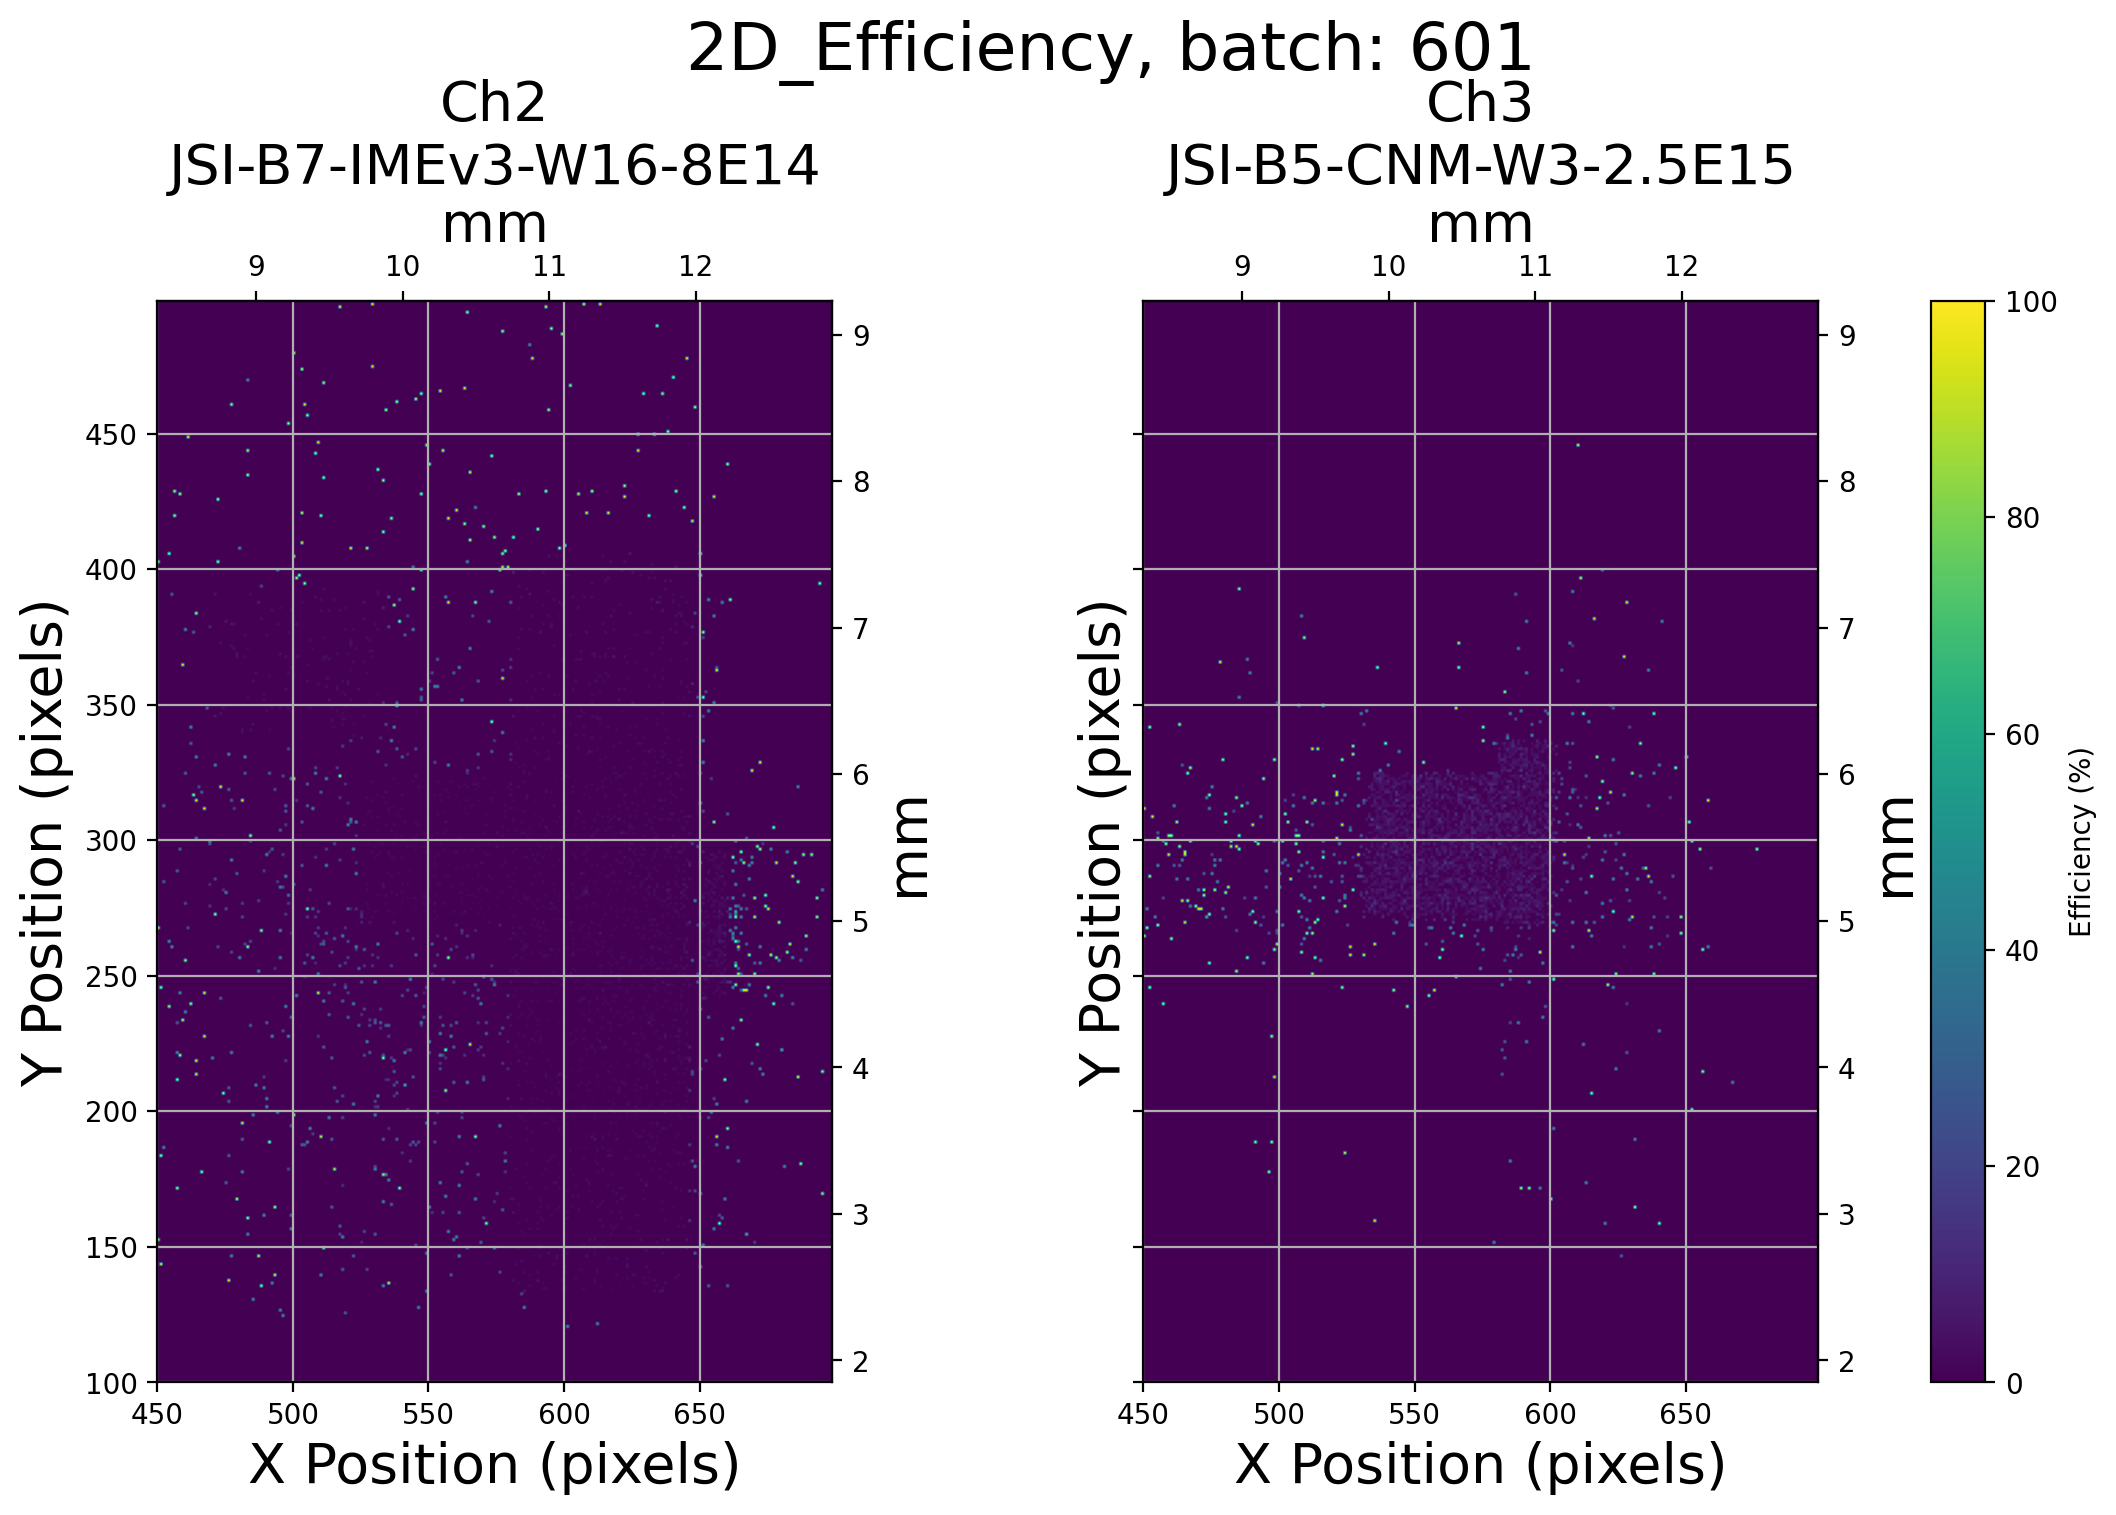

In [40]:
fig, axes = plot(df[this_scope],"2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, mask=all_time_cut, n_DUT=[1,2],
                threshold_charge=threshold_charge )

# fig

### Efficiency with time_cut

[WARNING] - More than one minimum found at: [41.334976, 62.74684]


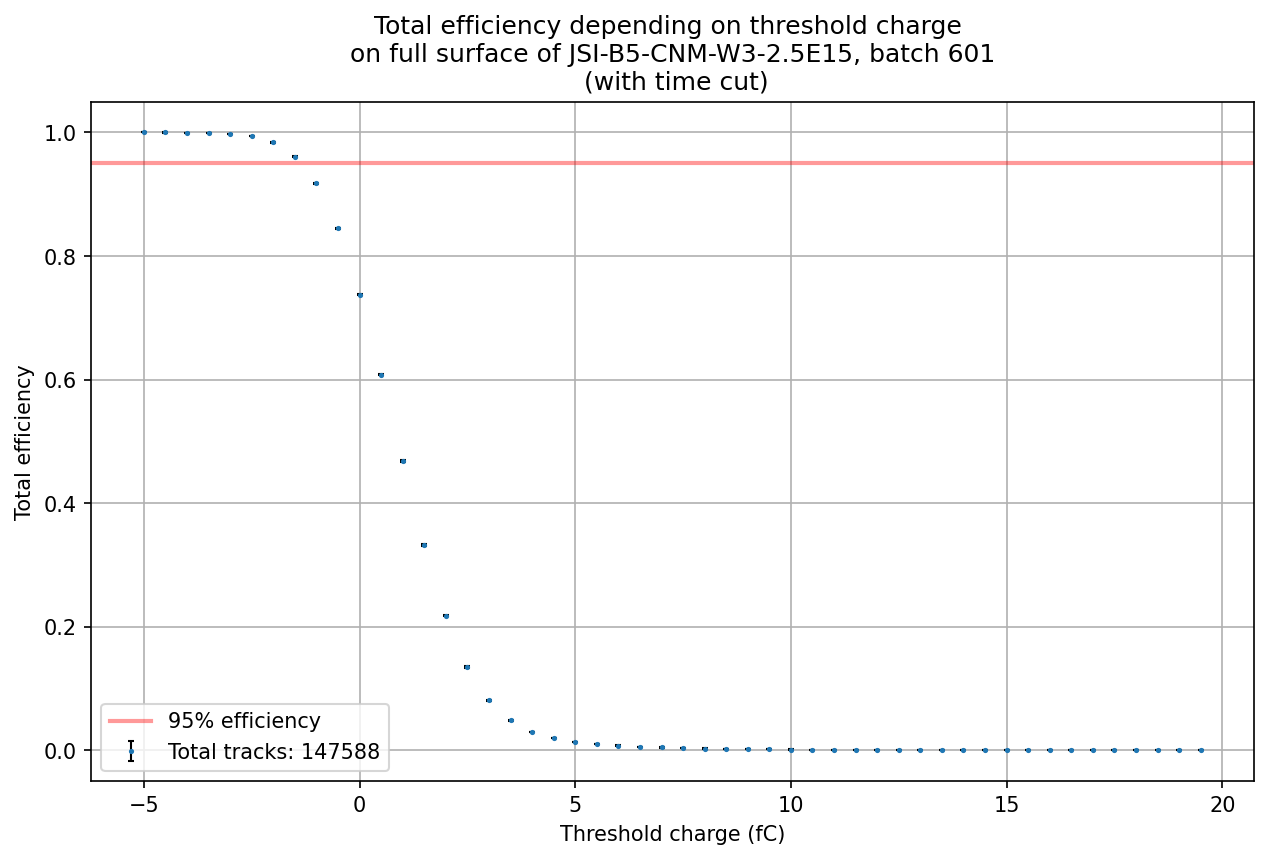

In [41]:
# this_scope = "S2"
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in (1,2,3)]

dut = 2

efficiency_range = []
error_range = []
threshold_range = np.arange(-5, 20, 0.5)
geometry,edges = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut)
# pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]

for charge in threshold_range:
    ### efficiency with error
    eff, err = efficiency_error(
        df[this_scope][f"charge_{dut}"].loc[all_time_cut[dut-1]]/transimpedance[dut-1], charge)
    efficiency_range.append(eff)
    error_range.append(err) 

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.errorbar(threshold_range, efficiency_range, yerr=error_range, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
        label=f"Total tracks: {df[this_scope][f'charge_{dut}'].loc[all_time_cut[dut-1]].size}")
ax.set_title(f"Total efficiency depending on threshold charge \n \
on full surface of {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch} \n \
(with time cut)")
ax.set_xlabel("Threshold charge (fC)")
ax.set_ylabel("Total efficiency")
ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
ax.grid('--')
ax.legend()

# fig.savefig(f"../various plots/Total_efficiency_change_{this_batch}_{this_scope}_DUT{dut}_with_time_cut.svg" ,bbox_inches='tight')

## Now combine all efficiencies

In [42]:
print(mins[this_scope][dut])

41.334976


[WARNING] - More than one minimum found at: [41.334976, 62.74684]
[WARNING] - More than one minimum found at: [41.334976, 62.74684]


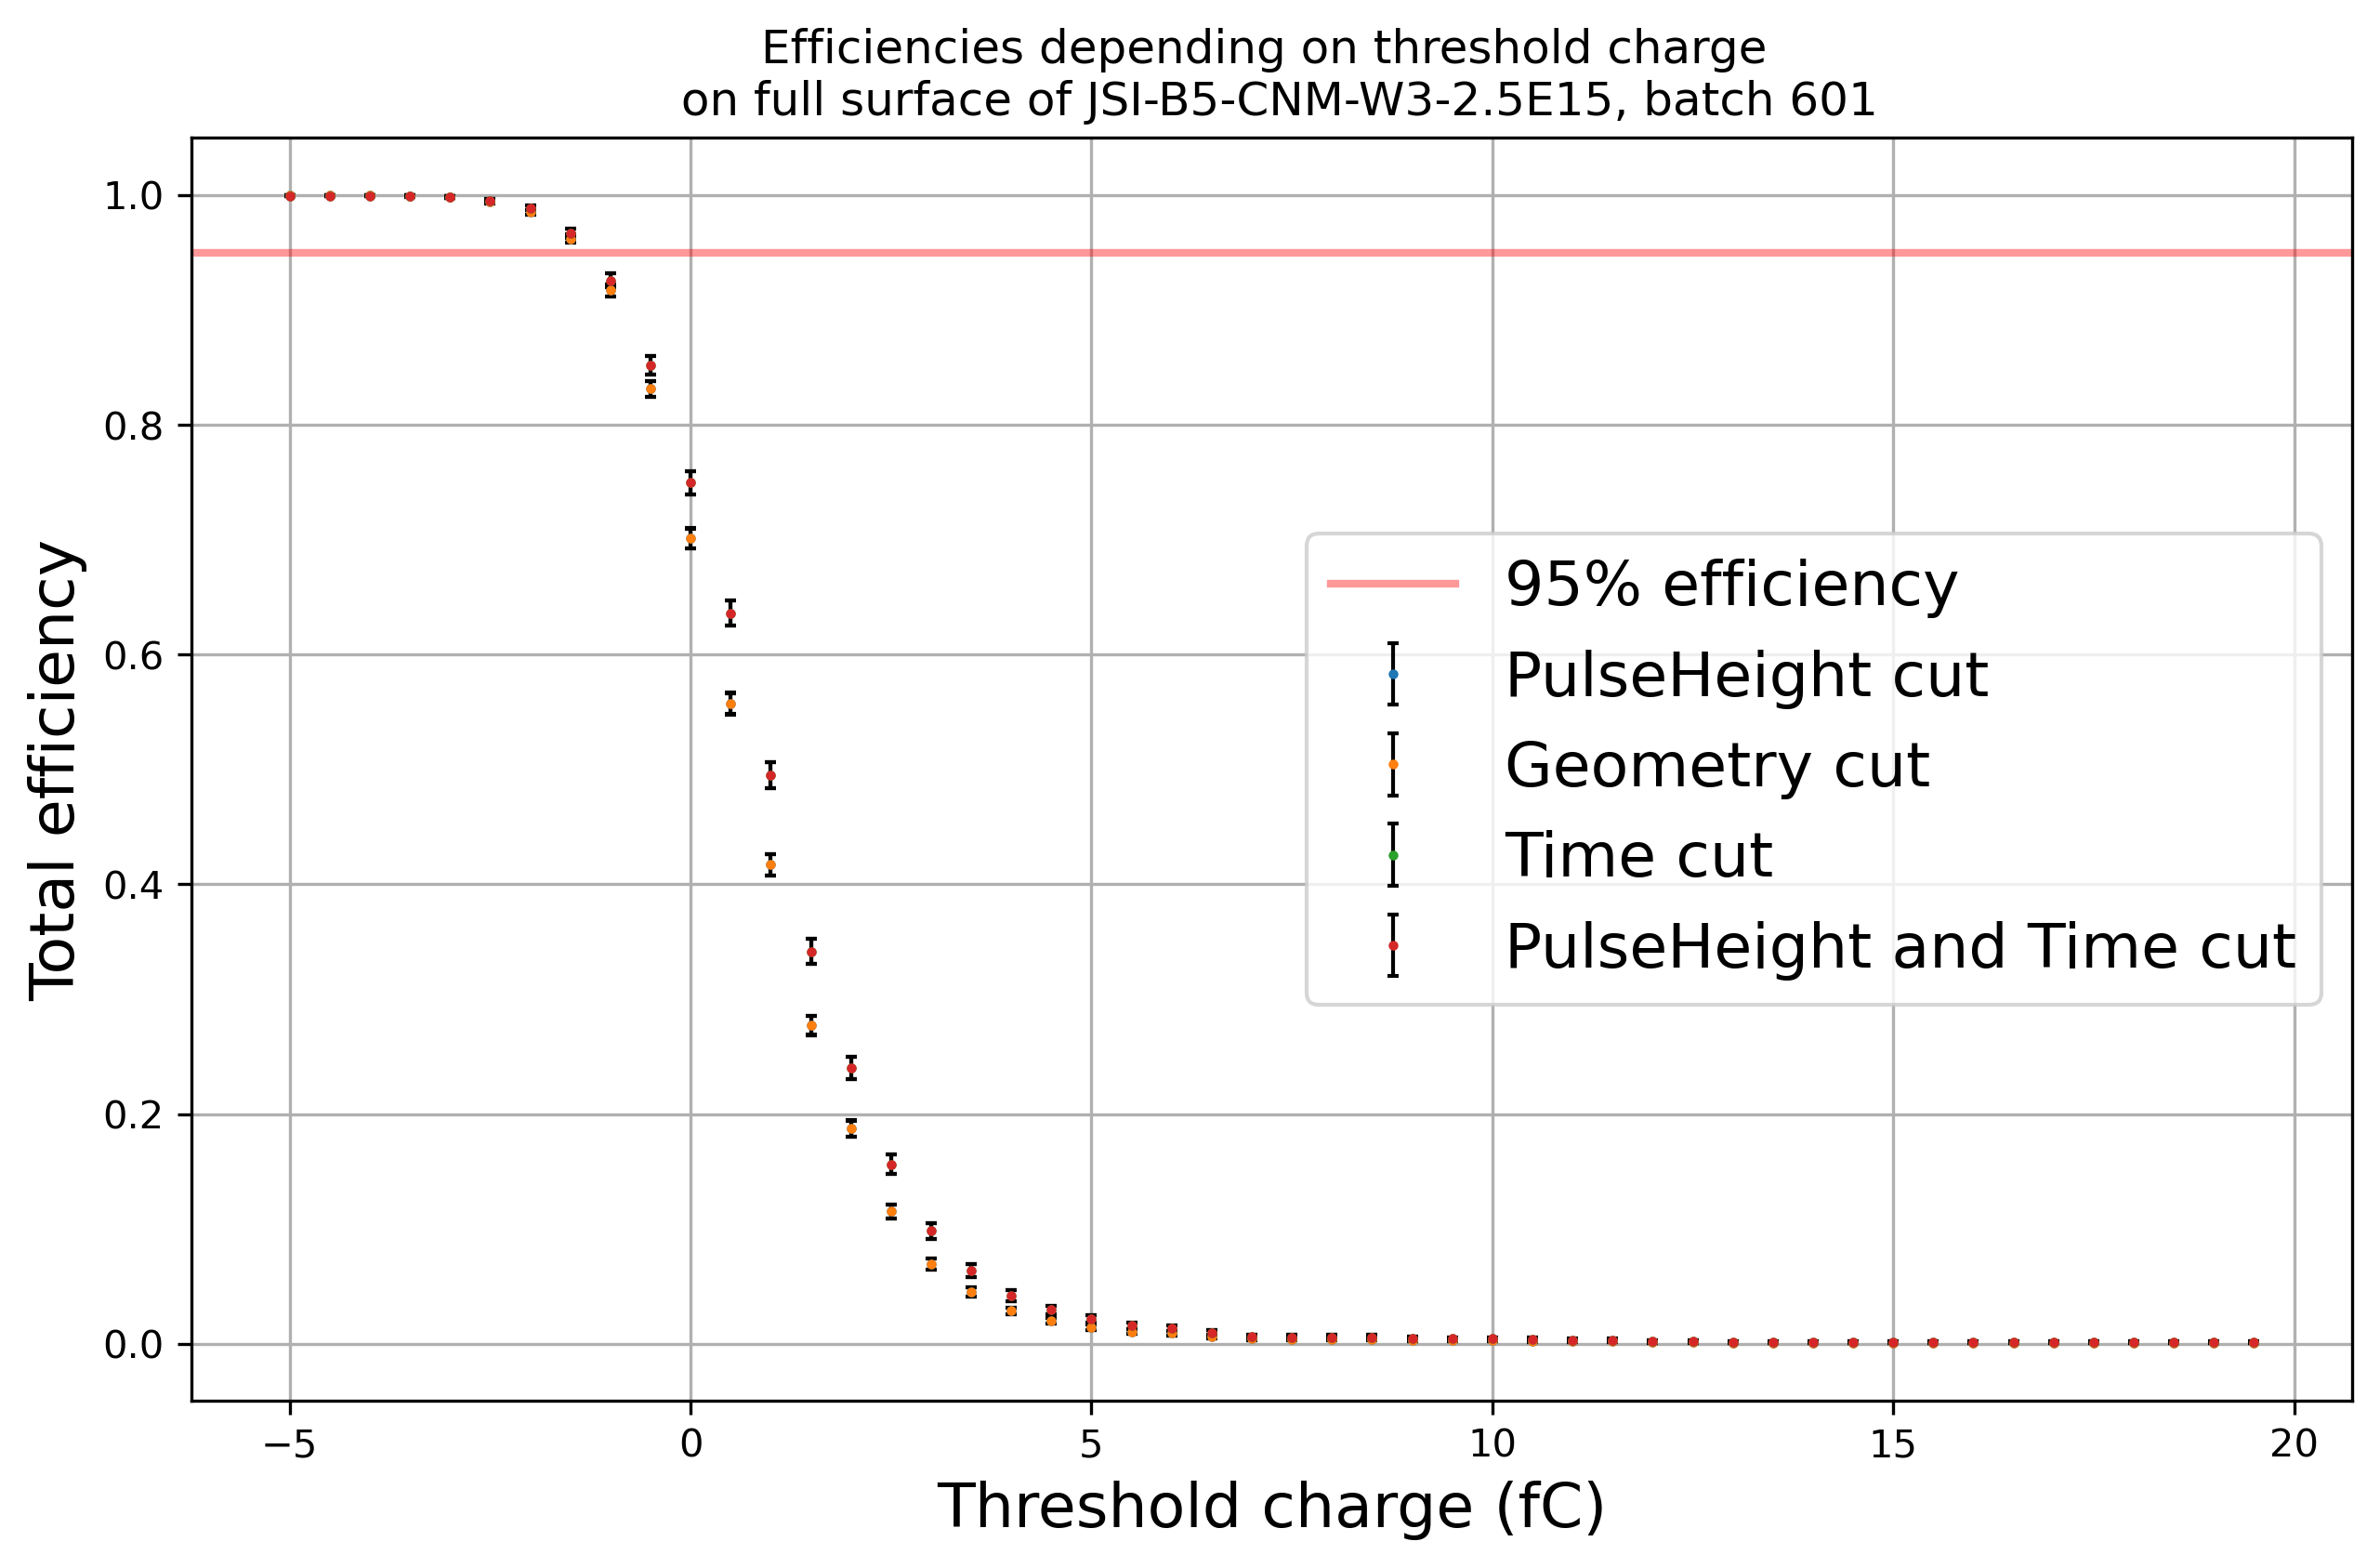

In [43]:
this_scope = "S2"
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in (1,2,3)]

dut = 2
threshold_range = np.arange(-5, 20, 0.5)

efficiency_pulse_cut = []
error_pulse_cut = []

efficiency_center = []
error_center = []

efficiency_time_cut = []
error_time_cut = []

efficiency_pulse_time_cut = []
error_pulse_time_cut = []

geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut)[0]
geometry_center = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut, only_center=False)[0]
pulse_min = 5 # mins[this_scope][dut]
pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>pulse_min

for charge in threshold_range:
    ### efficiency with pulseHeight cut
    eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)
    efficiency_pulse_cut.append(eff)
    error_pulse_cut.append(err) 
    ### efficiency with geometry cut
    eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[geometry_center]/transimpedance[dut-1], charge)
    efficiency_center.append(eff)
    error_center.append(err) 
    ### efficiency with time cut
    eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,all_time_cut[dut-1])]/transimpedance[dut-1], charge)
    efficiency_time_cut.append(eff)
    error_time_cut.append(err)
    ### efficiency with pulseHeight AND time cuts
    eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,np.logical_and(pulseHeight,all_time_cut[dut-1]))]/transimpedance[dut-1], charge)
    efficiency_pulse_time_cut.append(eff)
    error_pulse_time_cut.append(err)
    
    
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
### pulseHeight cut
ax.errorbar(threshold_range, efficiency_pulse_cut, yerr=error_pulse_cut, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"PulseHeight cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
### central area
ax.errorbar(threshold_range, efficiency_center, yerr=error_center, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"Geometry cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
### time cut
ax.errorbar(threshold_range, efficiency_time_cut, yerr=error_time_cut, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"Time cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

### pulseHeight AND time cuts
ax.errorbar(threshold_range, efficiency_pulse_time_cut, yerr=error_pulse_time_cut, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"PulseHeight and Time cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

ax.set_title(f"Efficiencies depending on threshold charge \n \
on full surface of {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch}")
ax.set_xlabel("Threshold charge (fC)",fontsize=16)
ax.set_ylabel("Total efficiency",fontsize=16)
ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
ax.grid('--')
ax.legend(fontsize=16)
# fig.savefig(f"../various plots/Total_efficiencies_change_{this_batch}_{this_scope}_DUT{dut}_different_cuts.svg")

[WARNING] - More than one minimum found at: [41.334976, 62.74684]


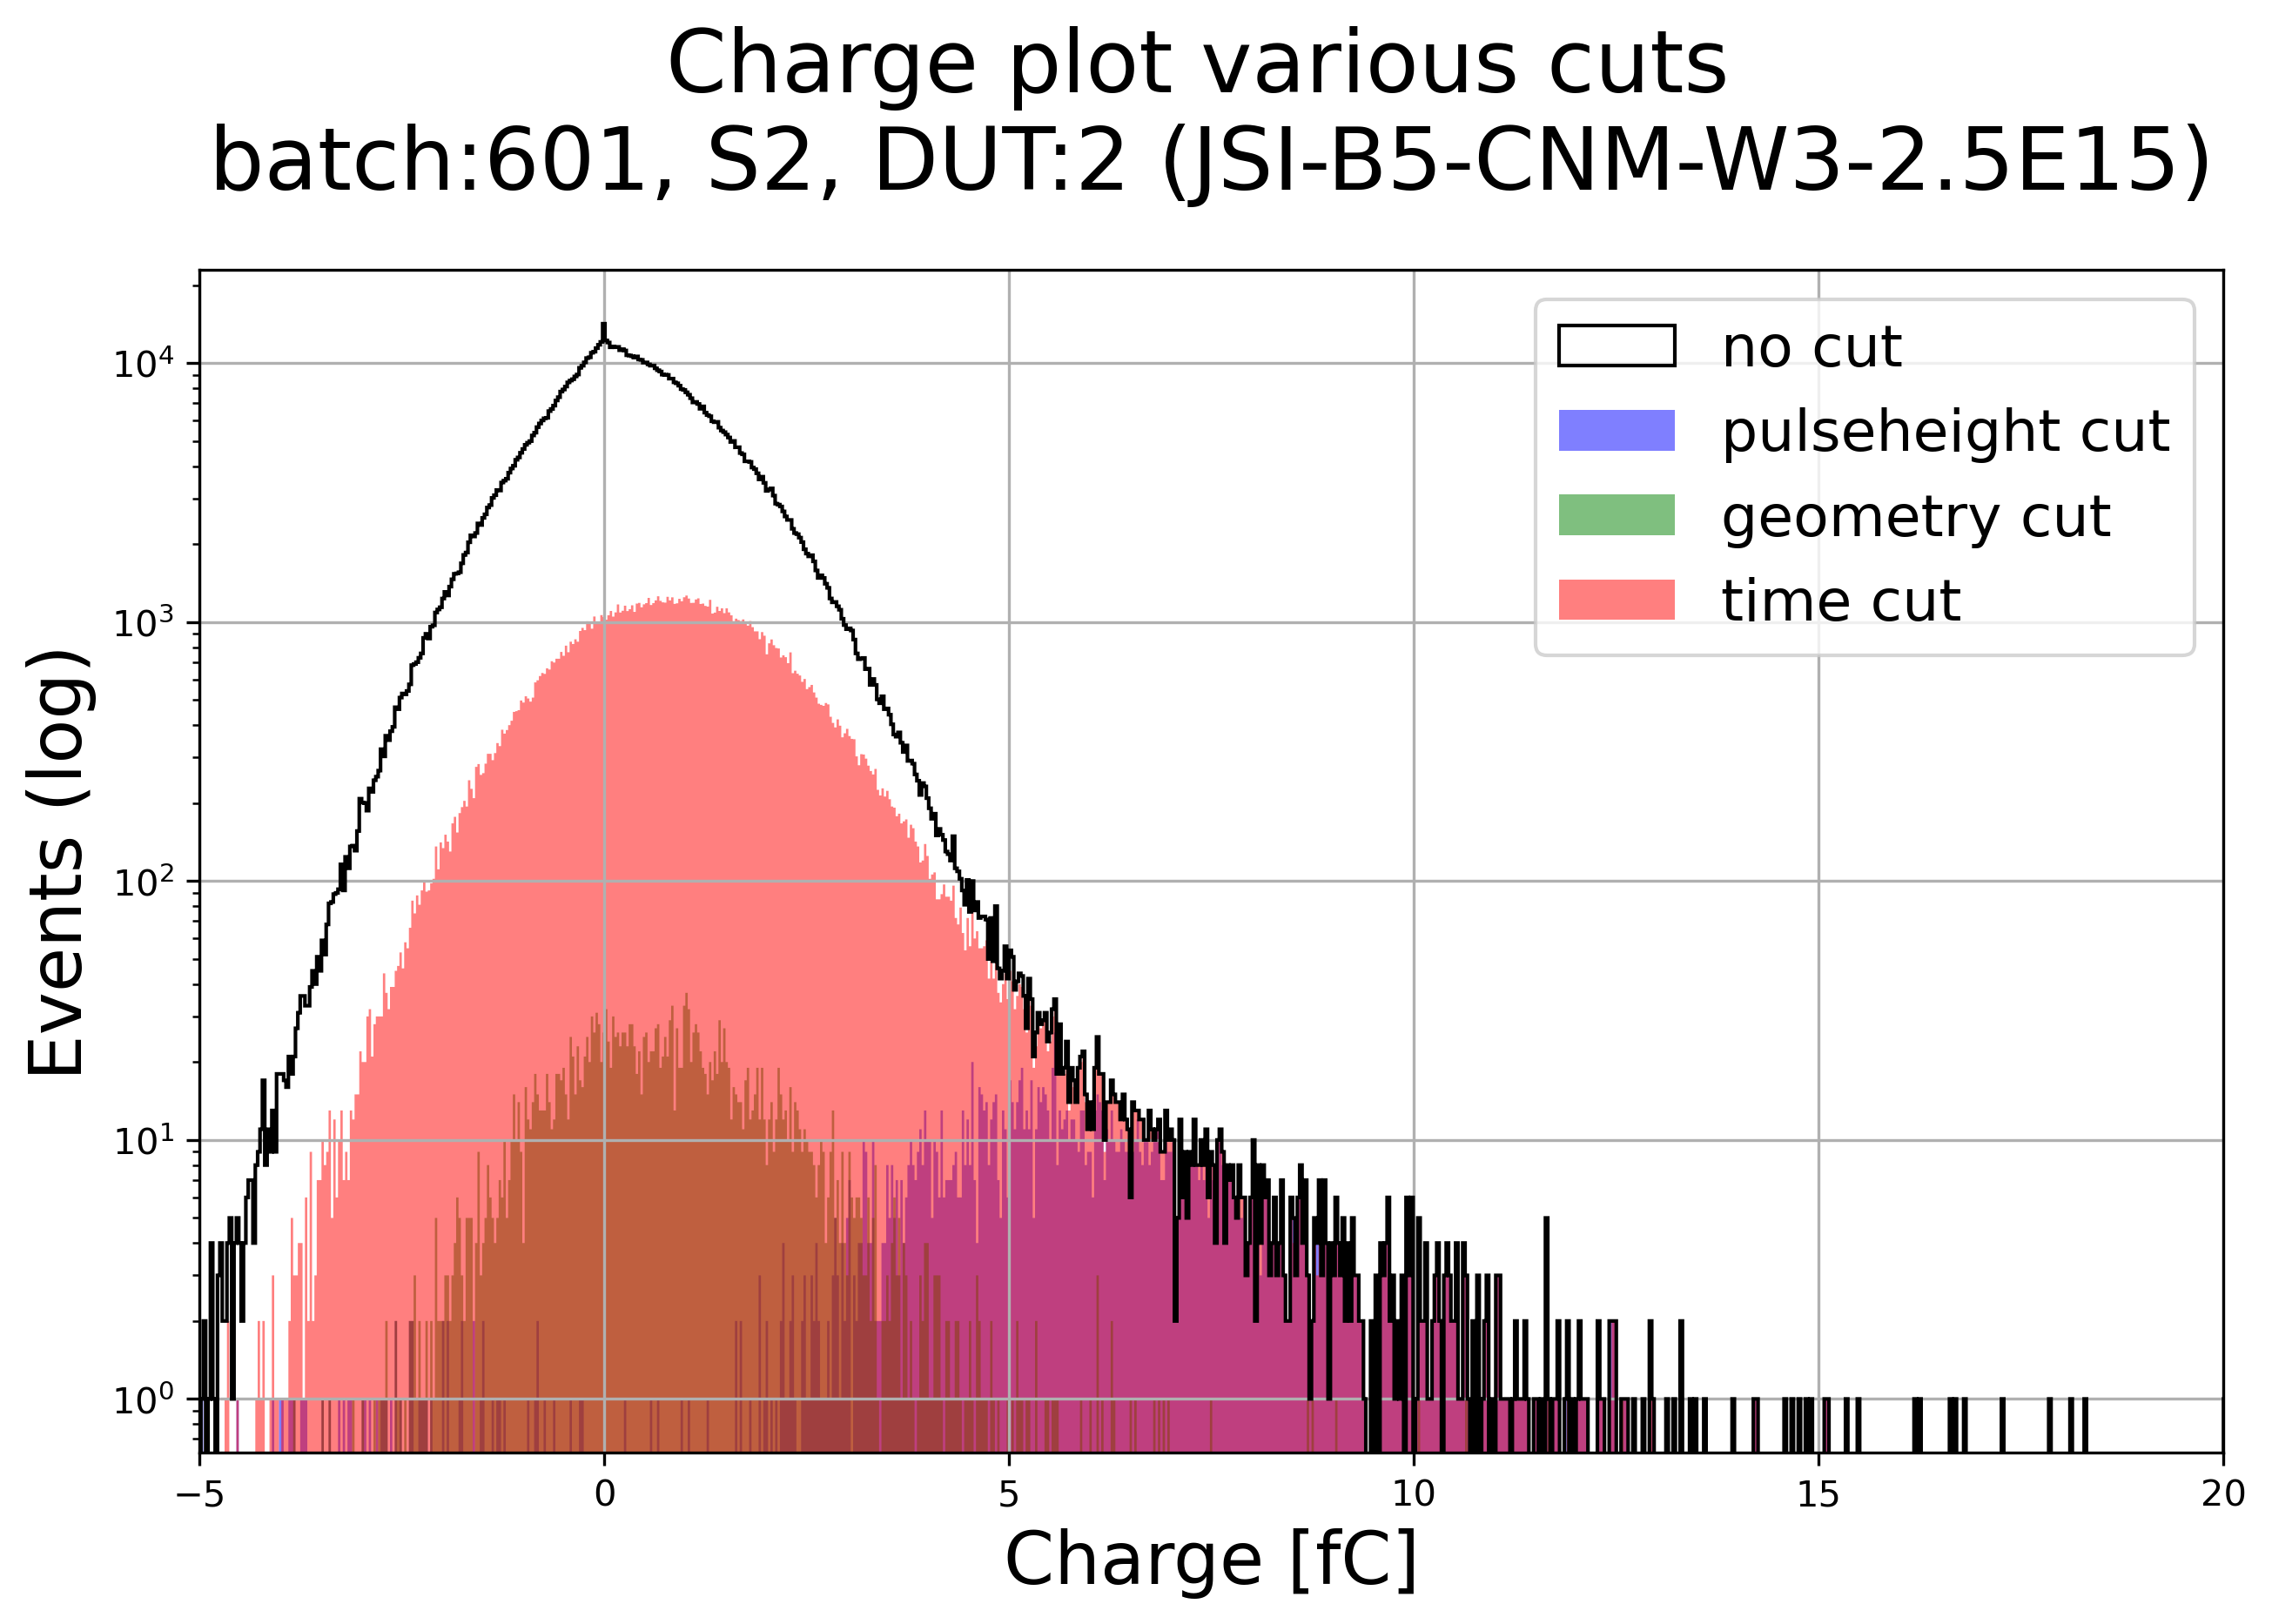

In [44]:
# mins = {"S1":[0,53.8,52.1,65.3], "S2":[0,37.9,51.6,64.3]}
# this_scope = "S2"
this_DUT = 2 ### 1,2,3
# transimpedance = get_transimpedance(this_batch, this_scope)[this_DUT-1]
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in (1,2,3)]


pulseheight_cut = df[this_scope][f"pulseHeight_{this_DUT}"]>mins[this_scope][this_DUT]
geometry_cut = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=this_DUT)[0]
time_cut = all_time_cut[this_DUT-1]

data_pulse_filter = df[this_scope][f"charge_{this_DUT}"].loc[pulseheight_cut]/transimpedance[this_DUT-1]
# data_pulse_geo_filter = df[this_scope][f"charge_{this_DUT}"].loc[np.logical_and(pulseheight_cut, geometry_cut)]/transimpedance[this_DUT-1]
data_geo_filter = df[this_scope][f"charge_{this_DUT}"].loc[geometry_cut]/transimpedance[this_DUT-1]
data_time_filter = df[this_scope][f"charge_{this_DUT}"].loc[time_cut]/transimpedance[this_DUT-1]

### I need to figure out how to combine colors into nice thing
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
hist, bins_for_all, _,_,_ = plot_histogram(df[this_scope][f"charge_{this_DUT}"]/transimpedance[this_DUT-1], bins='auto', label="no cut", fig_ax=(fig,ax), color=colormap[0], linewidth=1)
plot_histogram(data_pulse_filter, bins=bins_for_all, fig_ax=(fig,ax), label="pulseheight cut", alpha=.5, color=colormap[1], histtype='stepfilled')
# plot_histogram(data_pulse_geo_filter, bins=bins_for_all, fig_ax=(fig,ax), label="pulseheight & geom. cut", alpha=.5, color='#ff0000')
plot_histogram(data_geo_filter, bins=bins_for_all, fig_ax=(fig,ax), label="geometry cut", alpha=.5, color=colormap[2], histtype='stepfilled') # #ffff00
plot_histogram(data_time_filter, bins=bins_for_all, fig_ax=(fig,ax), label="time cut", alpha=.5, color=colormap[3], histtype='stepfilled') # #ffff00

ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"Charge plot various cuts \nbatch:{this_batch}, {this_scope}, DUT:{this_DUT} ({dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name})",
             fontsize=24,y=1.05)
ax.grid('--')
ax.set_xlim(-5,20)
ax.semilogy()
ax.legend(fontsize=16)

# fig.savefig(f"../various plots/charge_plot_various_cuts_{this_batch}_{this_scope}_DUT{this_DUT}.svg",bbox_inches='tight')

In [45]:
plot(df[this_scope])

TypeError: plot() missing 3 required positional arguments: 'plot_type', 'batch_object', and 'this_scope'

## Charge plot with both pulseHeight and geometry cut
And Landau*Gaussian convolution

In [ ]:
this_DUT = 1

geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min=binning_method, DUT_number=this_DUT)[0]
pulse_cut = df[this_scope][f'pulseHeight_{this_DUT}']>mins[this_scope][this_DUT]

fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')

charge_hist, bins_hist, _ = ax.hist(df[this_scope][f"charge_{this_DUT}"].loc[pulse_cut]/transimpedance[this_DUT-1],
                                    bins='auto', histtype='step', label='Charge Histogram')
bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, charge_hist, p0=(10,10,1,np.max(charge_hist)))
# print(param)
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()

# ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
# fig.savefig(f"../various plots/Charge_distribution_fit_Ch2_{this_batch}.svg",bbox_inches='tight')


In [ ]:
plt.hist(df['S1']['charge_1']/get_transimpedance(this_batch,'S1')[1], bins='auto');

In [ ]:
# dut = 1

# fig, axes = plt.subplots(figsize=(15,5),nrows=1,ncols=2, dpi=300)
# for this_scope in ["S1","S2"]:
#     pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
#     hist,my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=10000, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[0])) ### MCP - CERN1
#     plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=my_bins, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[1]));### MCP - CERN1
#     hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, bins=my_bins, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1 \n with pulseHeigh cut", fig_ax=(fig,axes[1]))  ### MCP - CERN3
#     time_peak, info_peaks = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10) 
#     axes[0].axvline(my_bins[time_peak],color='r',linewidth=.5)
#     axes[0].axvline(my_bins[info_peaks['left_bases']],color='g')
#     axes[0].axvline(my_bins[info_peaks['right_bases']],color='r')
#     print("peak position:",my_bins[time_peak][0],"ns")
    
    
# axes[0].set_title(f"Time difference")
# axes[0].set_xlabel("Time (ns)")
# axes[0].set_xlim(-8,-2)
# axes[1].set_xlim(-8,-2)
# axes[1].set_xlabel("Time (ns)")
# axes[1].set_title("Time difference (w/ pulseHeight cut))")
# axes[0].legend()
# axes[1].legend()
# fig.suptitle(f"Batch: {this_batch}, Oscilloscope: {this_scope}",y=1.1, fontsize=20)
# # fig.savefig(f"../various plots/time_difference{this_batch}_DUT{dut}_with_pulseHeight_cut.svg",bbox_inches='tight')
# # fig.savefig(f"../various plots/time_difference{this_batch}_S{this_scope}_all_DUTs_with_pulseHeight_cut.svg",bbox_inches='tight')

#### I was trying to plot the FE-I4 mask but it does not quite work

In [ ]:
# ### I was trying to plot the FE-I4 mask but it does not quite work

# ### Create a figure and axis
# fig, ax = plt.subplots()
# ### Define the coordinates, width, and height of multiple rectangles
# rectangles = [#(0,0,210,297), # x,y,width, height
#               (0,297,297,210),
#               (210,0,210,297),
#               (420,0,210,297),
#               (297,297,297,210)]

# ### Loop through the list of rectangles and draw them
# for i, rect in enumerate(rectangles):
#     x, y, width, height = rect
#     ax.add_patch(mpatches.Rectangle((x, y), width, height, fill=True, alpha=0.5, color=colormap[i]))

# ### Set axis limits if needed
# ax.set_xlim(0,700)
# ax.set_ylim(0,500)

# ### Display the plot
# plt.gca().set_aspect('equal', adjustable='box')  # Make sure aspect ratio is equal
# plt.show()

#### I'm experimenting with multidimensional dataframes (?)